# Wasserstein Generative Adversarial Network (WGAN)

Modified from code at: https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/

In [1]:
from keras.datasets import fashion_mnist
import numpy as np
import pandas as pd

Using TensorFlow backend.


## Load Dataset
Define class labels

In [2]:
# classes dictionary
label_dict = {0: 'tshirt',
             1: 'trouser',
             2: 'pullover',
             3: 'dress',
             4: 'coat',
             5: 'sandal',
             6: 'shirt',
             7: 'sneaker',
             8: 'bag',
             9: 'boot'}

In [3]:
def load_fashion_minst_data():
    # load the data
    (x_train, y_train), (_, _) = fashion_mnist.load_data()

    # expand to 3d, e.g. add channels dimension
    x_train = np.expand_dims(x_train, axis=-1)
    
    # normalize our inputs to be in the range[-1, 1] 
    x_train = (x_train.astype(np.float32) - 127.5)/127.5

    return x_train, y_train

 
x_train, y_train = load_fashion_minst_data()
input_classes =pd.Series(y_train).nunique()
print("x_train shape: {}".format(x_train.shape))
print("y_train.shape:{}".format(y_train.shape))
print("Input classes:{}".format(input_classes))

x_train shape: (60000, 28, 28, 1)
y_train.shape:(60000,)
Input classes:10


## Base GAN Class

In [10]:
from IPython.display import SVG
from keras.layers import Concatenate, Input, Dense, Reshape, Flatten, Dropout, multiply, \
    BatchNormalization, Activation, Embedding, ZeroPadding2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot, plot_model
from matplotlib import pyplot
import numpy as np
 
class GAN():
    
    def __init__(self, in_shape=(28,28,1), n_classes=10, latent_dim=100):
        # size of the latent space
        self.in_shape = in_shape
        self.n_classes = n_classes
        self.latent_dim = latent_dim
        self.optimizer = Adam(lr=0.0002, beta_1=0.5) 
        
        # create the discriminator
        self.d_model = self.build_discriminator()
        
        # create the generator
        self.g_model = self.build_generator()
        
        # create the gan
        self.gan_model = self.build_gan()
       
    def build_discriminator(self):
        """define the standalone discriminator model"""
        # label input
        in_label = Input(shape=(1,))
        # embedding for categorical input
        li = Embedding(self.n_classes, 50)(in_label)
        # scale up to image dimensions with linear activation
        n_nodes = self.in_shape[0] * self.in_shape[1]
        li = Dense(n_nodes)(li)
        # reshape to additional channel
        li = Reshape((self.in_shape[0], self.in_shape[1], 1))(li)
        # image input
        in_image = Input(shape=self.in_shape)
        # concat label as a channel
        merge = Concatenate()([in_image, li])
        # downsample
        fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
        fe = LeakyReLU(alpha=0.2)(fe)
        # downsample
        fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        # flatten feature maps
        fe = Flatten()(fe)
        # dropout
        fe = Dropout(0.4)(fe)
        # output
        out_layer = Dense(1, activation='sigmoid')(fe)
        # define model
        model = Model([in_image, in_label], out_layer)
        # compile model
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return model
    
    def build_generator(self):
        """define the standalone generator model"""
        # label input
        in_label = Input(shape=(1,))
        # embedding for categorical input
        li = Embedding(self.n_classes, 50)(in_label)
        # linear multiplication
        n_nodes = 7 * 7
        li = Dense(n_nodes)(li)
        # reshape to additional channel
        li = Reshape((7, 7, 1))(li)
        # image generator input
        in_lat = Input(shape=(self.latent_dim,))
        # foundation for 7x7 image
        n_nodes = 128 * 7 * 7
        gen = Dense(n_nodes)(in_lat)
        gen = LeakyReLU(alpha=0.2)(gen)
        gen = Reshape((7, 7, 128))(gen)
        # merge image gen and label input
        merge = Concatenate()([gen, li])
        # upsample to 14x14
        gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
        gen = LeakyReLU(alpha=0.2)(gen)
        # upsample to 28x28
        gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
        gen = LeakyReLU(alpha=0.2)(gen)
        # output
        out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
        # define model
        model = Model([in_lat, in_label], out_layer)
        return model

    def build_gan(self):
        """define the combined generator and discriminator model, for updating the generator"""
        # make weights in the discriminator not trainable
        self.d_model.trainable = False
        # get noise and label inputs from generator model
        gen_noise, gen_label = self.g_model.input
        # get image output from the generator model
        gen_output = self.g_model.output
        # connect image output and label input from generator as inputs to discriminator
        gan_output = self.d_model([gen_output, gen_label])
        # define gan model as taking noise and label and outputting a classification
        model = Model([gen_noise, gen_label], gan_output)
        # compile model
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt)
        return model  
    
    @staticmethod
    def plot_model(model, filename=None):
        """Plot the specified model, either to file, or return as an SVG if no filename is specified"""
        if filename is None:
            return(SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg')))
        else:
            plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True)
            
    def plot_generator(self, filename=None):
        """Plot the generator model, either to file, or return as an SVG if no filename is specified"""
        return(self.plot_model(self.g_model))
    
    def plot_discriminator(self, filename=None):
        """Plot the discriminator model, either to file, or return as an SVG if no filename is specified"""
        return(self.plot_model(self.d_model))
                
    def plot_gan(self, filename=None):
        """Plot the gan model, either to file, or return as an SVG if no filename is specified"""
        return(self.plot_model(self.g_model))
    
    def generate_real_samples(self, X, n_samples):
        """select real samples"""
        # choose random instances
        ix = np.random.randint(0, X.shape[0], n_samples)
        # select images and labels
        selected_X = X[ix]
        # generate 'real' class labels (1)
        y = np.ones((n_samples, 1))
        return selected_X, y

    def generate_latent_points(self, n_samples):
        """generate points in latent space as input for the generator"""
        # generate points in the latent space
        latent_points = np.random.randn(self.latent_dim * n_samples)
        # reshape into a batch of inputs for the network
        latent_points = latent_points.reshape(n_samples, self.latent_dim)
        return latent_points
    
    def generate_generator_prediction_samples(self, n_samples):
        """use the generator to generate n fake examples"""
        # generate points in latent space
        latent_points = self.generate_latent_points(n_samples)
        # predict outputs
        X = self.generator_prediction(latent_points)
        # create class labels
        y = np.zeros((n_samples, 1))
        return X, y
      
    def generator_prediction(self, latent_points):
        """use the generator to predict outputs for the given latent space"""
        return self.g_model.predict(latent_points)
    
    def train(self, X, labels, n_epochs=100, n_batch=128, reporting_period=10):
        """train the generator and discriminator"""
        bat_per_epo = int(X.shape[0] / n_batch)
        half_batch = int(n_batch / 2)
        
        # for recording metrics.
        self.g_loss = np.zeros((n_epochs * bat_per_epo, 1))
        self.d_loss_real = np.zeros((n_epochs * bat_per_epo, 1))        
        self.d_loss_fake = np.zeros((n_epochs * bat_per_epo, 1))
        self.d_acc_real = np.zeros((n_epochs * bat_per_epo, 1))
        self.d_acc_fake = np.zeros((n_epochs * bat_per_epo, 1))
        self.d_acc_real_epochs = np.zeros((n_epochs, 1))
        self.d_acc_fake_epochs = np.zeros((n_epochs, 1))
        
        # manually enumerate epochs
        for i in range(n_epochs):
            
            # enumerate batches over the training set
            for j in range(bat_per_epo):
                # update discriminator model weights on randomly selected 'real' samples
                [X_real, labels_real], y_real = self.generate_real_samples(X, labels, half_batch)
                d_loss1, d_acc1  = self.d_model.train_on_batch([X_real, labels_real], y_real)
                
                # update discriminator model weights on generated 'fake' examples
                [X_fake, labels_fake], y_fake = self.generate_generator_prediction_samples(half_batch)
                d_loss2, d_acc2 = self.d_model.train_on_batch([X_fake, labels_fake], y_fake)
                
                # prepare points in latent space as input for the generator
                [z_input, labels_input] = self.generate_latent_points(n_batch)
                # create inverted labels for the fake samples
                y_gan = np.ones((n_batch, 1))
                # update the generator via the discriminator's error
                g_loss = self.gan_model.train_on_batch([z_input, labels_input], y_gan)
                
                # summarize loss on this batch
                print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                    (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

                # record losses for later
                self.g_loss[i*bat_per_epo + j] = g_loss
                self.d_loss_real[i*bat_per_epo + j] = d_loss1
                self.d_loss_fake[i*bat_per_epo + j] = d_loss2
                self.d_acc_real[i*bat_per_epo + j] = d_acc1
                self.d_acc_fake[i*bat_per_epo + j] = d_acc2

            # save per epoch metrics 
            # evaluate discriminator on real examples
            n_samples = 100
            x_real, y_real = self.generate_real_samples(X, labels, n_samples)
            _, acc_real = self.d_model.evaluate(x_real, y_real, verbose=0)
            self.d_acc_real_epochs[i] = acc_real
            
            # evaluate discriminator on fake examples
            x_fake, y_fake = self.generate_generator_prediction_samples(n_samples)
            _, acc_fake = self.d_model.evaluate(x_fake, y_fake, verbose=0)
            self.d_acc_fake_epochs[i] = acc_fake
            
            # every reporting_period, plot out images.
            if i == 0 or (i+1) % reporting_period == 0 or (i+1) == n_epochs:
                self.summarize_performance(i+1)
                
        # save the generator model
        self.save_model()

    def summarize_performance(self, epoch):
        """generate samples and save as a plot and save the model"""
        self.plot_random_generated_images()
        
        # save the plot
        filename1 = 'generated_plot_%04d.png' % (epoch)
        pyplot.savefig(filename1)
        pyplot.close()
        
        # save the generator model
        filename2 = 'model_%04d.h5' % (epoch)
        self.g_model.save(filename2)
        print('>Saved: %s and %s' % (filename1, filename2))

    @staticmethod
    def grid_plot(examples, dimensions=(10, 10), figsize=(10, 10), cmap='gray_r'):
        """create a grid plot of multiple images"""
        pyplot.figure(figsize=figsize)
        for i in range(dimensions[0] * dimensions[1]):
            pyplot.subplot(dimensions[0], dimensions[1], 1 + i)
            pyplot.axis('off')
            pyplot.imshow(np.squeeze(examples[i]), interpolation='nearest', cmap=cmap)
        pyplot.tight_layout()
        pyplot.show()

    def plot_random_generated_images(self):
        """create a plot of randomly generated images (reversed grayscale)"""
        dimensions=(10, 10)
        figsize=(10, 10)
        n_samples=100
        
        X, y_fake = self.generate_generator_prediction_samples(n_samples)
            
        self.grid_plot(X, dimensions=dimensions, figsize=figsize)

        #filename = '%s_generated_plot_e%03d.png' % (identifier, epoch+1)
        #pyplot.savefig(filename)
        #pyplot.close()
    
    def plot_training_metrics(self, figsize = (10,10)):
        fig = plt.figure(figsize=figsize)
        
        # plot loss
        pyplot.subplot(2, 1, 1)
        pyplot.plot(self.d_loss_real, label='Discriminator Loss (real)')
        pyplot.plot(self.d_loss_fake, label='Discriminator Loss (fake)')
        pyplot.plot(self.g_loss, label='Generator Loss')
        pyplot.legend(loc='upper right')
        pyplot.title('Losses')

        # plot accuracy
        pyplot.subplot(2, 1, 2)
        pyplot.plot(self.d_acc_real, label='Discriminator Accuracy (real)')
        pyplot.plot(self.d_acc_fake, label='Discriminator Accuracy (fake)')
        pyplot.ylabel('')
        pyplot.xlabel('batch')
        pyplot.legend(loc='upper right')
        pyplot.title('Accuracies')

        pyplot.tight_layout(rect=[0, 0.00, 1, 0.95])
        fig.suptitle('GAN Per Batch Training Metrics', fontsize=24)  
        pyplot.show()
        
        # save plot to file
        # pyplot.savefig('results_baseline/plot_line_plot_loss.png')
        pyplot.close()

    def plot_discriminator_accuracies(self):
        plt.plot(self.d_acc_real_epochs)
        plt.plot(self.d_acc_fake_epochs)
        plt.title('GAN Per Epoch Discriminator Accuracy')
        plt.ylabel('')
        plt.xlabel('epoch')
        plt.legend(['Discriminator (real)', 'Discriminator (fake)'],loc='upper right')
        plt.show()
        
    def save_model(self):
        """save the model"""
        self.g_model.save('g_model.h5')
        self.d_model.save('d_model.h5')
        self.gan_model.save('gan_model.h5')
       
    def load_model(self):
        """load the model"""
        self.g_model = load_model("g_model.h5")
        self.d_model = load_model("d_model.h5")
        self.gan_model = load_model("gan_model.h5")        

## Wasserstein Gan class

In [11]:
import numpy as np
from keras import backend
from keras.constraints import Constraint
from keras.initializers import RandomNormal
from keras.optimizers import RMSprop

class WGAN(GAN):
    # clip model weights to a given hypercube
    class ClipConstraint(Constraint):
        # set clip value when initialized
        def __init__(self, clip_value):
            self.clip_value = clip_value

        # clip model weights to hypercube
        def __call__(self, weights):
            return backend.clip(weights, -self.clip_value, self.clip_value)

        # get the config
        def get_config(self):
            return {'clip_value': self.clip_value}      
        
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def wasserstein_loss(self, y_true, y_pred):
        """calculate wasserstein loss"""
        return backend.mean(y_true * y_pred) 
    
    def build_discriminator(self):
        """Override building of the discriminator. In this case we are actually billding the WGAN 'critic'"""
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # weight constraint
        const = self.ClipConstraint(0.01)
        # define model
        model = Sequential()
        # downsample to 14x14
        model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=self.in_shape))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        # downsample to 7x7
        model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        # scoring, linear activation
        model.add(Flatten())
        model.add(Dense(1))
        # compile model
        opt = RMSprop(lr=0.00005)
        model.compile(loss=self.wasserstein_loss, optimizer=opt, metrics=['accuracy'])
        return model
    
    def build_generator(self):
        """Override building the standalone generator model"""
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # define model
        model = Sequential()
        # foundation for 7x7 image
        n_nodes = 128 * 7 * 7
        model.add(Dense(n_nodes, kernel_initializer=init, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((7, 7, 128)))
        # upsample to 14x14
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 28x28
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        # output 28x28x1
        model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
        return model

    def build_gan(self):
        """override defining of the combined generator and critic model, for updating the generator"""
        critic = self.d_model
        
        # make weights in the critic not trainable
        critic.trainable = False
        # connect them
        model = Sequential()
        # add generator
        model.add(self.g_model)
        # add the critic
        model.add(critic)
        # compile model
        opt = RMSprop(lr=0.00005)
        model.compile(loss=self.wasserstein_loss, optimizer=opt)
        return model
    
    def generate_real_samples(self, X, n_samples):
        selected_X, _ = super().generate_real_samples(X, n_samples)
        # For WGAN use target as -1 for real 
        return selected_X, -np.ones((n_samples, 1))

    def generate_generator_prediction_samples(self, n_samples):
        """use the generator to generate n fake examples"""
        selected_X, _ = super().generate_generator_prediction_samples(n_samples)
        # For WGAN use target as 1 for fake
        return selected_X, np.ones((n_samples, 1))

    
    def train(self, X, n_epochs=100, n_batch=128, reporting_period=10, n_critic=5):
        """train the generator and discriminator"""
        bat_per_epo = int(X.shape[0] / n_batch)
        half_batch = int(n_batch / 2)
        
        # for recording metrics.
        self.g_loss = np.zeros((n_epochs * bat_per_epo, 1))
        self.d_loss_real = np.zeros((n_epochs * bat_per_epo, 1))        
        self.d_loss_fake = np.zeros((n_epochs * bat_per_epo, 1))
        self.d_acc_real = np.zeros((n_epochs * bat_per_epo, 1))
        self.d_acc_fake = np.zeros((n_epochs * bat_per_epo, 1))
        self.d_acc_real_epochs = np.zeros((n_epochs, 1))
        self.d_acc_fake_epochs = np.zeros((n_epochs, 1))
        
        # manually enumerate epochs
        for i in range(n_epochs):
            
            # enumerate batches over the training set
            for j in range(bat_per_epo):
                # update the critic more than the generator
                c1_tmp, c2_tmp = list(), list()    
                for _ in range(n_critic):
                    # update critic model weights on randomly selected 'real' samples
                    X_real, y_real = self.generate_real_samples(X, half_batch)
                    c_loss1, _ = self.d_model.train_on_batch(X_real, y_real)
                    c1_tmp.append(c_loss1)
                    
                    # update discriminator model weights on generated 'fake' examples
                    X_fake, y_fake = self.generate_generator_prediction_samples(half_batch)
                    c_loss2, _ = self.d_model.train_on_batch(X_fake, y_fake)
                    c2_tmp.append(c_loss2)
                # store critic loss
                d_loss1 = np.mean(c1_tmp)
                d_loss2 = np.mean(c2_tmp)
                
                # prepare points in latent space as input for the generator
                z_input = self.generate_latent_points(n_batch)
                # create inverted labels for the fake samples
                y_gan = -np.ones((n_batch, 1))
                # update the generator via the discriminator's error
                g_loss = self.gan_model.train_on_batch(z_input, y_gan)
                
                # summarize loss on this batch
                print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                    (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

                # record losses for later
                self.g_loss[i*bat_per_epo + j] = g_loss
                self.d_loss_real[i*bat_per_epo + j] = d_loss1
                self.d_loss_fake[i*bat_per_epo + j] = d_loss2
                self.d_acc_real[i*bat_per_epo + j] = 0
                self.d_acc_fake[i*bat_per_epo + j] = 0

            # save per epoch metrics 
            # evaluate discriminator on real examples
            n_samples = 100
            x_real, y_real = self.generate_real_samples(X, n_samples)
            _, acc_real = self.d_model.evaluate(x_real, y_real, verbose=0)
            self.d_acc_real_epochs[i] = acc_real
            
            # evaluate discriminator on fake examples
            x_fake, y_fake = self.generate_generator_prediction_samples(n_samples)
            _, acc_fake = self.d_model.evaluate(x_fake, y_fake, verbose=0)
            self.d_acc_fake_epochs[i] = acc_fake
            
            # every reporting_period, plot out images.
            if i == 0 or (i+1) % reporting_period == 0 or (i+1) == n_epochs:
                self.summarize_performance(i+1)
                
        # save the generator model
        self.save_model()

## Define the model

In [12]:
X, y = load_fashion_minst_data()

print("Input shape:", X[0].shape)

fashion_wgan = WGAN(in_shape=X[0].shape, n_classes=10, latent_dim=100)

Input shape: (28, 28, 1)


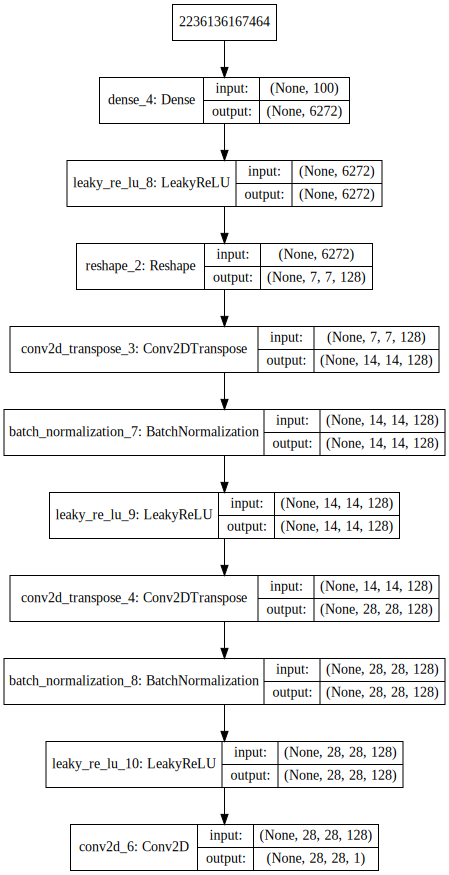

In [13]:
fashion_wgan.plot_generator()

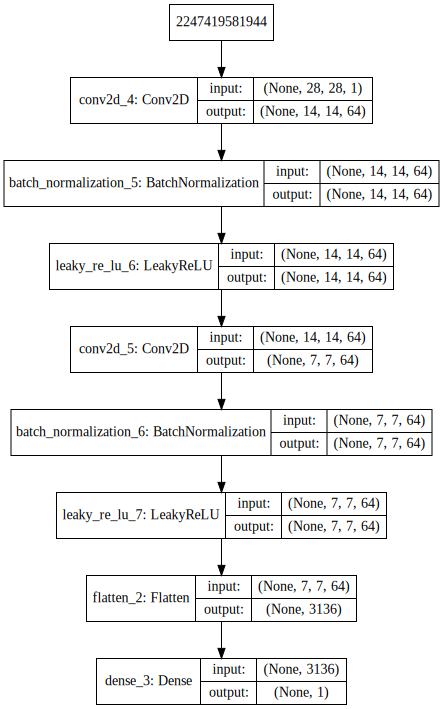

In [14]:
fashion_wgan.plot_discriminator()

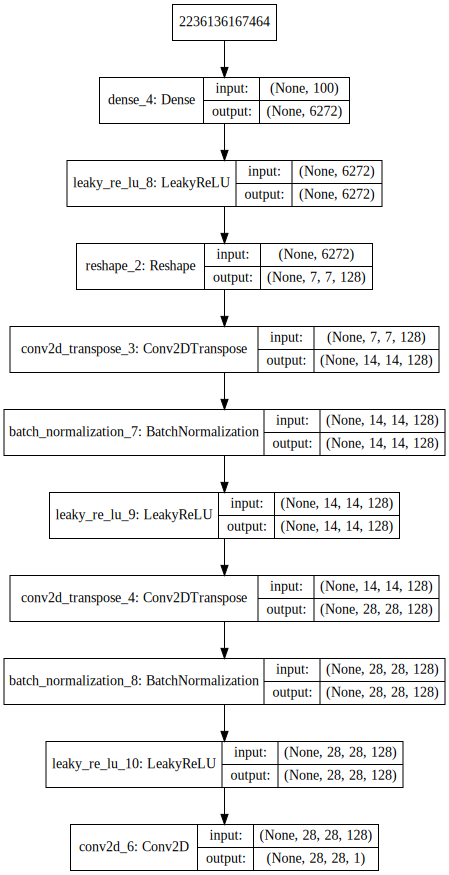

In [15]:
fashion_wgan.plot_gan()

## Train the model

C:\applications\Miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/468, d1=-0.888, d2=-0.096 g=0.907
>1, 2/468, d1=-4.041, d2=-0.343 g=1.236
>1, 3/468, d1=-5.662, d2=0.068 g=0.626


C:\applications\Miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 4/468, d1=-6.643, d2=0.740 g=-0.286
>1, 5/468, d1=-7.302, d2=1.330 g=-1.034
>1, 6/468, d1=-7.984, d2=1.579 g=-1.808
>1, 7/468, d1=-8.590, d2=1.607 g=-2.185
>1, 8/468, d1=-9.168, d2=1.788 g=-2.879
>1, 9/468, d1=-9.802, d2=1.823 g=-3.155
>1, 10/468, d1=-10.176, d2=1.822 g=-3.397
>1, 11/468, d1=-10.527, d2=1.735 g=-3.669
>1, 12/468, d1=-10.864, d2=1.932 g=-3.866
>1, 13/468, d1=-11.123, d2=2.194 g=-4.479
>1, 14/468, d1=-11.283, d2=2.385 g=-4.927
>1, 15/468, d1=-11.525, d2=2.654 g=-5.089
>1, 16/468, d1=-11.949, d2=2.660 g=-5.033
>1, 17/468, d1=-12.056, d2=2.823 g=-4.729
>1, 18/468, d1=-11.949, d2=2.467 g=-4.175
>1, 19/468, d1=-12.190, d2=2.175 g=-3.121
>1, 20/468, d1=-12.412, d2=1.414 g=-1.574
>1, 21/468, d1=-12.391, d2=0.445 g=0.134
>1, 22/468, d1=-12.442, d2=-0.654 g=1.957
>1, 23/468, d1=-12.383, d2=-1.678 g=3.770
>1, 24/468, d1=-12.439, d2=-2.471 g=5.444
>1, 25/468, d1=-12.665, d2=-2.770 g=6.573
>1, 26/468, d1=-12.487, d2=-2.942 g=7.532
>1, 27/468, d1=-12.094, d2=-2.597 g=7.948
>1, 2

>1, 195/468, d1=-11.984, d2=-6.112 g=11.722
>1, 196/468, d1=-14.722, d2=-7.119 g=12.711
>1, 197/468, d1=-14.709, d2=-9.687 g=14.938
>1, 198/468, d1=-14.820, d2=-7.032 g=16.842
>1, 199/468, d1=-15.919, d2=-7.667 g=18.776
>1, 200/468, d1=-14.376, d2=-10.107 g=21.241
>1, 201/468, d1=-14.858, d2=-5.937 g=20.120
>1, 202/468, d1=-13.394, d2=-7.176 g=19.057
>1, 203/468, d1=-9.975, d2=-7.737 g=18.230
>1, 204/468, d1=-9.357, d2=-8.603 g=18.774
>1, 205/468, d1=-9.020, d2=-8.560 g=17.759
>1, 206/468, d1=-7.720, d2=-9.426 g=16.243
>1, 207/468, d1=-8.451, d2=-10.189 g=15.236
>1, 208/468, d1=-8.342, d2=-13.214 g=17.363
>1, 209/468, d1=-9.376, d2=-12.945 g=18.915
>1, 210/468, d1=-9.474, d2=-14.157 g=18.528
>1, 211/468, d1=-12.126, d2=-13.886 g=20.374
>1, 212/468, d1=-12.648, d2=-19.576 g=25.453
>1, 213/468, d1=-15.863, d2=-21.114 g=27.137
>1, 214/468, d1=-14.710, d2=-23.025 g=30.580
>1, 215/468, d1=-19.383, d2=-27.119 g=35.035
>1, 216/468, d1=-19.298, d2=-23.764 g=34.433
>1, 217/468, d1=-17.047, d2=-

>1, 380/468, d1=-90.443, d2=-103.450 g=109.266
>1, 381/468, d1=-96.321, d2=-106.238 g=113.850
>1, 382/468, d1=-98.726, d2=-107.843 g=117.347
>1, 383/468, d1=-94.889, d2=-106.749 g=114.907
>1, 384/468, d1=-93.714, d2=-101.992 g=114.503
>1, 385/468, d1=-101.416, d2=-107.718 g=119.678
>1, 386/468, d1=-96.133, d2=-104.339 g=118.899
>1, 387/468, d1=-95.809, d2=-97.427 g=110.764
>1, 388/468, d1=-97.693, d2=-103.412 g=114.865
>1, 389/468, d1=-97.914, d2=-100.289 g=114.861
>1, 390/468, d1=-93.520, d2=-103.772 g=115.866
>1, 391/468, d1=-94.440, d2=-53.377 g=96.825
>1, 392/468, d1=-91.020, d2=-74.650 g=103.682
>1, 393/468, d1=-95.478, d2=-84.260 g=103.768
>1, 394/468, d1=-90.681, d2=-69.741 g=98.091
>1, 395/468, d1=-87.111, d2=-63.369 g=92.228
>1, 396/468, d1=-88.485, d2=-47.799 g=79.538
>1, 397/468, d1=-90.929, d2=-58.566 g=86.897
>1, 398/468, d1=-89.699, d2=-64.896 g=85.788
>1, 399/468, d1=-94.498, d2=-76.725 g=88.120
>1, 400/468, d1=-97.422, d2=-84.824 g=99.441
>1, 401/468, d1=-101.175, d2=-9

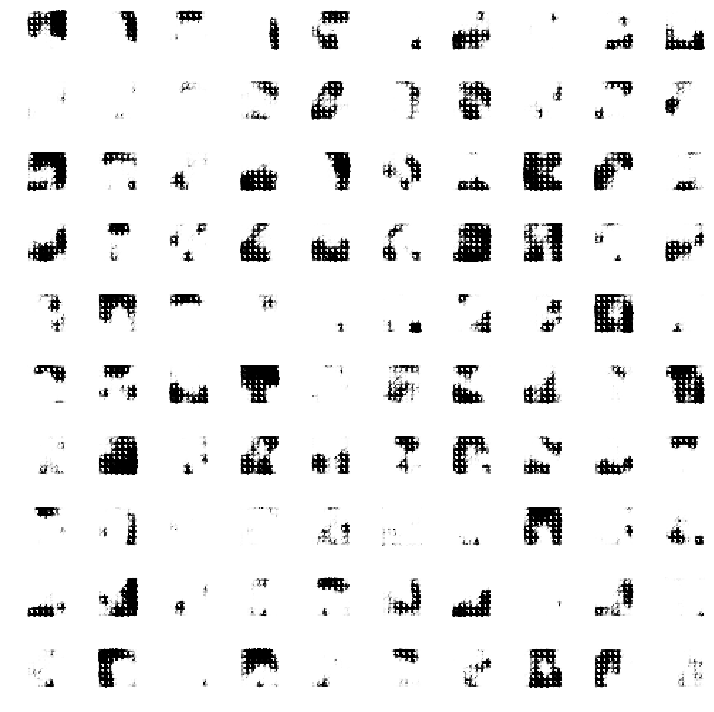

>Saved: generated_plot_0002.png and model_0002.h5
>2, 1/468, d1=-133.274, d2=-140.649 g=151.380
>2, 2/468, d1=-142.777, d2=-139.382 g=148.443
>2, 3/468, d1=-136.025, d2=-138.974 g=149.734
>2, 4/468, d1=-141.293, d2=-142.382 g=150.282
>2, 5/468, d1=-143.674, d2=-141.514 g=145.490
>2, 6/468, d1=-144.493, d2=-142.957 g=144.618
>2, 7/468, d1=-142.189, d2=-136.756 g=137.394
>2, 8/468, d1=-144.947, d2=-151.124 g=159.635
>2, 9/468, d1=-138.999, d2=-141.715 g=155.091
>2, 10/468, d1=-148.165, d2=-135.257 g=143.544
>2, 11/468, d1=-141.399, d2=-140.714 g=155.828
>2, 12/468, d1=-137.915, d2=-137.559 g=154.819
>2, 13/468, d1=-138.094, d2=-145.515 g=158.252
>2, 14/468, d1=-140.922, d2=-139.613 g=144.136
>2, 15/468, d1=-143.422, d2=-145.175 g=160.894
>2, 16/468, d1=-139.648, d2=-139.217 g=146.490
>2, 17/468, d1=-141.751, d2=-155.507 g=164.109
>2, 18/468, d1=-147.361, d2=-146.964 g=159.649
>2, 19/468, d1=-148.893, d2=-147.922 g=146.296
>2, 20/468, d1=-148.031, d2=-156.170 g=166.771
>2, 21/468, d1=-140

>2, 173/468, d1=-239.980, d2=-236.826 g=236.850
>2, 174/468, d1=-220.595, d2=-244.425 g=250.754
>2, 175/468, d1=-235.454, d2=-245.253 g=260.618
>2, 176/468, d1=-236.376, d2=-227.270 g=243.373
>2, 177/468, d1=-231.026, d2=-238.655 g=264.489
>2, 178/468, d1=-222.928, d2=-237.033 g=257.066
>2, 179/468, d1=-228.158, d2=-219.782 g=217.501
>2, 180/468, d1=-237.026, d2=-248.612 g=262.804
>2, 181/468, d1=-242.997, d2=-216.081 g=255.493
>2, 182/468, d1=-249.060, d2=-245.107 g=261.198
>2, 183/468, d1=-231.894, d2=-190.756 g=226.527
>2, 184/468, d1=-221.833, d2=-223.641 g=245.785
>2, 185/468, d1=-237.411, d2=-210.447 g=245.098
>2, 186/468, d1=-226.634, d2=-236.387 g=258.636
>2, 187/468, d1=-251.042, d2=-231.250 g=253.097
>2, 188/468, d1=-230.011, d2=-245.745 g=257.863
>2, 189/468, d1=-239.289, d2=-218.886 g=238.649
>2, 190/468, d1=-248.040, d2=-242.609 g=255.888
>2, 191/468, d1=-231.692, d2=-227.860 g=246.089
>2, 192/468, d1=-242.676, d2=-237.548 g=258.817
>2, 193/468, d1=-236.966, d2=-185.934 g=

>2, 344/468, d1=-320.848, d2=-323.000 g=360.581
>2, 345/468, d1=-349.640, d2=-336.730 g=324.095
>2, 346/468, d1=-329.477, d2=-351.167 g=370.612
>2, 347/468, d1=-331.612, d2=-316.591 g=350.071
>2, 348/468, d1=-335.477, d2=-330.475 g=301.766
>2, 349/468, d1=-315.571, d2=-321.385 g=365.798
>2, 350/468, d1=-353.307, d2=-334.585 g=344.030
>2, 351/468, d1=-337.571, d2=-349.565 g=368.668
>2, 352/468, d1=-334.819, d2=-319.705 g=338.004
>2, 353/468, d1=-347.552, d2=-342.690 g=367.068
>2, 354/468, d1=-322.327, d2=-299.380 g=309.134
>2, 355/468, d1=-330.246, d2=-342.922 g=358.956
>2, 356/468, d1=-338.379, d2=-293.214 g=326.481
>2, 357/468, d1=-339.494, d2=-363.664 g=364.456
>2, 358/468, d1=-360.405, d2=-326.160 g=346.989
>2, 359/468, d1=-349.120, d2=-363.190 g=371.576
>2, 360/468, d1=-357.147, d2=-353.944 g=373.013
>2, 361/468, d1=-339.849, d2=-291.992 g=261.204
>2, 362/468, d1=-326.317, d2=-294.056 g=366.914
>2, 363/468, d1=-333.964, d2=-326.823 g=361.274
>2, 364/468, d1=-307.588, d2=-300.513 g=

>3, 49/468, d1=-406.716, d2=-352.430 g=428.078
>3, 50/468, d1=-380.884, d2=-371.187 g=355.292
>3, 51/468, d1=-365.665, d2=-359.908 g=449.016
>3, 52/468, d1=-380.441, d2=-381.432 g=467.676
>3, 53/468, d1=-384.433, d2=-374.065 g=452.077
>3, 54/468, d1=-369.959, d2=-323.167 g=396.349
>3, 55/468, d1=-382.975, d2=-350.774 g=428.182
>3, 56/468, d1=-379.975, d2=-333.649 g=337.567
>3, 57/468, d1=-358.631, d2=-376.777 g=410.650
>3, 58/468, d1=-392.050, d2=-342.765 g=419.475
>3, 59/468, d1=-373.759, d2=-365.214 g=433.973
>3, 60/468, d1=-391.257, d2=-345.832 g=389.475
>3, 61/468, d1=-371.802, d2=-424.755 g=403.855
>3, 62/468, d1=-369.120, d2=-410.577 g=449.332
>3, 63/468, d1=-400.339, d2=-416.831 g=436.289
>3, 64/468, d1=-372.151, d2=-426.263 g=479.802
>3, 65/468, d1=-413.507, d2=-407.765 g=486.140
>3, 66/468, d1=-390.075, d2=-363.135 g=433.093
>3, 67/468, d1=-394.725, d2=-454.179 g=444.091
>3, 68/468, d1=-398.103, d2=-450.935 g=422.116
>3, 69/468, d1=-367.330, d2=-408.034 g=473.488
>3, 70/468, d

>3, 223/468, d1=-407.542, d2=-474.615 g=407.720
>3, 224/468, d1=-379.491, d2=-495.789 g=591.011
>3, 225/468, d1=-428.451, d2=-553.263 g=595.947
>3, 226/468, d1=-427.323, d2=-429.924 g=508.148
>3, 227/468, d1=-457.575, d2=-524.565 g=595.554
>3, 228/468, d1=-444.956, d2=-526.152 g=545.009
>3, 229/468, d1=-468.405, d2=-561.871 g=608.065
>3, 230/468, d1=-448.501, d2=-487.575 g=575.795
>3, 231/468, d1=-408.514, d2=-518.847 g=395.737
>3, 232/468, d1=-440.102, d2=-551.489 g=572.218
>3, 233/468, d1=-458.438, d2=-474.742 g=443.640
>3, 234/468, d1=-386.823, d2=-495.420 g=440.337
>3, 235/468, d1=-370.717, d2=-521.202 g=465.947
>3, 236/468, d1=-389.192, d2=-514.445 g=554.980
>3, 237/468, d1=-451.589, d2=-528.204 g=604.963
>3, 238/468, d1=-377.828, d2=-462.879 g=613.090
>3, 239/468, d1=-419.268, d2=-467.445 g=590.215
>3, 240/468, d1=-461.888, d2=-449.777 g=465.005
>3, 241/468, d1=-420.131, d2=-459.647 g=564.888
>3, 242/468, d1=-452.406, d2=-482.803 g=513.088
>3, 243/468, d1=-424.102, d2=-515.123 g=

>3, 394/468, d1=-562.463, d2=-649.171 g=762.655
>3, 395/468, d1=-525.143, d2=-567.761 g=629.932
>3, 396/468, d1=-515.447, d2=-611.328 g=692.601
>3, 397/468, d1=-566.931, d2=-670.494 g=747.609
>3, 398/468, d1=-531.398, d2=-649.818 g=700.177
>3, 399/468, d1=-506.177, d2=-544.996 g=619.353
>3, 400/468, d1=-529.125, d2=-637.836 g=748.461
>3, 401/468, d1=-572.666, d2=-551.952 g=719.567
>3, 402/468, d1=-582.513, d2=-624.983 g=664.504
>3, 403/468, d1=-559.024, d2=-633.316 g=692.962
>3, 404/468, d1=-581.183, d2=-525.957 g=661.985
>3, 405/468, d1=-608.470, d2=-661.168 g=531.916
>3, 406/468, d1=-531.127, d2=-672.995 g=747.120
>3, 407/468, d1=-530.719, d2=-552.806 g=724.215
>3, 408/468, d1=-545.054, d2=-553.434 g=741.794
>3, 409/468, d1=-605.358, d2=-681.198 g=756.880
>3, 410/468, d1=-601.923, d2=-672.083 g=662.922
>3, 411/468, d1=-568.144, d2=-697.133 g=630.068
>3, 412/468, d1=-553.258, d2=-681.851 g=714.887
>3, 413/468, d1=-553.928, d2=-648.639 g=753.986
>3, 414/468, d1=-553.008, d2=-603.579 g=

>4, 100/468, d1=-636.265, d2=-692.513 g=717.312
>4, 101/468, d1=-588.748, d2=-699.041 g=731.581
>4, 102/468, d1=-655.372, d2=-612.079 g=764.087
>4, 103/468, d1=-605.257, d2=-659.521 g=748.846
>4, 104/468, d1=-567.132, d2=-748.568 g=829.947
>4, 105/468, d1=-607.247, d2=-775.927 g=862.162
>4, 106/468, d1=-639.267, d2=-707.601 g=843.895
>4, 107/468, d1=-545.595, d2=-663.692 g=783.033
>4, 108/468, d1=-589.698, d2=-830.032 g=575.453
>4, 109/468, d1=-656.348, d2=-676.037 g=773.916
>4, 110/468, d1=-498.781, d2=-649.288 g=820.905
>4, 111/468, d1=-526.705, d2=-633.484 g=804.774
>4, 112/468, d1=-486.392, d2=-655.758 g=790.060
>4, 113/468, d1=-526.574, d2=-605.041 g=768.879
>4, 114/468, d1=-569.239, d2=-602.911 g=755.612
>4, 115/468, d1=-541.229, d2=-631.695 g=694.029
>4, 116/468, d1=-594.289, d2=-749.100 g=786.548
>4, 117/468, d1=-569.988, d2=-643.733 g=768.772
>4, 118/468, d1=-557.523, d2=-768.017 g=853.698
>4, 119/468, d1=-573.460, d2=-760.175 g=804.095
>4, 120/468, d1=-583.300, d2=-748.567 g=

>4, 265/468, d1=-1526.173, d2=-1383.440 g=-714.933
>4, 266/468, d1=-1535.021, d2=-1384.121 g=-607.803
>4, 267/468, d1=-1527.610, d2=-1377.582 g=-543.511
>4, 268/468, d1=-1543.561, d2=-1385.593 g=-429.609
>4, 269/468, d1=-1542.276, d2=-1393.408 g=-259.008
>4, 270/468, d1=-1545.193, d2=-1398.651 g=-207.470
>4, 271/468, d1=-1550.609, d2=-1402.531 g=58.032
>4, 272/468, d1=-1557.434, d2=-1414.126 g=189.231
>4, 273/468, d1=-1556.618, d2=-1423.179 g=332.206
>4, 274/468, d1=-1560.520, d2=-1428.754 g=440.408
>4, 275/468, d1=-1572.878, d2=-1436.316 g=645.735
>4, 276/468, d1=-1572.740, d2=-1438.640 g=765.771
>4, 277/468, d1=-1583.645, d2=-1450.377 g=865.580
>4, 278/468, d1=-1589.492, d2=-1466.189 g=1068.568
>4, 279/468, d1=-1593.537, d2=-1471.166 g=1068.543
>4, 280/468, d1=-1598.344, d2=-1480.187 g=1088.594
>4, 281/468, d1=-1611.275, d2=-1498.849 g=1067.091
>4, 282/468, d1=-1613.654, d2=-1470.775 g=1097.797
>4, 283/468, d1=-1617.856, d2=-1506.266 g=965.723
>4, 284/468, d1=-1614.094, d2=-1470.281 

>4, 427/468, d1=-2016.380, d2=-1804.517 g=1806.098
>4, 428/468, d1=-2022.032, d2=-1806.457 g=1808.281
>4, 429/468, d1=-2015.172, d2=-1807.694 g=1810.309
>4, 430/468, d1=-2025.051, d2=-1809.255 g=1812.195
>4, 431/468, d1=-2029.130, d2=-1811.304 g=1814.204
>4, 432/468, d1=-2022.488, d2=-1811.664 g=1815.823
>4, 433/468, d1=-2030.770, d2=-1812.462 g=1816.400
>4, 434/468, d1=-2035.002, d2=-1815.813 g=1818.151
>4, 435/468, d1=-2031.310, d2=-1818.520 g=1820.417
>4, 436/468, d1=-2040.100, d2=-1820.598 g=1822.563
>4, 437/468, d1=-2039.188, d2=-1822.895 g=1824.665
>4, 438/468, d1=-2036.119, d2=-1824.749 g=1826.650
>4, 439/468, d1=-2045.588, d2=-1827.426 g=1828.778
>4, 440/468, d1=-2043.573, d2=-1829.390 g=1830.641
>4, 441/468, d1=-2047.191, d2=-1831.985 g=1833.123
>4, 442/468, d1=-2046.869, d2=-1833.944 g=1835.074
>4, 443/468, d1=-2054.235, d2=-1836.273 g=1837.548
>4, 444/468, d1=-2054.236, d2=-1838.424 g=1840.092
>4, 445/468, d1=-2059.108, d2=-1840.837 g=1841.883
>4, 446/468, d1=-2055.267, d2=-

>5, 124/468, d1=-1674.083, d2=-493.900 g=929.524
>5, 125/468, d1=-1625.858, d2=-642.894 g=946.213
>5, 126/468, d1=-1583.225, d2=-850.407 g=920.208
>5, 127/468, d1=-1495.876, d2=-1011.904 g=974.226
>5, 128/468, d1=-1471.302, d2=-1088.748 g=929.964
>5, 129/468, d1=-1521.614, d2=-1181.289 g=903.107
>5, 130/468, d1=-1485.401, d2=-1217.361 g=839.508
>5, 131/468, d1=-1472.925, d2=-1201.878 g=706.931
>5, 132/468, d1=-1510.858, d2=-1272.818 g=658.910
>5, 133/468, d1=-1553.046, d2=-1306.878 g=582.765
>5, 134/468, d1=-1529.310, d2=-1151.427 g=603.837
>5, 135/468, d1=-1550.637, d2=-1191.457 g=607.110
>5, 136/468, d1=-1605.978, d2=-1154.050 g=631.756
>5, 137/468, d1=-1619.101, d2=-1212.808 g=598.264
>5, 138/468, d1=-1625.544, d2=-1176.898 g=623.183
>5, 139/468, d1=-1660.846, d2=-1125.605 g=603.805
>5, 140/468, d1=-1661.670, d2=-1030.384 g=518.517
>5, 141/468, d1=-1591.514, d2=-870.904 g=428.872
>5, 142/468, d1=-1658.911, d2=-817.717 g=292.122
>5, 143/468, d1=-1592.320, d2=-520.276 g=77.212
>5, 144

>5, 296/468, d1=-358.765, d2=-275.292 g=643.518
>5, 297/468, d1=-382.175, d2=-151.820 g=388.051
>5, 298/468, d1=-408.063, d2=-209.753 g=646.784
>5, 299/468, d1=-371.161, d2=-230.885 g=545.370
>5, 300/468, d1=-321.676, d2=-180.953 g=491.167
>5, 301/468, d1=-389.759, d2=-88.526 g=488.486
>5, 302/468, d1=-296.872, d2=-123.676 g=477.840
>5, 303/468, d1=-331.295, d2=-113.525 g=405.065
>5, 304/468, d1=-423.122, d2=-166.767 g=434.491
>5, 305/468, d1=-341.567, d2=-343.825 g=663.222
>5, 306/468, d1=-324.007, d2=-369.437 g=731.893
>5, 307/468, d1=-302.838, d2=-234.879 g=498.308
>5, 308/468, d1=-289.502, d2=-178.017 g=595.505
>5, 309/468, d1=-310.126, d2=-71.774 g=361.644
>5, 310/468, d1=-373.967, d2=-166.680 g=604.894
>5, 311/468, d1=-297.394, d2=-221.951 g=651.707
>5, 312/468, d1=-370.493, d2=-256.991 g=605.940
>5, 313/468, d1=-331.785, d2=-367.355 g=688.250
>5, 314/468, d1=-261.220, d2=-334.578 g=592.479
>5, 315/468, d1=-259.640, d2=-394.271 g=732.991
>5, 316/468, d1=-399.189, d2=-304.060 g=65

>5, 462/468, d1=-1558.983, d2=1449.809 g=-1282.313
>5, 463/468, d1=-1560.760, d2=1448.179 g=-1329.478
>5, 464/468, d1=-1564.328, d2=1453.198 g=-1303.929
>5, 465/468, d1=-1566.699, d2=1458.100 g=-1290.658
>5, 466/468, d1=-1536.206, d2=1436.992 g=-1281.274
>5, 467/468, d1=-1546.991, d2=1433.886 g=-1259.140
>5, 468/468, d1=-1552.941, d2=1446.173 g=-1296.508


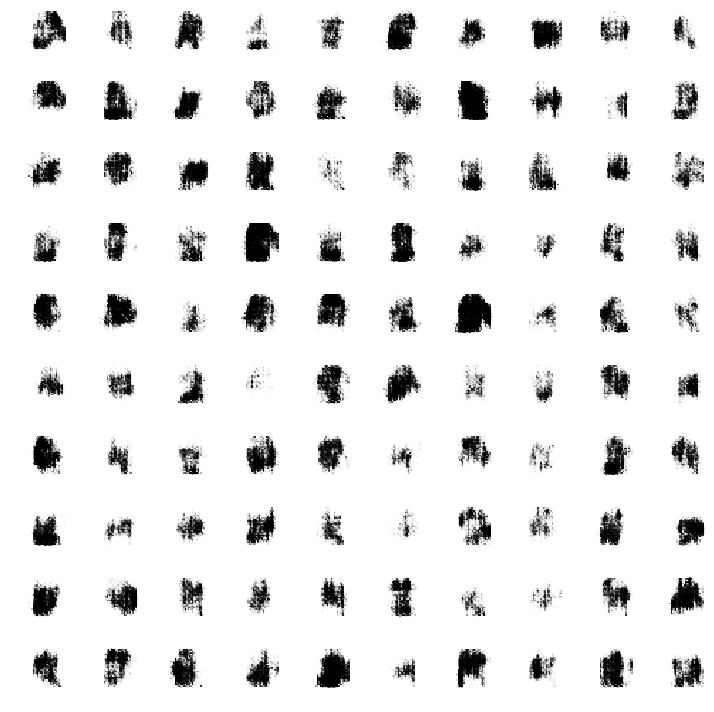

>Saved: generated_plot_0006.png and model_0006.h5
>6, 1/468, d1=-1567.585, d2=1452.417 g=-1331.731
>6, 2/468, d1=-1559.617, d2=1450.730 g=-1356.840
>6, 3/468, d1=-1583.338, d2=1435.875 g=-1306.014
>6, 4/468, d1=-1557.294, d2=1401.147 g=-1287.993
>6, 5/468, d1=-1555.907, d2=1399.813 g=-1257.130
>6, 6/468, d1=-1553.542, d2=1415.222 g=-1317.470
>6, 7/468, d1=-1583.758, d2=1411.707 g=-1232.945
>6, 8/468, d1=-1562.294, d2=1376.916 g=-1257.695
>6, 9/468, d1=-1534.457, d2=1384.889 g=-1247.106
>6, 10/468, d1=-1579.455, d2=1372.090 g=-1245.233
>6, 11/468, d1=-1551.023, d2=1387.923 g=-1218.831
>6, 12/468, d1=-1545.664, d2=1352.595 g=-1255.350
>6, 13/468, d1=-1526.952, d2=1388.855 g=-1235.732
>6, 14/468, d1=-1561.369, d2=1364.189 g=-1234.390
>6, 15/468, d1=-1548.109, d2=1391.951 g=-1243.253
>6, 16/468, d1=-1573.587, d2=1362.126 g=-1266.408
>6, 17/468, d1=-1534.251, d2=1364.989 g=-1261.141
>6, 18/468, d1=-1547.668, d2=1345.482 g=-1231.186
>6, 19/468, d1=-1523.327, d2=1370.107 g=-1240.361
>6, 20/46

>6, 167/468, d1=-1504.778, d2=430.744 g=-315.199
>6, 168/468, d1=-1414.471, d2=832.742 g=-555.537
>6, 169/468, d1=-1427.294, d2=727.505 g=-540.441
>6, 170/468, d1=-1337.204, d2=930.215 g=-694.501
>6, 171/468, d1=-1431.077, d2=518.124 g=-459.273
>6, 172/468, d1=-1436.870, d2=1211.035 g=-1091.864
>6, 173/468, d1=-1450.803, d2=975.466 g=-732.292
>6, 174/468, d1=-1446.446, d2=449.041 g=-346.957
>6, 175/468, d1=-1477.027, d2=957.401 g=-637.137
>6, 176/468, d1=-1397.817, d2=600.643 g=-437.577
>6, 177/468, d1=-1390.621, d2=1088.679 g=-854.921
>6, 178/468, d1=-1444.850, d2=354.293 g=-302.864
>6, 179/468, d1=-1425.440, d2=900.460 g=-616.711
>6, 180/468, d1=-1383.323, d2=529.772 g=-429.320
>6, 181/468, d1=-1466.701, d2=1180.456 g=-915.422
>6, 182/468, d1=-1435.791, d2=369.990 g=-299.128
>6, 183/468, d1=-1465.799, d2=1021.624 g=-705.539
>6, 184/468, d1=-1467.581, d2=495.119 g=-388.270
>6, 185/468, d1=-1452.551, d2=1091.028 g=-998.683
>6, 186/468, d1=-1428.524, d2=603.181 g=-406.643
>6, 187/468, d

>6, 333/468, d1=-1411.476, d2=1202.746 g=-1091.179
>6, 334/468, d1=-1262.839, d2=835.073 g=-561.163
>6, 335/468, d1=-1388.607, d2=336.794 g=-265.414
>6, 336/468, d1=-1428.958, d2=783.973 g=-539.468
>6, 337/468, d1=-1350.678, d2=679.852 g=-436.784
>6, 338/468, d1=-1366.739, d2=683.679 g=-487.637
>6, 339/468, d1=-1288.051, d2=944.115 g=-704.611
>6, 340/468, d1=-1428.863, d2=339.782 g=-301.630
>6, 341/468, d1=-1483.497, d2=777.972 g=-567.035
>6, 342/468, d1=-1336.641, d2=844.890 g=-549.276
>6, 343/468, d1=-1382.035, d2=481.302 g=-382.236
>6, 344/468, d1=-1366.513, d2=1153.611 g=-1003.000
>6, 345/468, d1=-1351.797, d2=1106.038 g=-847.026
>6, 346/468, d1=-1427.079, d2=343.055 g=-277.763
>6, 347/468, d1=-1435.414, d2=831.375 g=-503.883
>6, 348/468, d1=-1273.699, d2=825.289 g=-537.586
>6, 349/468, d1=-1405.873, d2=531.486 g=-391.108
>6, 350/468, d1=-1413.448, d2=1206.729 g=-1056.324
>6, 351/468, d1=-1279.848, d2=1009.061 g=-794.306
>6, 352/468, d1=-1402.796, d2=216.026 g=-179.235
>6, 353/468,

>7, 33/468, d1=-1309.963, d2=401.933 g=-257.543
>7, 34/468, d1=-1271.326, d2=860.110 g=-549.285
>7, 35/468, d1=-1260.832, d2=317.911 g=-211.035
>7, 36/468, d1=-1288.615, d2=974.489 g=-635.442
>7, 37/468, d1=-1348.991, d2=177.934 g=-77.897
>7, 38/468, d1=-1241.077, d2=951.554 g=-741.954
>7, 39/468, d1=-1327.198, d2=286.729 g=-209.786
>7, 40/468, d1=-1399.001, d2=607.906 g=-377.613
>7, 41/468, d1=-1336.609, d2=1122.001 g=-864.995
>7, 42/468, d1=-1327.043, d2=464.421 g=-331.653
>7, 43/468, d1=-1329.042, d2=1164.834 g=-982.833
>7, 44/468, d1=-1302.498, d2=1084.075 g=-919.503
>7, 45/468, d1=-1280.789, d2=334.531 g=-148.867
>7, 46/468, d1=-1288.652, d2=1028.524 g=-805.287
>7, 47/468, d1=-1269.772, d2=155.308 g=-62.614
>7, 48/468, d1=-1224.883, d2=885.580 g=-574.203
>7, 49/468, d1=-1315.858, d2=255.797 g=-202.638
>7, 50/468, d1=-1439.077, d2=531.081 g=-361.972
>7, 51/468, d1=-1362.553, d2=1225.972 g=-1063.544
>7, 52/468, d1=-1301.873, d2=997.096 g=-684.748
>7, 53/468, d1=-1293.537, d2=182.266

>7, 203/468, d1=-1360.418, d2=758.543 g=-493.507
>7, 204/468, d1=-1302.042, d2=455.752 g=-181.445
>7, 205/468, d1=-1273.199, d2=1003.133 g=-735.641
>7, 206/468, d1=-1251.908, d2=269.329 g=-112.021
>7, 207/468, d1=-1222.816, d2=981.042 g=-689.705
>7, 208/468, d1=-1285.263, d2=395.395 g=-248.404
>7, 209/468, d1=-1363.912, d2=931.491 g=-616.855
>7, 210/468, d1=-1280.303, d2=266.188 g=-127.477
>7, 211/468, d1=-1262.700, d2=1007.738 g=-700.761
>7, 212/468, d1=-1324.705, d2=372.373 g=-218.020
>7, 213/468, d1=-1278.849, d2=918.741 g=-547.336
>7, 214/468, d1=-1245.107, d2=298.603 g=-191.355
>7, 215/468, d1=-1317.487, d2=1122.831 g=-946.327
>7, 216/468, d1=-1291.227, d2=965.375 g=-688.519
>7, 217/468, d1=-1309.639, d2=205.436 g=-90.015
>7, 218/468, d1=-1246.173, d2=885.481 g=-567.482
>7, 219/468, d1=-1295.635, d2=308.803 g=-221.556
>7, 220/468, d1=-1363.082, d2=694.963 g=-482.587
>7, 221/468, d1=-1269.167, d2=746.429 g=-422.501
>7, 222/468, d1=-1291.333, d2=540.192 g=-318.041
>7, 223/468, d1=-1

>7, 370/468, d1=-1274.783, d2=351.318 g=-208.749
>7, 371/468, d1=-1331.672, d2=938.287 g=-636.640
>7, 372/468, d1=-1378.397, d2=242.945 g=-109.241
>7, 373/468, d1=-1301.049, d2=1020.451 g=-809.331
>7, 374/468, d1=-1291.086, d2=552.199 g=-336.199
>7, 375/468, d1=-1315.193, d2=813.110 g=-510.496
>7, 376/468, d1=-1355.032, d2=253.177 g=-183.898
>7, 377/468, d1=-1386.135, d2=644.273 g=-416.045
>7, 378/468, d1=-1357.173, d2=587.180 g=-292.888
>7, 379/468, d1=-1365.990, d2=577.715 g=-356.045
>7, 380/468, d1=-1302.701, d2=745.261 g=-471.795
>7, 381/468, d1=-1338.540, d2=348.374 g=-254.904
>7, 382/468, d1=-1326.083, d2=1011.180 g=-730.947
>7, 383/468, d1=-1326.143, d2=277.444 g=-151.512
>7, 384/468, d1=-1246.373, d2=967.513 g=-740.812
>7, 385/468, d1=-1348.778, d2=433.396 g=-263.384
>7, 386/468, d1=-1350.180, d2=1055.248 g=-828.119
>7, 387/468, d1=-1327.732, d2=636.061 g=-435.174
>7, 388/468, d1=-1305.373, d2=376.224 g=-192.481
>7, 389/468, d1=-1258.977, d2=883.383 g=-581.401
>7, 390/468, d1=-

>8, 71/468, d1=-1081.930, d2=645.303 g=-371.645
>8, 72/468, d1=-1052.183, d2=615.505 g=-279.093
>8, 73/468, d1=-1018.470, d2=543.523 g=-291.018
>8, 74/468, d1=-1002.555, d2=572.318 g=-194.930
>8, 75/468, d1=-963.329, d2=543.031 g=-297.606
>8, 76/468, d1=-973.377, d2=500.200 g=-251.710
>8, 77/468, d1=-1012.745, d2=505.391 g=-241.198
>8, 78/468, d1=-1079.165, d2=629.797 g=-353.546
>8, 79/468, d1=-1047.889, d2=473.370 g=-284.733
>8, 80/468, d1=-1102.448, d2=584.508 g=-272.461
>8, 81/468, d1=-1040.136, d2=519.167 g=-304.448
>8, 82/468, d1=-1073.696, d2=614.665 g=-374.745
>8, 83/468, d1=-1092.062, d2=451.188 g=-284.855
>8, 84/468, d1=-1123.188, d2=817.365 g=-545.531
>8, 85/468, d1=-1185.328, d2=386.859 g=-262.151
>8, 86/468, d1=-1176.661, d2=941.360 g=-770.080
>8, 87/468, d1=-1122.139, d2=831.885 g=-658.335
>8, 88/468, d1=-1207.745, d2=328.780 g=-118.827
>8, 89/468, d1=-1271.048, d2=984.449 g=-858.057
>8, 90/468, d1=-1271.393, d2=643.960 g=-470.224
>8, 91/468, d1=-1232.710, d2=469.441 g=-37

>8, 241/468, d1=-992.909, d2=532.427 g=-403.146
>8, 242/468, d1=-994.006, d2=598.744 g=-381.931
>8, 243/468, d1=-1057.433, d2=528.993 g=-312.272
>8, 244/468, d1=-1062.859, d2=606.329 g=-308.552
>8, 245/468, d1=-1076.791, d2=534.308 g=-412.463
>8, 246/468, d1=-1069.070, d2=682.092 g=-501.897
>8, 247/468, d1=-1096.310, d2=572.135 g=-351.213
>8, 248/468, d1=-1087.431, d2=575.835 g=-395.164
>8, 249/468, d1=-1065.137, d2=582.512 g=-430.069
>8, 250/468, d1=-1058.053, d2=644.663 g=-431.491
>8, 251/468, d1=-1059.953, d2=603.406 g=-393.403
>8, 252/468, d1=-1043.503, d2=620.769 g=-344.472
>8, 253/468, d1=-1020.379, d2=560.240 g=-341.581
>8, 254/468, d1=-1034.397, d2=612.073 g=-325.190
>8, 255/468, d1=-1040.366, d2=547.987 g=-395.065
>8, 256/468, d1=-1031.160, d2=607.685 g=-322.317
>8, 257/468, d1=-999.680, d2=543.832 g=-335.600
>8, 258/468, d1=-996.701, d2=571.624 g=-305.825
>8, 259/468, d1=-1007.376, d2=551.674 g=-356.326
>8, 260/468, d1=-1000.466, d2=564.289 g=-337.841
>8, 261/468, d1=-1005.64

>8, 410/468, d1=-1028.666, d2=593.095 g=-437.083
>8, 411/468, d1=-1050.648, d2=539.300 g=-510.542
>8, 412/468, d1=-1042.744, d2=620.771 g=-506.615
>8, 413/468, d1=-978.057, d2=567.821 g=-485.537
>8, 414/468, d1=-971.783, d2=575.376 g=-376.536
>8, 415/468, d1=-893.121, d2=522.920 g=-392.177
>8, 416/468, d1=-913.477, d2=493.818 g=-300.785
>8, 417/468, d1=-923.385, d2=474.724 g=-319.893
>8, 418/468, d1=-869.161, d2=420.582 g=-246.247
>8, 419/468, d1=-846.513, d2=365.357 g=-167.341
>8, 420/468, d1=-833.370, d2=366.388 g=-203.406
>8, 421/468, d1=-853.986, d2=306.487 g=-230.081
>8, 422/468, d1=-881.069, d2=270.044 g=-243.259
>8, 423/468, d1=-916.438, d2=332.452 g=-283.342
>8, 424/468, d1=-908.730, d2=375.934 g=-349.714
>8, 425/468, d1=-936.530, d2=369.605 g=-377.471
>8, 426/468, d1=-924.033, d2=476.713 g=-472.964
>8, 427/468, d1=-992.694, d2=481.843 g=-465.411
>8, 428/468, d1=-1005.234, d2=586.239 g=-493.561
>8, 429/468, d1=-1051.355, d2=613.576 g=-487.985
>8, 430/468, d1=-1089.600, d2=369.2

>9, 115/468, d1=-762.901, d2=-606.773 g=-465.196
>9, 116/468, d1=-950.171, d2=-643.157 g=-594.397
>9, 117/468, d1=-874.357, d2=-664.309 g=-833.744
>9, 118/468, d1=-1003.224, d2=-563.665 g=-865.586
>9, 119/468, d1=-995.109, d2=-518.495 g=-992.806
>9, 120/468, d1=-1010.475, d2=-394.786 g=-957.976
>9, 121/468, d1=-1045.538, d2=-381.501 g=-1011.259
>9, 122/468, d1=-1072.760, d2=-126.559 g=-922.787
>9, 123/468, d1=-1016.995, d2=-69.669 g=-1015.750
>9, 124/468, d1=-980.941, d2=105.988 g=-943.175
>9, 125/468, d1=-992.355, d2=263.731 g=-796.025
>9, 126/468, d1=-1002.977, d2=449.980 g=-783.044
>9, 127/468, d1=-1059.455, d2=628.477 g=-586.576
>9, 128/468, d1=-1127.663, d2=682.913 g=-481.340
>9, 129/468, d1=-1263.745, d2=683.924 g=-394.556
>9, 130/468, d1=-1239.493, d2=548.007 g=-341.891
>9, 131/468, d1=-1267.876, d2=371.736 g=-518.620
>9, 132/468, d1=-1283.009, d2=333.978 g=-762.652
>9, 133/468, d1=-1341.901, d2=285.427 g=-1038.530
>9, 134/468, d1=-1370.279, d2=248.951 g=-1189.528
>9, 135/468, d

>9, 282/468, d1=-577.142, d2=520.399 g=-412.350
>9, 283/468, d1=-673.813, d2=485.188 g=-114.700
>9, 284/468, d1=-600.977, d2=374.726 g=-52.266
>9, 285/468, d1=-545.090, d2=321.246 g=17.557
>9, 286/468, d1=-594.429, d2=240.829 g=238.713
>9, 287/468, d1=-605.479, d2=106.322 g=290.850
>9, 288/468, d1=-655.181, d2=7.079 g=256.059
>9, 289/468, d1=-790.533, d2=-158.140 g=18.863
>9, 290/468, d1=-899.527, d2=-282.610 g=-272.956
>9, 291/468, d1=-904.797, d2=-345.602 g=-714.857
>9, 292/468, d1=-1022.229, d2=-278.872 g=-792.268
>9, 293/468, d1=-1156.601, d2=-309.644 g=-1024.717
>9, 294/468, d1=-1147.702, d2=-340.050 g=-950.948
>9, 295/468, d1=-1289.817, d2=-205.097 g=-1002.374
>9, 296/468, d1=-1176.989, d2=-169.195 g=-1086.701
>9, 297/468, d1=-1179.400, d2=-280.167 g=-1001.199
>9, 298/468, d1=-1171.638, d2=-182.797 g=-989.146
>9, 299/468, d1=-1172.930, d2=-397.656 g=-1015.715
>9, 300/468, d1=-1114.745, d2=-110.993 g=-944.406
>9, 301/468, d1=-1121.104, d2=-41.848 g=-820.455
>9, 302/468, d1=-1131.3

>9, 448/468, d1=-1353.512, d2=-286.082 g=-1195.019
>9, 449/468, d1=-1282.283, d2=-510.987 g=-1275.288
>9, 450/468, d1=-1404.985, d2=-429.429 g=-1290.499
>9, 451/468, d1=-1255.404, d2=-64.410 g=-1208.927
>9, 452/468, d1=-1318.375, d2=-199.558 g=-1158.156
>9, 453/468, d1=-1322.831, d2=-164.450 g=-1080.464
>9, 454/468, d1=-1294.761, d2=-147.574 g=-1049.398
>9, 455/468, d1=-1204.786, d2=-186.095 g=-1036.212
>9, 456/468, d1=-1024.620, d2=296.409 g=-944.441
>9, 457/468, d1=-1188.327, d2=467.220 g=-830.461
>9, 458/468, d1=-969.151, d2=613.162 g=-708.411
>9, 459/468, d1=-1099.724, d2=950.570 g=-805.353
>9, 460/468, d1=-1299.651, d2=1102.989 g=-769.353
>9, 461/468, d1=-1383.873, d2=971.317 g=-849.217
>9, 462/468, d1=-1412.304, d2=784.427 g=-1040.398
>9, 463/468, d1=-1476.497, d2=535.774 g=-1259.860
>9, 464/468, d1=-1569.465, d2=175.630 g=-1384.094
>9, 465/468, d1=-1649.634, d2=-128.895 g=-1391.629
>9, 466/468, d1=-1675.714, d2=-326.931 g=-1247.921
>9, 467/468, d1=-1679.590, d2=-558.535 g=-1546.

>10, 144/468, d1=-1576.175, d2=-173.390 g=-1445.887
>10, 145/468, d1=-1603.425, d2=-12.827 g=-1442.372
>10, 146/468, d1=-1491.198, d2=246.079 g=-1336.574
>10, 147/468, d1=-1497.086, d2=400.406 g=-1236.686
>10, 148/468, d1=-1315.106, d2=181.375 g=-1230.329
>10, 149/468, d1=-1352.987, d2=522.714 g=-1169.308
>10, 150/468, d1=-1313.457, d2=632.397 g=-1028.519
>10, 151/468, d1=-1238.441, d2=685.840 g=-971.517
>10, 152/468, d1=-1333.425, d2=1009.682 g=-925.379
>10, 153/468, d1=-1452.192, d2=1219.861 g=-906.398
>10, 154/468, d1=-1492.097, d2=1203.675 g=-1027.417
>10, 155/468, d1=-1500.874, d2=937.787 g=-1066.492
>10, 156/468, d1=-1481.512, d2=625.704 g=-1216.451
>10, 157/468, d1=-1545.286, d2=-27.963 g=-1246.247
>10, 158/468, d1=-1601.281, d2=-114.808 g=-1410.818
>10, 159/468, d1=-1675.761, d2=-526.962 g=-1406.874
>10, 160/468, d1=-1760.564, d2=-641.929 g=-1467.978
>10, 161/468, d1=-1747.460, d2=-881.410 g=-1639.124
>10, 162/468, d1=-1774.764, d2=-915.447 g=-1544.325
>10, 163/468, d1=-1733.40

>10, 306/468, d1=-693.369, d2=865.549 g=-717.444
>10, 307/468, d1=-394.823, d2=759.678 g=-470.370
>10, 308/468, d1=-719.993, d2=717.458 g=-441.073
>10, 309/468, d1=-649.243, d2=672.613 g=-426.946
>10, 310/468, d1=-873.465, d2=666.842 g=-569.962
>10, 311/468, d1=-877.774, d2=554.031 g=-924.055
>10, 312/468, d1=-966.664, d2=572.650 g=-1206.219
>10, 313/468, d1=-1198.108, d2=517.378 g=-1303.283
>10, 314/468, d1=-1335.654, d2=482.113 g=-1551.215
>10, 315/468, d1=-1595.976, d2=485.204 g=-1768.225
>10, 316/468, d1=-1746.005, d2=392.036 g=-1860.341
>10, 317/468, d1=-1857.396, d2=258.689 g=-1819.450
>10, 318/468, d1=-1974.993, d2=137.623 g=-1824.112
>10, 319/468, d1=-1973.604, d2=117.229 g=-1812.549
>10, 320/468, d1=-1942.443, d2=56.832 g=-1812.814
>10, 321/468, d1=-1917.869, d2=-2.897 g=-1741.212
>10, 322/468, d1=-1986.542, d2=-76.388 g=-1763.891
>10, 323/468, d1=-1768.175, d2=-94.573 g=-1734.778
>10, 324/468, d1=-1755.111, d2=239.131 g=-1625.749
>10, 325/468, d1=-1748.071, d2=20.875 g=-1558.

>10, 467/468, d1=-514.127, d2=482.913 g=-876.953
>10, 468/468, d1=-701.745, d2=236.257 g=-1025.141


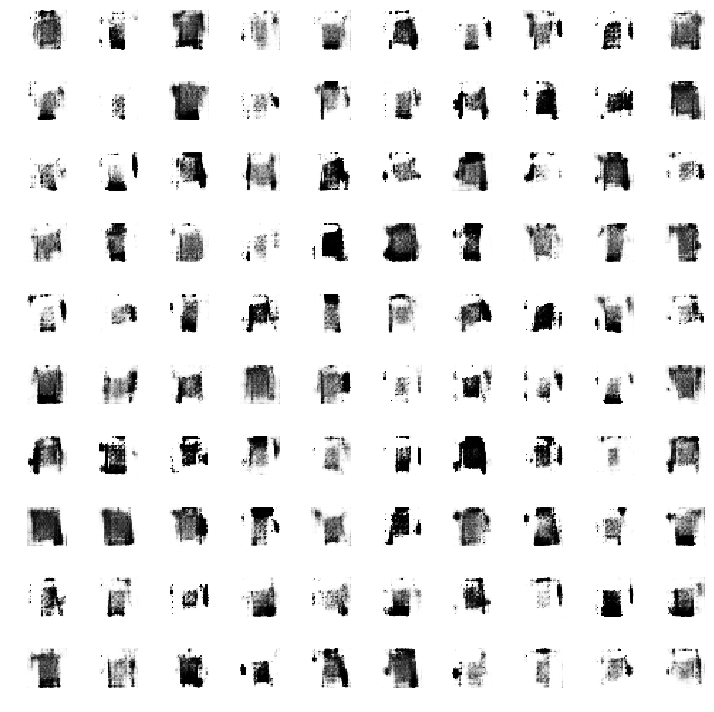

>Saved: generated_plot_0011.png and model_0011.h5
>11, 1/468, d1=-495.861, d2=446.827 g=-960.230
>11, 2/468, d1=-595.458, d2=501.977 g=-837.714
>11, 3/468, d1=-658.193, d2=396.822 g=-748.380
>11, 4/468, d1=-717.176, d2=271.337 g=-791.400
>11, 5/468, d1=-532.213, d2=252.450 g=-692.250
>11, 6/468, d1=-669.122, d2=234.800 g=-689.811
>11, 7/468, d1=-628.276, d2=105.345 g=-616.239
>11, 8/468, d1=-695.521, d2=63.551 g=-529.002
>11, 9/468, d1=-690.663, d2=-93.364 g=-589.227
>11, 10/468, d1=-774.438, d2=-125.588 g=-647.421
>11, 11/468, d1=-850.930, d2=-228.170 g=-605.468
>11, 12/468, d1=-830.903, d2=-226.700 g=-553.495
>11, 13/468, d1=-913.334, d2=-276.762 g=-537.725
>11, 14/468, d1=-998.822, d2=-334.321 g=-377.327
>11, 15/468, d1=-1106.127, d2=-354.514 g=-247.879
>11, 16/468, d1=-1087.804, d2=-361.083 g=-98.961
>11, 17/468, d1=-1273.498, d2=-453.182 g=-84.445
>11, 18/468, d1=-1407.079, d2=-474.888 g=96.689
>11, 19/468, d1=-1490.797, d2=-540.661 g=273.285
>11, 20/468, d1=-1649.056, d2=-598.709

>11, 163/468, d1=-2138.365, d2=-1120.188 g=-1602.983
>11, 164/468, d1=-2197.790, d2=-1112.917 g=-1715.328
>11, 165/468, d1=-2240.575, d2=-1262.282 g=-1554.424
>11, 166/468, d1=-2004.908, d2=-1165.153 g=-1551.864
>11, 167/468, d1=-2130.921, d2=-1337.177 g=-1676.480
>11, 168/468, d1=-2132.097, d2=-1633.025 g=-1996.724
>11, 169/468, d1=-2056.114, d2=-774.517 g=-1531.409
>11, 170/468, d1=-1997.838, d2=-1329.606 g=-1731.901
>11, 171/468, d1=-1928.379, d2=-1122.419 g=-1480.917
>11, 172/468, d1=-1601.863, d2=-934.392 g=-1500.333
>11, 173/468, d1=-1719.781, d2=-1068.494 g=-1652.756
>11, 174/468, d1=-1575.453, d2=-794.287 g=-1685.925
>11, 175/468, d1=-1260.833, d2=-486.422 g=-1484.301
>11, 176/468, d1=-1363.142, d2=138.558 g=-1195.706
>11, 177/468, d1=-874.922, d2=417.492 g=-1021.684
>11, 178/468, d1=-554.422, d2=347.817 g=-643.279
>11, 179/468, d1=-510.856, d2=305.972 g=-440.297
>11, 180/468, d1=-260.003, d2=396.046 g=142.229
>11, 181/468, d1=-59.689, d2=-2.053 g=540.869
>11, 182/468, d1=103.7

>11, 325/468, d1=-606.117, d2=-1374.667 g=-944.140
>11, 326/468, d1=-1090.858, d2=-1393.679 g=-1238.707
>11, 327/468, d1=-1473.444, d2=-1287.078 g=-1632.576
>11, 328/468, d1=-1942.697, d2=-1412.047 g=-1913.522
>11, 329/468, d1=-2085.643, d2=-1394.162 g=-2208.361
>11, 330/468, d1=-2189.209, d2=-1451.050 g=-2427.091
>11, 331/468, d1=-2254.417, d2=-1783.612 g=-2508.506
>11, 332/468, d1=-2507.064, d2=-1924.656 g=-2662.664
>11, 333/468, d1=-2496.821, d2=-2090.885 g=-2797.513
>11, 334/468, d1=-2383.418, d2=-1954.444 g=-2801.236
>11, 335/468, d1=-2650.207, d2=-2165.303 g=-2752.837
>11, 336/468, d1=-2557.604, d2=-2417.778 g=-2822.937
>11, 337/468, d1=-2584.722, d2=-2418.569 g=-2997.545
>11, 338/468, d1=-2526.263, d2=-2375.886 g=-2950.028
>11, 339/468, d1=-2753.117, d2=-2667.954 g=-3096.218
>11, 340/468, d1=-2732.194, d2=-2497.000 g=-3110.027
>11, 341/468, d1=-2654.150, d2=-2604.421 g=-3198.427
>11, 342/468, d1=-2753.708, d2=-2283.305 g=-3106.424
>11, 343/468, d1=-2685.531, d2=-2574.209 g=-3135

>12, 16/468, d1=-2101.523, d2=1026.097 g=-2057.281
>12, 17/468, d1=-2157.614, d2=726.600 g=-2268.825
>12, 18/468, d1=-2259.626, d2=614.056 g=-2226.646
>12, 19/468, d1=-2266.139, d2=419.084 g=-2301.686
>12, 20/468, d1=-1883.461, d2=614.414 g=-2216.107
>12, 21/468, d1=-2201.056, d2=304.469 g=-1890.406
>12, 22/468, d1=-2146.584, d2=611.600 g=-1613.528
>12, 23/468, d1=-2056.972, d2=147.172 g=-2319.467
>12, 24/468, d1=-2074.618, d2=155.197 g=-2427.464
>12, 25/468, d1=-2152.860, d2=-31.344 g=-2287.705
>12, 26/468, d1=-2069.565, d2=-112.376 g=-2350.973
>12, 27/468, d1=-2193.930, d2=-134.829 g=-2134.349
>12, 28/468, d1=-1978.689, d2=-80.034 g=-2272.876
>12, 29/468, d1=-2123.207, d2=35.971 g=-2210.358
>12, 30/468, d1=-2076.818, d2=-260.396 g=-2228.680
>12, 31/468, d1=-2171.193, d2=-693.031 g=-2444.945
>12, 32/468, d1=-1994.221, d2=-287.507 g=-2084.065
>12, 33/468, d1=-2154.986, d2=-612.356 g=-2088.214
>12, 34/468, d1=-2048.646, d2=-303.657 g=-2083.945
>12, 35/468, d1=-2018.487, d2=-721.058 g=-2

>12, 179/468, d1=-283.661, d2=-337.136 g=-1478.983
>12, 180/468, d1=-516.321, d2=375.806 g=-1236.305
>12, 181/468, d1=-498.112, d2=-81.943 g=-1208.632
>12, 182/468, d1=-443.172, d2=157.456 g=-1080.640
>12, 183/468, d1=-397.443, d2=-495.856 g=-1336.321
>12, 184/468, d1=-510.494, d2=-634.818 g=-1393.577
>12, 185/468, d1=-468.639, d2=510.597 g=-1248.662
>12, 186/468, d1=-826.010, d2=-245.538 g=-1323.959
>12, 187/468, d1=-581.703, d2=-407.486 g=-1413.272
>12, 188/468, d1=-632.966, d2=-514.846 g=-1541.025
>12, 189/468, d1=-949.624, d2=-437.299 g=-1529.383
>12, 190/468, d1=-954.705, d2=-492.496 g=-1708.212
>12, 191/468, d1=-663.119, d2=73.215 g=-1316.768
>12, 192/468, d1=49.318, d2=-44.736 g=-1062.636
>12, 193/468, d1=-362.460, d2=-859.511 g=-1697.159
>12, 194/468, d1=-696.451, d2=43.418 g=-1481.718
>12, 195/468, d1=-498.384, d2=125.009 g=-1442.857
>12, 196/468, d1=-353.303, d2=59.718 g=-1175.446
>12, 197/468, d1=242.649, d2=252.269 g=-684.470
>12, 198/468, d1=-631.887, d2=234.115 g=-1008.02

>12, 341/468, d1=-44.227, d2=-175.170 g=-1060.469
>12, 342/468, d1=-168.770, d2=118.089 g=-731.534
>12, 343/468, d1=-227.680, d2=-520.975 g=-961.470
>12, 344/468, d1=-346.898, d2=-185.925 g=-945.639
>12, 345/468, d1=-545.732, d2=-101.140 g=-1004.843
>12, 346/468, d1=165.823, d2=-43.085 g=-799.328
>12, 347/468, d1=415.166, d2=380.322 g=195.277
>12, 348/468, d1=147.848, d2=60.207 g=297.215
>12, 349/468, d1=15.426, d2=-21.632 g=344.909
>12, 350/468, d1=-15.362, d2=-9.351 g=401.157
>12, 351/468, d1=-86.223, d2=-127.960 g=150.415
>12, 352/468, d1=-191.812, d2=-87.393 g=-270.404
>12, 353/468, d1=-505.405, d2=-56.811 g=-609.138
>12, 354/468, d1=-809.598, d2=-84.517 g=-969.234
>12, 355/468, d1=-1164.116, d2=-302.410 g=-1288.494
>12, 356/468, d1=-1361.044, d2=-378.640 g=-1296.035
>12, 357/468, d1=-1751.833, d2=-478.888 g=-1267.474
>12, 358/468, d1=-1733.798, d2=-691.236 g=-1510.411
>12, 359/468, d1=-1800.260, d2=-733.359 g=-1436.521
>12, 360/468, d1=-1826.420, d2=-746.415 g=-1463.150
>12, 361/4

>13, 41/468, d1=-505.106, d2=112.956 g=177.742
>13, 42/468, d1=-477.948, d2=18.988 g=148.568
>13, 43/468, d1=-459.895, d2=64.318 g=165.259
>13, 44/468, d1=-522.505, d2=64.034 g=164.893
>13, 45/468, d1=-427.974, d2=103.393 g=166.191
>13, 46/468, d1=-502.646, d2=97.021 g=173.120
>13, 47/468, d1=-519.908, d2=34.374 g=235.089
>13, 48/468, d1=-445.106, d2=10.808 g=331.458
>13, 49/468, d1=-462.979, d2=36.938 g=241.401
>13, 50/468, d1=-512.334, d2=48.837 g=222.767
>13, 51/468, d1=-484.884, d2=44.617 g=288.662
>13, 52/468, d1=-442.309, d2=16.015 g=187.601
>13, 53/468, d1=-446.652, d2=31.204 g=208.119
>13, 54/468, d1=-497.807, d2=22.748 g=251.136
>13, 55/468, d1=-515.736, d2=71.650 g=166.189
>13, 56/468, d1=-510.688, d2=32.831 g=247.153
>13, 57/468, d1=-495.844, d2=64.574 g=296.112
>13, 58/468, d1=-495.760, d2=57.647 g=237.267
>13, 59/468, d1=-504.800, d2=19.951 g=250.331
>13, 60/468, d1=-524.933, d2=8.082 g=240.414
>13, 61/468, d1=-454.809, d2=3.520 g=246.254
>13, 62/468, d1=-454.878, d2=55.16

>13, 213/468, d1=-437.223, d2=-188.441 g=227.641
>13, 214/468, d1=-393.022, d2=-38.254 g=247.221
>13, 215/468, d1=-533.220, d2=-66.837 g=265.960
>13, 216/468, d1=-429.926, d2=-42.228 g=263.993
>13, 217/468, d1=-422.055, d2=-65.852 g=357.854
>13, 218/468, d1=-418.879, d2=-54.071 g=323.325
>13, 219/468, d1=-474.213, d2=-98.060 g=276.741
>13, 220/468, d1=-473.529, d2=-49.698 g=305.948
>13, 221/468, d1=-476.641, d2=-101.067 g=258.589
>13, 222/468, d1=-446.367, d2=-130.543 g=267.642
>13, 223/468, d1=-467.983, d2=-33.837 g=303.493
>13, 224/468, d1=-430.644, d2=-63.650 g=289.310
>13, 225/468, d1=-399.524, d2=-94.886 g=335.907
>13, 226/468, d1=-410.349, d2=-92.918 g=350.223
>13, 227/468, d1=-436.508, d2=-81.003 g=348.275
>13, 228/468, d1=-371.453, d2=-96.036 g=369.583
>13, 229/468, d1=-476.175, d2=-76.652 g=328.524
>13, 230/468, d1=-455.592, d2=-105.109 g=341.186
>13, 231/468, d1=-428.693, d2=-156.026 g=283.500
>13, 232/468, d1=-449.479, d2=-155.808 g=260.157
>13, 233/468, d1=-556.360, d2=-255

>13, 382/468, d1=-290.274, d2=-231.733 g=312.261
>13, 383/468, d1=-261.901, d2=-228.303 g=275.430
>13, 384/468, d1=-346.558, d2=-236.397 g=274.699
>13, 385/468, d1=-298.680, d2=-386.092 g=244.972
>13, 386/468, d1=-292.541, d2=-215.386 g=229.503
>13, 387/468, d1=-371.352, d2=-170.267 g=231.672
>13, 388/468, d1=-373.958, d2=-127.091 g=228.856
>13, 389/468, d1=-369.245, d2=-122.232 g=267.158
>13, 390/468, d1=-448.573, d2=-87.617 g=372.008
>13, 391/468, d1=-327.339, d2=-90.365 g=348.573
>13, 392/468, d1=-393.333, d2=-131.144 g=332.681
>13, 393/468, d1=-337.040, d2=-179.350 g=331.060
>13, 394/468, d1=-418.768, d2=-125.143 g=377.578
>13, 395/468, d1=-414.043, d2=-142.675 g=370.361
>13, 396/468, d1=-396.161, d2=-134.808 g=438.621
>13, 397/468, d1=-357.417, d2=-215.907 g=480.036
>13, 398/468, d1=-354.368, d2=-218.143 g=429.502
>13, 399/468, d1=-275.577, d2=-225.205 g=388.800
>13, 400/468, d1=-337.434, d2=-314.239 g=357.675
>13, 401/468, d1=-344.120, d2=-368.460 g=373.673
>13, 402/468, d1=-304.

>14, 85/468, d1=-226.068, d2=-227.611 g=534.808
>14, 86/468, d1=-260.581, d2=-349.264 g=610.326
>14, 87/468, d1=-257.584, d2=-357.890 g=475.451
>14, 88/468, d1=-193.634, d2=-438.734 g=446.995
>14, 89/468, d1=-205.603, d2=-378.665 g=399.841
>14, 90/468, d1=-325.222, d2=-680.256 g=330.422
>14, 91/468, d1=-141.076, d2=-553.831 g=229.228
>14, 92/468, d1=-251.764, d2=-407.322 g=229.388
>14, 93/468, d1=-369.759, d2=-416.424 g=208.680
>14, 94/468, d1=-303.757, d2=-388.284 g=173.228
>14, 95/468, d1=-233.050, d2=-209.926 g=204.572
>14, 96/468, d1=-285.098, d2=-296.038 g=180.147
>14, 97/468, d1=-329.433, d2=-218.284 g=187.994
>14, 98/468, d1=-373.282, d2=-212.357 g=212.256
>14, 99/468, d1=-329.953, d2=-80.918 g=298.087
>14, 100/468, d1=-388.780, d2=-47.185 g=262.684
>14, 101/468, d1=-385.831, d2=-176.197 g=301.275
>14, 102/468, d1=-303.211, d2=-248.671 g=375.067
>14, 103/468, d1=-372.031, d2=-78.227 g=380.832
>14, 104/468, d1=-393.206, d2=-146.413 g=421.285
>14, 105/468, d1=-346.231, d2=-152.545

>14, 254/468, d1=-341.771, d2=-245.645 g=152.979
>14, 255/468, d1=-347.729, d2=-256.854 g=143.837
>14, 256/468, d1=-288.353, d2=-131.569 g=214.745
>14, 257/468, d1=-374.291, d2=-160.394 g=138.860
>14, 258/468, d1=-242.018, d2=-83.133 g=224.560
>14, 259/468, d1=-251.008, d2=-72.759 g=373.828
>14, 260/468, d1=-375.499, d2=-106.326 g=428.200
>14, 261/468, d1=-336.337, d2=-230.976 g=604.521
>14, 262/468, d1=-343.034, d2=-320.493 g=721.993
>14, 263/468, d1=-407.439, d2=-318.414 g=693.476
>14, 264/468, d1=-357.557, d2=-359.828 g=633.043
>14, 265/468, d1=-378.213, d2=-378.645 g=544.605
>14, 266/468, d1=-307.834, d2=-456.895 g=397.335
>14, 267/468, d1=-372.236, d2=-440.776 g=160.608
>14, 268/468, d1=-294.978, d2=-253.429 g=228.392
>14, 269/468, d1=-298.720, d2=-322.466 g=245.390
>14, 270/468, d1=-225.469, d2=-243.058 g=191.468
>14, 271/468, d1=-235.326, d2=-86.917 g=308.117
>14, 272/468, d1=-223.779, d2=-180.923 g=371.807
>14, 273/468, d1=-239.833, d2=-335.429 g=377.648
>14, 274/468, d1=-208.3

>14, 423/468, d1=-124.779, d2=-187.339 g=424.869
>14, 424/468, d1=-177.537, d2=-166.473 g=418.863
>14, 425/468, d1=-153.918, d2=-213.980 g=408.212
>14, 426/468, d1=-174.098, d2=-214.587 g=449.826
>14, 427/468, d1=-141.799, d2=-236.608 g=421.437
>14, 428/468, d1=-188.088, d2=-224.405 g=421.122
>14, 429/468, d1=-137.873, d2=-257.215 g=404.000
>14, 430/468, d1=-143.239, d2=-261.063 g=389.659
>14, 431/468, d1=-183.414, d2=-327.750 g=376.885
>14, 432/468, d1=-158.266, d2=-274.694 g=368.005
>14, 433/468, d1=-190.260, d2=-173.220 g=343.907
>14, 434/468, d1=-159.287, d2=-257.249 g=349.723
>14, 435/468, d1=-179.250, d2=-192.273 g=394.775
>14, 436/468, d1=-156.247, d2=-207.304 g=366.805
>14, 437/468, d1=-144.356, d2=-135.098 g=412.787
>14, 438/468, d1=-206.568, d2=-164.718 g=394.568
>14, 439/468, d1=-234.245, d2=-171.892 g=306.639
>14, 440/468, d1=-185.711, d2=-161.740 g=421.225
>14, 441/468, d1=-178.609, d2=-189.143 g=408.396
>14, 442/468, d1=-160.060, d2=-199.365 g=410.486
>14, 443/468, d1=-21

>15, 125/468, d1=-107.369, d2=-249.844 g=427.471
>15, 126/468, d1=-86.976, d2=-215.094 g=444.471
>15, 127/468, d1=-125.277, d2=-231.896 g=450.681
>15, 128/468, d1=-119.425, d2=-201.973 g=395.551
>15, 129/468, d1=-136.192, d2=-222.906 g=409.016
>15, 130/468, d1=-122.536, d2=-246.685 g=389.787
>15, 131/468, d1=-116.179, d2=-238.445 g=355.409
>15, 132/468, d1=-119.976, d2=-276.553 g=244.572
>15, 133/468, d1=-135.613, d2=-292.235 g=274.185
>15, 134/468, d1=-157.357, d2=-227.290 g=347.824
>15, 135/468, d1=-130.959, d2=-197.862 g=292.597
>15, 136/468, d1=-79.994, d2=-165.874 g=449.311
>15, 137/468, d1=-85.220, d2=-221.244 g=384.942
>15, 138/468, d1=-91.403, d2=-176.333 g=362.115
>15, 139/468, d1=-118.961, d2=-194.606 g=422.002
>15, 140/468, d1=-130.481, d2=-191.949 g=386.959
>15, 141/468, d1=-103.593, d2=-296.448 g=483.566
>15, 142/468, d1=-59.891, d2=-328.521 g=365.438
>15, 143/468, d1=-90.057, d2=-342.916 g=371.661
>15, 144/468, d1=-68.896, d2=-311.950 g=377.586
>15, 145/468, d1=-40.800, d

>15, 296/468, d1=-60.612, d2=-217.487 g=417.540
>15, 297/468, d1=-35.588, d2=-212.301 g=423.404
>15, 298/468, d1=-51.037, d2=-191.405 g=409.428
>15, 299/468, d1=-78.253, d2=-202.973 g=430.102
>15, 300/468, d1=-47.397, d2=-204.745 g=403.970
>15, 301/468, d1=-79.528, d2=-195.472 g=399.553
>15, 302/468, d1=-58.812, d2=-177.461 g=363.289
>15, 303/468, d1=-59.125, d2=-193.415 g=385.627
>15, 304/468, d1=4.335, d2=-239.342 g=321.432
>15, 305/468, d1=7.043, d2=-224.115 g=491.272
>15, 306/468, d1=-47.827, d2=-260.358 g=477.280
>15, 307/468, d1=-3.351, d2=-244.464 g=451.668
>15, 308/468, d1=-7.320, d2=-262.487 g=465.927
>15, 309/468, d1=-42.361, d2=-270.893 g=442.737
>15, 310/468, d1=-0.421, d2=-226.260 g=411.961
>15, 311/468, d1=-21.493, d2=-218.009 g=448.943
>15, 312/468, d1=-8.531, d2=-203.553 g=450.271
>15, 313/468, d1=-29.452, d2=-224.980 g=413.949
>15, 314/468, d1=-58.754, d2=-239.179 g=473.914
>15, 315/468, d1=-32.467, d2=-229.813 g=396.977
>15, 316/468, d1=-44.880, d2=-201.176 g=440.668


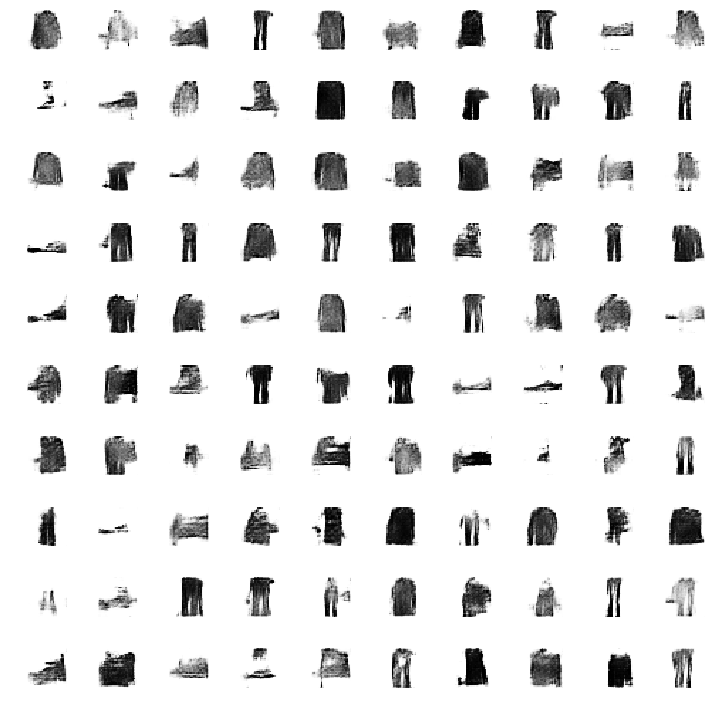

>Saved: generated_plot_0016.png and model_0016.h5
>16, 1/468, d1=-45.908, d2=-228.577 g=258.592
>16, 2/468, d1=-43.142, d2=-223.983 g=287.929
>16, 3/468, d1=-84.832, d2=-252.991 g=188.997
>16, 4/468, d1=-69.183, d2=-143.594 g=283.377
>16, 5/468, d1=2.312, d2=-208.037 g=345.960
>16, 6/468, d1=-2.513, d2=-145.969 g=374.353
>16, 7/468, d1=-19.523, d2=-161.508 g=337.218
>16, 8/468, d1=-41.874, d2=-160.892 g=368.261
>16, 9/468, d1=3.394, d2=-197.718 g=348.538
>16, 10/468, d1=-1.429, d2=-171.120 g=380.389
>16, 11/468, d1=31.712, d2=-199.634 g=363.515
>16, 12/468, d1=-5.520, d2=-165.263 g=434.803
>16, 13/468, d1=-19.657, d2=-213.772 g=386.322
>16, 14/468, d1=-13.494, d2=-175.840 g=340.782
>16, 15/468, d1=-22.380, d2=-204.645 g=259.031
>16, 16/468, d1=-77.670, d2=-200.583 g=201.399
>16, 17/468, d1=-49.836, d2=-158.954 g=271.670
>16, 18/468, d1=2.786, d2=-179.782 g=291.726
>16, 19/468, d1=-14.425, d2=-213.048 g=277.002
>16, 20/468, d1=-25.244, d2=-204.172 g=276.971
>16, 21/468, d1=-74.829, d2=-

>16, 175/468, d1=-16.084, d2=-300.231 g=237.258
>16, 176/468, d1=-15.901, d2=-314.040 g=175.236
>16, 177/468, d1=-27.093, d2=-325.527 g=132.971
>16, 178/468, d1=-44.436, d2=-299.697 g=76.886
>16, 179/468, d1=-138.775, d2=-276.377 g=53.657
>16, 180/468, d1=-128.485, d2=-337.581 g=59.701
>16, 181/468, d1=-140.089, d2=-172.150 g=-12.885
>16, 182/468, d1=-94.134, d2=-283.824 g=-62.907
>16, 183/468, d1=-116.365, d2=-163.528 g=-98.985
>16, 184/468, d1=-154.221, d2=-56.481 g=15.489
>16, 185/468, d1=-203.643, d2=-17.714 g=-124.735
>16, 186/468, d1=-186.971, d2=84.726 g=20.263
>16, 187/468, d1=-279.084, d2=120.107 g=136.856
>16, 188/468, d1=-307.228, d2=111.563 g=157.999
>16, 189/468, d1=-287.086, d2=81.113 g=324.034
>16, 190/468, d1=-275.412, d2=107.706 g=212.122
>16, 191/468, d1=-261.114, d2=79.264 g=288.296
>16, 192/468, d1=-249.703, d2=63.623 g=202.715
>16, 193/468, d1=-251.948, d2=58.703 g=280.994
>16, 194/468, d1=-226.254, d2=64.653 g=165.651
>16, 195/468, d1=-251.104, d2=69.161 g=126.673

>16, 349/468, d1=-646.266, d2=-404.987 g=-432.165
>16, 350/468, d1=-689.838, d2=-446.888 g=-666.466
>16, 351/468, d1=-686.860, d2=-338.741 g=-570.807
>16, 352/468, d1=-845.261, d2=-405.254 g=-785.576
>16, 353/468, d1=-864.740, d2=-278.397 g=-774.443
>16, 354/468, d1=-835.159, d2=-278.235 g=-862.142
>16, 355/468, d1=-1008.762, d2=-293.897 g=-929.722
>16, 356/468, d1=-925.297, d2=8.616 g=-947.762
>16, 357/468, d1=-861.414, d2=121.115 g=-953.369
>16, 358/468, d1=-659.344, d2=578.118 g=-891.304
>16, 359/468, d1=-754.858, d2=482.027 g=-898.640
>16, 360/468, d1=-1063.803, d2=742.258 g=-1036.821
>16, 361/468, d1=-872.817, d2=935.380 g=-1015.064
>16, 362/468, d1=-1007.258, d2=1010.712 g=-976.633
>16, 363/468, d1=-1066.544, d2=1083.397 g=-979.773
>16, 364/468, d1=-1077.014, d2=1122.799 g=-813.306
>16, 365/468, d1=-1138.231, d2=1129.446 g=-820.904
>16, 366/468, d1=-1148.576, d2=1089.026 g=-774.153
>16, 367/468, d1=-1145.440, d2=1002.614 g=-810.333
>16, 368/468, d1=-1166.398, d2=925.627 g=-829.82

>17, 49/468, d1=-664.075, d2=561.219 g=-521.640
>17, 50/468, d1=-634.740, d2=582.295 g=-417.708
>17, 51/468, d1=-596.259, d2=503.046 g=-516.949
>17, 52/468, d1=-609.883, d2=504.208 g=-556.530
>17, 53/468, d1=-598.753, d2=535.324 g=-309.595
>17, 54/468, d1=-641.226, d2=528.664 g=-387.657
>17, 55/468, d1=-650.722, d2=624.807 g=-403.036
>17, 56/468, d1=-552.880, d2=521.501 g=-353.928
>17, 57/468, d1=-555.855, d2=540.676 g=-249.437
>17, 58/468, d1=-544.086, d2=482.236 g=-246.350
>17, 59/468, d1=-545.811, d2=467.287 g=-296.223
>17, 60/468, d1=-558.801, d2=454.127 g=-160.807
>17, 61/468, d1=-518.910, d2=429.528 g=-264.335
>17, 62/468, d1=-504.351, d2=430.083 g=-242.670
>17, 63/468, d1=-504.218, d2=422.140 g=-233.504
>17, 64/468, d1=-515.682, d2=425.294 g=-260.359
>17, 65/468, d1=-502.597, d2=422.472 g=-214.042
>17, 66/468, d1=-523.665, d2=393.917 g=-195.727
>17, 67/468, d1=-488.456, d2=387.432 g=-170.056
>17, 68/468, d1=-452.257, d2=349.924 g=-196.577
>17, 69/468, d1=-450.820, d2=342.705 g=-

>17, 220/468, d1=-444.725, d2=325.108 g=-264.502
>17, 221/468, d1=-511.018, d2=304.858 g=-342.967
>17, 222/468, d1=-508.820, d2=377.274 g=-293.208
>17, 223/468, d1=-469.934, d2=356.832 g=-331.701
>17, 224/468, d1=-549.572, d2=384.320 g=-270.563
>17, 225/468, d1=-432.656, d2=325.790 g=-173.066
>17, 226/468, d1=-466.190, d2=338.071 g=-271.623
>17, 227/468, d1=-508.856, d2=375.488 g=-299.016
>17, 228/468, d1=-426.776, d2=335.528 g=-298.372
>17, 229/468, d1=-462.754, d2=335.321 g=-300.699
>17, 230/468, d1=-423.650, d2=318.753 g=-215.542
>17, 231/468, d1=-440.325, d2=360.212 g=-158.152
>17, 232/468, d1=-428.574, d2=300.535 g=-189.814
>17, 233/468, d1=-446.899, d2=331.391 g=-162.289
>17, 234/468, d1=-453.702, d2=346.670 g=-208.459
>17, 235/468, d1=-435.320, d2=327.295 g=-184.422
>17, 236/468, d1=-408.403, d2=295.406 g=-157.483
>17, 237/468, d1=-447.808, d2=321.912 g=-218.822
>17, 238/468, d1=-427.517, d2=338.479 g=-144.346
>17, 239/468, d1=-431.295, d2=333.245 g=-161.526
>17, 240/468, d1=-41

>17, 388/468, d1=-1374.538, d2=1350.417 g=-1129.964
>17, 389/468, d1=-1407.541, d2=1287.969 g=-830.890
>17, 390/468, d1=-1455.108, d2=1297.552 g=-696.821
>17, 391/468, d1=-1458.376, d2=1304.749 g=-571.013
>17, 392/468, d1=-1412.912, d2=1256.215 g=-630.795
>17, 393/468, d1=-1357.913, d2=1135.337 g=-696.673
>17, 394/468, d1=-1322.492, d2=1127.439 g=-856.433
>17, 395/468, d1=-1299.383, d2=1006.843 g=-924.391
>17, 396/468, d1=-1266.687, d2=909.122 g=-926.807
>17, 397/468, d1=-1180.185, d2=883.878 g=-979.038
>17, 398/468, d1=-1148.439, d2=838.971 g=-962.256
>17, 399/468, d1=-1045.273, d2=805.612 g=-921.172
>17, 400/468, d1=-1090.758, d2=711.045 g=-913.339
>17, 401/468, d1=-982.630, d2=658.483 g=-932.913
>17, 402/468, d1=-978.126, d2=671.457 g=-893.512
>17, 403/468, d1=-879.487, d2=585.073 g=-936.652
>17, 404/468, d1=-919.581, d2=617.661 g=-918.601
>17, 405/468, d1=-830.949, d2=638.046 g=-967.840
>17, 406/468, d1=-875.951, d2=523.868 g=-926.260
>17, 407/468, d1=-934.259, d2=666.806 g=-987.48

>18, 90/468, d1=-500.401, d2=343.893 g=-442.974
>18, 91/468, d1=-508.504, d2=420.166 g=-441.387
>18, 92/468, d1=-473.622, d2=328.846 g=-421.388
>18, 93/468, d1=-524.574, d2=506.014 g=-252.297
>18, 94/468, d1=-529.733, d2=491.174 g=-278.279
>18, 95/468, d1=-579.819, d2=503.130 g=-320.530
>18, 96/468, d1=-615.219, d2=513.653 g=-316.147
>18, 97/468, d1=-621.940, d2=537.076 g=-323.751
>18, 98/468, d1=-647.002, d2=514.663 g=-377.631
>18, 99/468, d1=-636.592, d2=536.146 g=-316.363
>18, 100/468, d1=-637.407, d2=523.365 g=-333.611
>18, 101/468, d1=-627.261, d2=518.565 g=-354.469
>18, 102/468, d1=-625.395, d2=525.722 g=-373.095
>18, 103/468, d1=-629.091, d2=486.839 g=-433.173
>18, 104/468, d1=-665.281, d2=507.745 g=-384.375
>18, 105/468, d1=-624.827, d2=472.323 g=-419.852
>18, 106/468, d1=-633.424, d2=553.676 g=-387.639
>18, 107/468, d1=-644.212, d2=518.231 g=-427.474
>18, 108/468, d1=-649.974, d2=508.648 g=-420.737
>18, 109/468, d1=-642.271, d2=467.646 g=-430.219
>18, 110/468, d1=-600.094, d2=

>18, 259/468, d1=-596.873, d2=393.896 g=-458.746
>18, 260/468, d1=-578.210, d2=394.318 g=-476.822
>18, 261/468, d1=-555.015, d2=345.776 g=-525.186
>18, 262/468, d1=-560.916, d2=398.496 g=-486.406
>18, 263/468, d1=-593.785, d2=444.362 g=-515.108
>18, 264/468, d1=-599.372, d2=429.220 g=-540.889
>18, 265/468, d1=-617.723, d2=482.654 g=-471.531
>18, 266/468, d1=-643.615, d2=445.890 g=-538.968
>18, 267/468, d1=-552.633, d2=387.602 g=-506.348
>18, 268/468, d1=-531.700, d2=467.552 g=-475.613
>18, 269/468, d1=-558.112, d2=412.387 g=-442.495
>18, 270/468, d1=-578.481, d2=422.554 g=-483.309
>18, 271/468, d1=-517.181, d2=377.209 g=-521.479
>18, 272/468, d1=-569.594, d2=429.382 g=-460.643
>18, 273/468, d1=-507.011, d2=446.204 g=-371.444
>18, 274/468, d1=-511.846, d2=402.138 g=-374.004
>18, 275/468, d1=-502.126, d2=393.073 g=-228.293
>18, 276/468, d1=-499.275, d2=371.350 g=-330.387
>18, 277/468, d1=-520.293, d2=433.174 g=-355.736
>18, 278/468, d1=-470.515, d2=436.747 g=-172.820
>18, 279/468, d1=-46

>18, 427/468, d1=-437.519, d2=313.598 g=-205.093
>18, 428/468, d1=-439.308, d2=303.975 g=-206.458
>18, 429/468, d1=-428.393, d2=306.468 g=-195.088
>18, 430/468, d1=-447.450, d2=305.551 g=-278.475
>18, 431/468, d1=-492.291, d2=337.327 g=-308.428
>18, 432/468, d1=-491.523, d2=369.053 g=-327.130
>18, 433/468, d1=-487.371, d2=295.904 g=-322.623
>18, 434/468, d1=-520.109, d2=293.440 g=-363.448
>18, 435/468, d1=-443.377, d2=305.698 g=-317.299
>18, 436/468, d1=-429.970, d2=310.584 g=-355.883
>18, 437/468, d1=-461.470, d2=356.009 g=-283.876
>18, 438/468, d1=-445.087, d2=323.756 g=-321.825
>18, 439/468, d1=-453.099, d2=343.500 g=-238.218
>18, 440/468, d1=-474.262, d2=360.257 g=-247.512
>18, 441/468, d1=-452.330, d2=328.837 g=-260.134
>18, 442/468, d1=-425.982, d2=353.243 g=-64.902
>18, 443/468, d1=-420.921, d2=332.594 g=-160.666
>18, 444/468, d1=-446.121, d2=326.811 g=-188.398
>18, 445/468, d1=-437.701, d2=342.550 g=-154.960
>18, 446/468, d1=-452.200, d2=327.606 g=-159.818
>18, 447/468, d1=-426

>19, 131/468, d1=-523.824, d2=290.693 g=-279.048
>19, 132/468, d1=-536.438, d2=276.859 g=-360.539
>19, 133/468, d1=-483.277, d2=365.553 g=-359.125
>19, 134/468, d1=-506.958, d2=356.965 g=-393.380
>19, 135/468, d1=-468.752, d2=335.661 g=-350.959
>19, 136/468, d1=-430.688, d2=317.542 g=-386.026
>19, 137/468, d1=-492.813, d2=393.714 g=-370.537
>19, 138/468, d1=-397.268, d2=321.644 g=-415.117
>19, 139/468, d1=-394.016, d2=347.058 g=-352.078
>19, 140/468, d1=-464.824, d2=350.391 g=-320.157
>19, 141/468, d1=-398.676, d2=294.592 g=-286.599
>19, 142/468, d1=-491.777, d2=299.579 g=-339.688
>19, 143/468, d1=-518.671, d2=323.821 g=-388.744
>19, 144/468, d1=-424.374, d2=371.346 g=-340.225
>19, 145/468, d1=-450.030, d2=332.662 g=-289.321
>19, 146/468, d1=-470.470, d2=343.610 g=-341.376
>19, 147/468, d1=-436.949, d2=333.524 g=-283.489
>19, 148/468, d1=-454.334, d2=341.056 g=-334.791
>19, 149/468, d1=-419.246, d2=333.630 g=-146.985
>19, 150/468, d1=-386.869, d2=320.862 g=-201.010
>19, 151/468, d1=-43

>19, 298/468, d1=-608.313, d2=473.077 g=-631.378
>19, 299/468, d1=-485.487, d2=429.429 g=-586.136
>19, 300/468, d1=-577.475, d2=334.004 g=-714.720
>19, 301/468, d1=-526.977, d2=418.991 g=-657.021
>19, 302/468, d1=-586.768, d2=411.747 g=-707.085
>19, 303/468, d1=-509.811, d2=483.294 g=-697.534
>19, 304/468, d1=-517.097, d2=402.225 g=-695.265
>19, 305/468, d1=-495.916, d2=473.989 g=-666.333
>19, 306/468, d1=-485.743, d2=417.020 g=-546.758
>19, 307/468, d1=-518.547, d2=417.376 g=-578.747
>19, 308/468, d1=-510.890, d2=488.557 g=-455.646
>19, 309/468, d1=-547.875, d2=469.492 g=-573.386
>19, 310/468, d1=-612.046, d2=439.415 g=-501.632
>19, 311/468, d1=-547.797, d2=448.770 g=-475.592
>19, 312/468, d1=-526.091, d2=520.094 g=-375.158
>19, 313/468, d1=-533.102, d2=513.695 g=-308.216
>19, 314/468, d1=-499.197, d2=487.776 g=-162.227
>19, 315/468, d1=-522.424, d2=460.123 g=-150.318
>19, 316/468, d1=-552.023, d2=427.501 g=-122.808
>19, 317/468, d1=-573.787, d2=361.648 g=-200.800
>19, 318/468, d1=-58

>19, 466/468, d1=-611.596, d2=464.750 g=-568.886
>19, 467/468, d1=-612.152, d2=461.118 g=-676.330
>19, 468/468, d1=-563.836, d2=476.912 g=-595.498
>20, 1/468, d1=-543.080, d2=476.562 g=-534.509
>20, 2/468, d1=-647.689, d2=511.750 g=-551.485
>20, 3/468, d1=-578.585, d2=455.657 g=-571.665
>20, 4/468, d1=-572.248, d2=496.864 g=-547.226
>20, 5/468, d1=-578.434, d2=538.179 g=-522.838
>20, 6/468, d1=-625.008, d2=456.079 g=-518.056
>20, 7/468, d1=-583.509, d2=543.712 g=-488.091
>20, 8/468, d1=-615.746, d2=508.203 g=-477.539
>20, 9/468, d1=-547.354, d2=491.945 g=-505.159
>20, 10/468, d1=-593.078, d2=532.531 g=-457.187
>20, 11/468, d1=-570.043, d2=545.946 g=-449.686
>20, 12/468, d1=-531.818, d2=502.973 g=-382.149
>20, 13/468, d1=-519.771, d2=477.092 g=-359.717
>20, 14/468, d1=-542.230, d2=518.695 g=-309.971
>20, 15/468, d1=-543.076, d2=507.937 g=-316.192
>20, 16/468, d1=-542.784, d2=502.671 g=-284.648
>20, 17/468, d1=-548.342, d2=467.367 g=-297.938
>20, 18/468, d1=-533.960, d2=434.547 g=-320.67

>20, 166/468, d1=-859.360, d2=39.609 g=-779.117
>20, 167/468, d1=-797.540, d2=144.123 g=-860.427
>20, 168/468, d1=-783.300, d2=13.987 g=-933.793
>20, 169/468, d1=-721.687, d2=154.878 g=-882.074
>20, 170/468, d1=-720.137, d2=154.142 g=-844.902
>20, 171/468, d1=-605.689, d2=45.172 g=-957.110
>20, 172/468, d1=-613.938, d2=68.010 g=-946.915
>20, 173/468, d1=-680.974, d2=182.259 g=-991.825
>20, 174/468, d1=-618.822, d2=234.014 g=-945.415
>20, 175/468, d1=-499.584, d2=292.781 g=-925.525
>20, 176/468, d1=-506.590, d2=264.354 g=-775.614
>20, 177/468, d1=-453.828, d2=158.739 g=-793.348
>20, 178/468, d1=-585.233, d2=214.778 g=-850.988
>20, 179/468, d1=-521.048, d2=378.721 g=-812.936
>20, 180/468, d1=-306.130, d2=199.445 g=-715.628
>20, 181/468, d1=-364.178, d2=306.111 g=-600.748
>20, 182/468, d1=-320.658, d2=244.836 g=-510.916
>20, 183/468, d1=-232.874, d2=176.866 g=-470.143
>20, 184/468, d1=-299.135, d2=217.087 g=-318.172
>20, 185/468, d1=-265.519, d2=174.736 g=-318.972
>20, 186/468, d1=-172.66

>20, 333/468, d1=-592.050, d2=458.715 g=-439.804
>20, 334/468, d1=-536.890, d2=517.584 g=-417.293
>20, 335/468, d1=-572.400, d2=522.408 g=-387.615
>20, 336/468, d1=-595.825, d2=515.670 g=-408.445
>20, 337/468, d1=-570.955, d2=519.219 g=-401.510
>20, 338/468, d1=-597.612, d2=552.135 g=-404.779
>20, 339/468, d1=-603.234, d2=536.545 g=-390.649
>20, 340/468, d1=-606.856, d2=545.396 g=-424.095
>20, 341/468, d1=-627.906, d2=556.096 g=-399.462
>20, 342/468, d1=-619.637, d2=531.664 g=-430.938
>20, 343/468, d1=-596.922, d2=540.913 g=-379.510
>20, 344/468, d1=-610.806, d2=512.060 g=-418.869
>20, 345/468, d1=-607.740, d2=503.002 g=-425.242
>20, 346/468, d1=-617.998, d2=521.625 g=-452.251
>20, 347/468, d1=-649.445, d2=484.346 g=-469.522
>20, 348/468, d1=-583.307, d2=491.264 g=-466.217
>20, 349/468, d1=-575.096, d2=486.183 g=-452.635
>20, 350/468, d1=-566.124, d2=487.354 g=-435.071
>20, 351/468, d1=-607.565, d2=479.864 g=-485.166
>20, 352/468, d1=-590.515, d2=494.283 g=-396.463
>20, 353/468, d1=-57

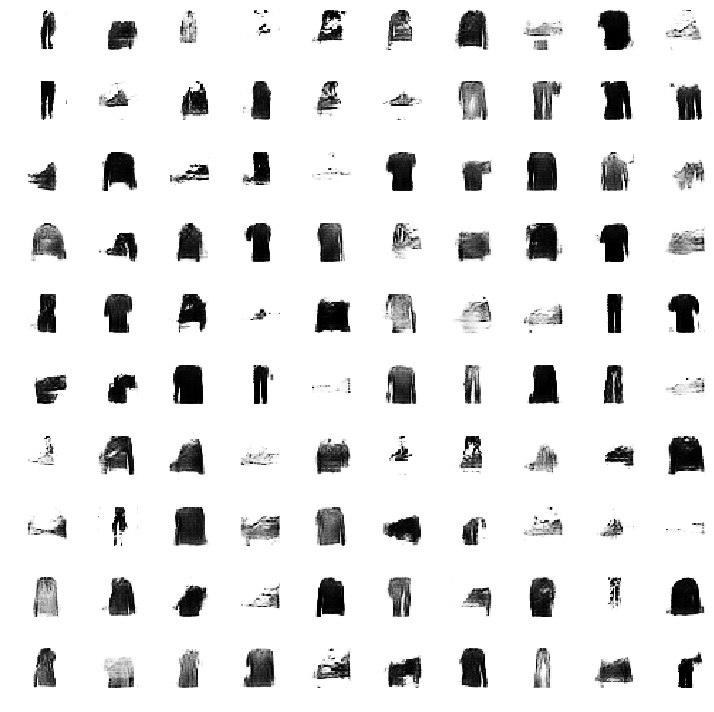

>Saved: generated_plot_0021.png and model_0021.h5
>21, 1/468, d1=-1171.800, d2=1164.293 g=-1006.253
>21, 2/468, d1=-1160.681, d2=1215.639 g=-991.210
>21, 3/468, d1=-1173.939, d2=1142.776 g=-938.028
>21, 4/468, d1=-1113.934, d2=1162.953 g=-927.219
>21, 5/468, d1=-1136.457, d2=1098.210 g=-943.777
>21, 6/468, d1=-1110.958, d2=1126.893 g=-960.591
>21, 7/468, d1=-1095.045, d2=1058.384 g=-944.905
>21, 8/468, d1=-1068.233, d2=1127.630 g=-876.938
>21, 9/468, d1=-1105.781, d2=1125.662 g=-891.734
>21, 10/468, d1=-1109.660, d2=1114.562 g=-915.593
>21, 11/468, d1=-1107.766, d2=1076.040 g=-913.980
>21, 12/468, d1=-1090.310, d2=1041.991 g=-934.707
>21, 13/468, d1=-1082.167, d2=1041.477 g=-909.574
>21, 14/468, d1=-1044.790, d2=974.049 g=-915.824
>21, 15/468, d1=-1029.643, d2=911.484 g=-942.851
>21, 16/468, d1=-1019.541, d2=876.028 g=-978.188
>21, 17/468, d1=-996.807, d2=907.791 g=-935.373
>21, 18/468, d1=-975.102, d2=885.335 g=-993.863
>21, 19/468, d1=-1010.891, d2=779.319 g=-1038.295
>21, 20/468, d1

>21, 169/468, d1=-1375.724, d2=1096.012 g=-903.757
>21, 170/468, d1=-1373.474, d2=1042.609 g=-582.906
>21, 171/468, d1=-1386.516, d2=965.340 g=-286.961
>21, 172/468, d1=-1340.303, d2=917.474 g=-122.190
>21, 173/468, d1=-1321.894, d2=915.912 g=-92.554
>21, 174/468, d1=-1358.533, d2=939.195 g=-40.281
>21, 175/468, d1=-1207.257, d2=991.743 g=-429.970
>21, 176/468, d1=-1186.912, d2=1013.712 g=-655.066
>21, 177/468, d1=-1086.597, d2=747.869 g=-816.566
>21, 178/468, d1=-1058.230, d2=665.031 g=-834.068
>21, 179/468, d1=-933.244, d2=582.881 g=-793.571
>21, 180/468, d1=-894.528, d2=488.925 g=-797.795
>21, 181/468, d1=-864.926, d2=514.563 g=-761.098
>21, 182/468, d1=-886.808, d2=556.375 g=-791.528
>21, 183/468, d1=-833.762, d2=500.889 g=-719.007
>21, 184/468, d1=-736.685, d2=513.095 g=-765.689
>21, 185/468, d1=-722.774, d2=451.996 g=-744.142
>21, 186/468, d1=-721.906, d2=406.404 g=-660.785
>21, 187/468, d1=-726.210, d2=362.349 g=-725.402
>21, 188/468, d1=-629.537, d2=382.797 g=-730.112
>21, 189/

>21, 336/468, d1=-670.756, d2=546.641 g=-608.522
>21, 337/468, d1=-702.453, d2=541.816 g=-665.990
>21, 338/468, d1=-734.252, d2=446.298 g=-796.836
>21, 339/468, d1=-746.042, d2=400.548 g=-929.296
>21, 340/468, d1=-788.953, d2=285.462 g=-1069.691
>21, 341/468, d1=-798.536, d2=414.667 g=-1092.825
>21, 342/468, d1=-905.644, d2=419.133 g=-1216.049
>21, 343/468, d1=-940.806, d2=455.430 g=-1354.345
>21, 344/468, d1=-852.952, d2=491.804 g=-1352.943
>21, 345/468, d1=-946.655, d2=585.337 g=-1274.427
>21, 346/468, d1=-901.948, d2=680.822 g=-1199.349
>21, 347/468, d1=-1010.319, d2=806.417 g=-1082.465
>21, 348/468, d1=-1086.370, d2=801.132 g=-1020.214
>21, 349/468, d1=-1057.647, d2=791.611 g=-943.446
>21, 350/468, d1=-1128.567, d2=838.604 g=-775.166
>21, 351/468, d1=-1204.937, d2=823.691 g=-625.181
>21, 352/468, d1=-1216.496, d2=800.566 g=-474.211
>21, 353/468, d1=-1262.467, d2=786.493 g=-422.988
>21, 354/468, d1=-1285.545, d2=771.433 g=-222.808
>21, 355/468, d1=-1289.689, d2=734.582 g=3.672
>21, 

>22, 36/468, d1=-640.539, d2=565.893 g=-311.146
>22, 37/468, d1=-638.130, d2=546.821 g=-355.076
>22, 38/468, d1=-673.268, d2=576.517 g=-406.253
>22, 39/468, d1=-671.135, d2=576.681 g=-435.468
>22, 40/468, d1=-695.195, d2=557.180 g=-532.382
>22, 41/468, d1=-736.662, d2=572.553 g=-469.086
>22, 42/468, d1=-750.110, d2=521.014 g=-652.687
>22, 43/468, d1=-737.636, d2=419.003 g=-726.900
>22, 44/468, d1=-799.627, d2=412.313 g=-815.043
>22, 45/468, d1=-809.982, d2=448.604 g=-863.620
>22, 46/468, d1=-798.590, d2=414.241 g=-1025.382
>22, 47/468, d1=-820.726, d2=351.977 g=-1085.238
>22, 48/468, d1=-867.174, d2=332.409 g=-1224.266
>22, 49/468, d1=-920.051, d2=369.485 g=-1347.216
>22, 50/468, d1=-796.393, d2=442.914 g=-1274.721
>22, 51/468, d1=-879.420, d2=576.950 g=-1279.551
>22, 52/468, d1=-971.682, d2=629.099 g=-1359.341
>22, 53/468, d1=-901.055, d2=669.672 g=-1324.725
>22, 54/468, d1=-919.518, d2=825.213 g=-1242.325
>22, 55/468, d1=-1000.655, d2=895.822 g=-1135.208
>22, 56/468, d1=-1085.233, d2

>22, 203/468, d1=-596.754, d2=564.582 g=-457.828
>22, 204/468, d1=-604.364, d2=572.601 g=-440.215
>22, 205/468, d1=-615.967, d2=614.162 g=-395.653
>22, 206/468, d1=-604.226, d2=575.899 g=-398.983
>22, 207/468, d1=-642.264, d2=586.937 g=-382.482
>22, 208/468, d1=-645.824, d2=580.418 g=-359.318
>22, 209/468, d1=-643.505, d2=600.359 g=-435.451
>22, 210/468, d1=-708.461, d2=589.744 g=-395.443
>22, 211/468, d1=-720.746, d2=586.199 g=-348.713
>22, 212/468, d1=-713.901, d2=560.015 g=-479.937
>22, 213/468, d1=-746.359, d2=546.448 g=-625.239
>22, 214/468, d1=-783.405, d2=558.969 g=-639.174
>22, 215/468, d1=-745.491, d2=548.969 g=-687.874
>22, 216/468, d1=-732.671, d2=524.385 g=-653.902
>22, 217/468, d1=-762.163, d2=427.387 g=-787.952
>22, 218/468, d1=-815.070, d2=280.402 g=-967.403
>22, 219/468, d1=-819.505, d2=341.310 g=-1088.668
>22, 220/468, d1=-796.687, d2=370.533 g=-1187.458
>22, 221/468, d1=-886.075, d2=423.861 g=-1189.297
>22, 222/468, d1=-809.977, d2=501.828 g=-1205.661
>22, 223/468, d1

>22, 371/468, d1=-1130.977, d2=948.079 g=-1512.371
>22, 372/468, d1=-1097.629, d2=962.294 g=-1463.315
>22, 373/468, d1=-973.901, d2=886.151 g=-1501.905
>22, 374/468, d1=-897.385, d2=970.034 g=-1398.848
>22, 375/468, d1=-942.657, d2=959.606 g=-1336.730
>22, 376/468, d1=-874.065, d2=989.569 g=-1276.547
>22, 377/468, d1=-869.083, d2=944.490 g=-1189.269
>22, 378/468, d1=-858.909, d2=912.810 g=-1155.827
>22, 379/468, d1=-877.943, d2=1039.540 g=-1052.174
>22, 380/468, d1=-845.218, d2=909.432 g=-1000.932
>22, 381/468, d1=-891.951, d2=927.950 g=-983.208
>22, 382/468, d1=-822.862, d2=892.418 g=-847.697
>22, 383/468, d1=-806.616, d2=871.621 g=-757.219
>22, 384/468, d1=-814.851, d2=893.881 g=-635.716
>22, 385/468, d1=-850.014, d2=857.449 g=-499.411
>22, 386/468, d1=-837.309, d2=831.773 g=-507.872
>22, 387/468, d1=-815.529, d2=779.812 g=-438.958
>22, 388/468, d1=-813.686, d2=797.229 g=-440.992
>22, 389/468, d1=-789.297, d2=765.385 g=-463.245
>22, 390/468, d1=-823.696, d2=779.761 g=-428.020
>22, 39

>23, 70/468, d1=-776.482, d2=673.810 g=-622.277
>23, 71/468, d1=-797.612, d2=686.831 g=-618.056
>23, 72/468, d1=-816.454, d2=653.801 g=-689.651
>23, 73/468, d1=-741.593, d2=610.523 g=-698.412
>23, 74/468, d1=-799.095, d2=620.018 g=-783.311
>23, 75/468, d1=-752.423, d2=597.630 g=-758.901
>23, 76/468, d1=-811.994, d2=523.152 g=-919.493
>23, 77/468, d1=-818.848, d2=588.009 g=-1018.679
>23, 78/468, d1=-786.644, d2=493.978 g=-1114.283
>23, 79/468, d1=-864.471, d2=544.745 g=-1165.007
>23, 80/468, d1=-826.894, d2=593.970 g=-1128.957
>23, 81/468, d1=-884.146, d2=571.158 g=-1149.317
>23, 82/468, d1=-840.982, d2=660.136 g=-1053.193
>23, 83/468, d1=-949.153, d2=701.726 g=-994.027
>23, 84/468, d1=-996.270, d2=697.454 g=-1025.040
>23, 85/468, d1=-998.690, d2=727.750 g=-870.601
>23, 86/468, d1=-1016.980, d2=743.042 g=-718.172
>23, 87/468, d1=-1084.490, d2=739.564 g=-616.850
>23, 88/468, d1=-1076.658, d2=704.360 g=-573.876
>23, 89/468, d1=-1086.174, d2=666.124 g=-323.352
>23, 90/468, d1=-1154.763, d2

>23, 236/468, d1=-661.895, d2=656.594 g=-557.645
>23, 237/468, d1=-698.832, d2=631.258 g=-476.988
>23, 238/468, d1=-680.065, d2=558.556 g=-537.182
>23, 239/468, d1=-624.634, d2=578.679 g=-262.998
>23, 240/468, d1=-661.841, d2=545.330 g=-172.087
>23, 241/468, d1=-652.383, d2=523.158 g=-250.254
>23, 242/468, d1=-648.961, d2=494.390 g=-56.569
>23, 243/468, d1=-630.361, d2=475.586 g=-132.418
>23, 244/468, d1=-652.521, d2=463.475 g=-159.894
>23, 245/468, d1=-643.461, d2=455.623 g=4.986
>23, 246/468, d1=-649.368, d2=475.823 g=17.496
>23, 247/468, d1=-634.172, d2=449.910 g=-30.443
>23, 248/468, d1=-640.792, d2=468.631 g=-85.870
>23, 249/468, d1=-665.971, d2=515.194 g=-298.700
>23, 250/468, d1=-706.044, d2=478.579 g=-487.375
>23, 251/468, d1=-712.074, d2=561.277 g=-738.717
>23, 252/468, d1=-792.236, d2=569.607 g=-730.059
>23, 253/468, d1=-836.966, d2=538.857 g=-820.906
>23, 254/468, d1=-931.997, d2=513.980 g=-1051.018
>23, 255/468, d1=-914.857, d2=511.090 g=-1074.221
>23, 256/468, d1=-1028.203

>24, 101/468, d1=-535.429, d2=399.512 g=-912.474
>24, 102/468, d1=-486.351, d2=523.667 g=-800.397
>24, 103/468, d1=-498.373, d2=513.819 g=-748.608
>24, 104/468, d1=-484.163, d2=507.019 g=-708.733
>24, 105/468, d1=-456.761, d2=481.371 g=-557.458
>24, 106/468, d1=-409.271, d2=485.413 g=-429.982
>24, 107/468, d1=-483.238, d2=413.297 g=-453.687
>24, 108/468, d1=-475.733, d2=480.364 g=-336.185
>24, 109/468, d1=-429.151, d2=439.321 g=-142.498
>24, 110/468, d1=-438.021, d2=413.516 g=-135.646
>24, 111/468, d1=-446.431, d2=405.380 g=-86.562
>24, 112/468, d1=-481.606, d2=403.595 g=-151.542
>24, 113/468, d1=-482.633, d2=408.203 g=-46.581
>24, 114/468, d1=-485.174, d2=377.086 g=-83.190
>24, 115/468, d1=-488.770, d2=395.659 g=-149.038
>24, 116/468, d1=-558.046, d2=375.084 g=-207.433
>24, 117/468, d1=-555.215, d2=358.985 g=-324.313
>24, 118/468, d1=-553.752, d2=368.252 g=-431.775
>24, 119/468, d1=-629.763, d2=415.682 g=-529.873
>24, 120/468, d1=-620.403, d2=398.565 g=-575.766
>24, 121/468, d1=-740.3

>24, 268/468, d1=-1247.907, d2=1028.871 g=-1319.893
>24, 269/468, d1=-1269.063, d2=855.335 g=-1269.956
>24, 270/468, d1=-1094.967, d2=776.959 g=-1291.120
>24, 271/468, d1=-948.117, d2=700.919 g=-1248.101
>24, 272/468, d1=-914.438, d2=568.664 g=-1173.218
>24, 273/468, d1=-999.876, d2=563.152 g=-1275.713
>24, 274/468, d1=-792.969, d2=477.536 g=-1148.949
>24, 275/468, d1=-797.487, d2=463.281 g=-1089.371
>24, 276/468, d1=-679.419, d2=359.447 g=-1047.025
>24, 277/468, d1=-800.407, d2=463.339 g=-1135.749
>24, 278/468, d1=-779.355, d2=468.595 g=-1096.215
>24, 279/468, d1=-677.623, d2=397.164 g=-1023.349
>24, 280/468, d1=-715.357, d2=444.377 g=-1050.978
>24, 281/468, d1=-719.758, d2=517.791 g=-932.987
>24, 282/468, d1=-588.148, d2=344.209 g=-963.840
>24, 283/468, d1=-665.660, d2=388.002 g=-997.605
>24, 284/468, d1=-615.883, d2=481.813 g=-1012.219
>24, 285/468, d1=-569.458, d2=390.924 g=-955.307
>24, 286/468, d1=-584.675, d2=424.247 g=-983.274
>24, 287/468, d1=-619.224, d2=486.953 g=-877.758
>2

>24, 435/468, d1=-878.700, d2=775.554 g=-785.973
>24, 436/468, d1=-901.889, d2=778.050 g=-771.479
>24, 437/468, d1=-866.168, d2=745.783 g=-726.899
>24, 438/468, d1=-899.125, d2=735.946 g=-699.734
>24, 439/468, d1=-838.378, d2=737.885 g=-684.302
>24, 440/468, d1=-802.136, d2=721.367 g=-644.337
>24, 441/468, d1=-829.140, d2=705.148 g=-666.596
>24, 442/468, d1=-830.478, d2=709.780 g=-577.437
>24, 443/468, d1=-819.833, d2=691.808 g=-634.119
>24, 444/468, d1=-843.932, d2=697.862 g=-672.986
>24, 445/468, d1=-821.370, d2=675.925 g=-669.020
>24, 446/468, d1=-831.163, d2=680.353 g=-677.806
>24, 447/468, d1=-845.941, d2=677.144 g=-658.232
>24, 448/468, d1=-832.549, d2=644.209 g=-702.162
>24, 449/468, d1=-780.547, d2=662.545 g=-629.167
>24, 450/468, d1=-795.232, d2=658.658 g=-588.018
>24, 451/468, d1=-787.369, d2=641.211 g=-570.143
>24, 452/468, d1=-732.856, d2=659.905 g=-526.825
>24, 453/468, d1=-771.144, d2=638.539 g=-533.858
>24, 454/468, d1=-740.267, d2=625.184 g=-563.545
>24, 455/468, d1=-71

>25, 136/468, d1=-1060.397, d2=1057.606 g=-1016.976
>25, 137/468, d1=-1048.536, d2=1032.743 g=-1018.885
>25, 138/468, d1=-1024.373, d2=1052.594 g=-920.914
>25, 139/468, d1=-1037.188, d2=1069.409 g=-935.209
>25, 140/468, d1=-1058.896, d2=1081.523 g=-896.198
>25, 141/468, d1=-1078.538, d2=1056.815 g=-947.350
>25, 142/468, d1=-1066.571, d2=1033.808 g=-942.841
>25, 143/468, d1=-1097.611, d2=1058.450 g=-971.748
>25, 144/468, d1=-1071.303, d2=1105.688 g=-863.007
>25, 145/468, d1=-1110.995, d2=1114.766 g=-929.824
>25, 146/468, d1=-1108.287, d2=1070.721 g=-956.160
>25, 147/468, d1=-1118.783, d2=1093.517 g=-880.221
>25, 148/468, d1=-1124.648, d2=1076.996 g=-930.700
>25, 149/468, d1=-1143.311, d2=1069.869 g=-957.197
>25, 150/468, d1=-1136.801, d2=1079.161 g=-961.373
>25, 151/468, d1=-1142.825, d2=1070.550 g=-976.571
>25, 152/468, d1=-1162.555, d2=1022.865 g=-1078.102
>25, 153/468, d1=-1154.693, d2=1053.606 g=-1080.355
>25, 154/468, d1=-1157.582, d2=1061.492 g=-1016.905
>25, 155/468, d1=-1161.501

>25, 301/468, d1=-973.016, d2=859.504 g=-785.876
>25, 302/468, d1=-966.529, d2=865.122 g=-773.099
>25, 303/468, d1=-954.220, d2=856.380 g=-789.917
>25, 304/468, d1=-942.007, d2=878.466 g=-777.711
>25, 305/468, d1=-955.008, d2=838.603 g=-815.181
>25, 306/468, d1=-965.478, d2=844.305 g=-792.814
>25, 307/468, d1=-972.174, d2=869.336 g=-813.096
>25, 308/468, d1=-938.657, d2=840.369 g=-797.963
>25, 309/468, d1=-950.312, d2=876.012 g=-707.182
>25, 310/468, d1=-922.046, d2=840.641 g=-736.354
>25, 311/468, d1=-942.709, d2=847.863 g=-737.523
>25, 312/468, d1=-947.387, d2=838.090 g=-707.675
>25, 313/468, d1=-940.642, d2=825.855 g=-736.630
>25, 314/468, d1=-932.103, d2=840.896 g=-743.190
>25, 315/468, d1=-933.426, d2=836.511 g=-696.948
>25, 316/468, d1=-943.801, d2=844.575 g=-714.358
>25, 317/468, d1=-947.138, d2=850.143 g=-701.544
>25, 318/468, d1=-947.019, d2=844.051 g=-719.381
>25, 319/468, d1=-958.078, d2=868.190 g=-725.890
>25, 320/468, d1=-956.866, d2=869.905 g=-761.713
>25, 321/468, d1=-96

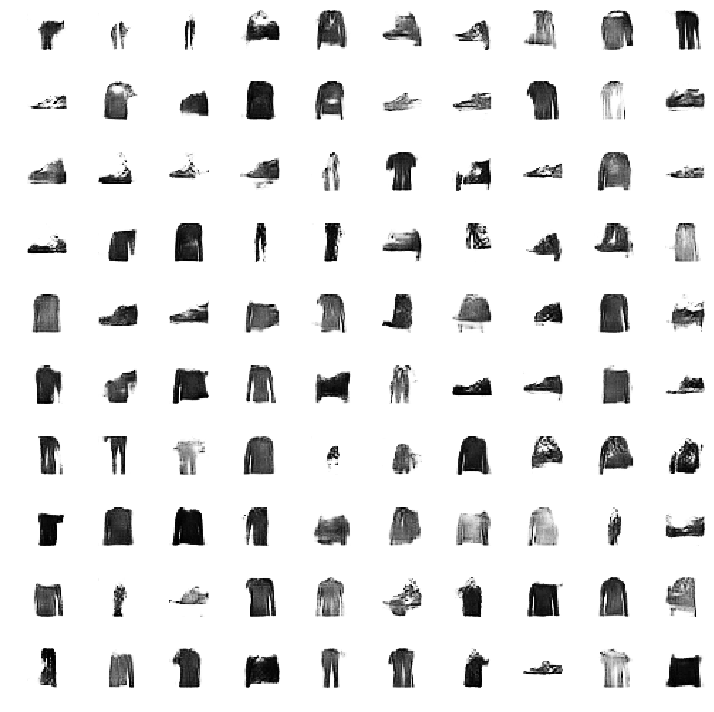

>Saved: generated_plot_0026.png and model_0026.h5
>26, 1/468, d1=-919.817, d2=814.887 g=-710.569
>26, 2/468, d1=-910.744, d2=814.586 g=-733.084
>26, 3/468, d1=-905.921, d2=807.437 g=-653.726
>26, 4/468, d1=-905.137, d2=804.144 g=-718.558
>26, 5/468, d1=-940.279, d2=818.752 g=-713.082
>26, 6/468, d1=-909.352, d2=833.692 g=-706.375
>26, 7/468, d1=-912.611, d2=830.428 g=-705.113
>26, 8/468, d1=-908.872, d2=827.561 g=-707.281
>26, 9/468, d1=-903.947, d2=812.306 g=-699.456
>26, 10/468, d1=-915.266, d2=810.916 g=-697.778
>26, 11/468, d1=-903.649, d2=820.828 g=-679.583
>26, 12/468, d1=-921.897, d2=824.435 g=-722.738
>26, 13/468, d1=-913.123, d2=828.377 g=-725.468
>26, 14/468, d1=-926.675, d2=838.808 g=-721.541
>26, 15/468, d1=-914.551, d2=836.537 g=-733.034
>26, 16/468, d1=-922.640, d2=839.789 g=-693.568
>26, 17/468, d1=-938.755, d2=841.561 g=-706.635
>26, 18/468, d1=-917.729, d2=834.821 g=-717.727
>26, 19/468, d1=-931.118, d2=825.388 g=-746.242
>26, 20/468, d1=-908.467, d2=823.785 g=-765.288

>26, 170/468, d1=-898.438, d2=749.616 g=-824.604
>26, 171/468, d1=-902.489, d2=755.243 g=-749.755
>26, 172/468, d1=-890.339, d2=755.908 g=-747.511
>26, 173/468, d1=-874.182, d2=731.612 g=-709.234
>26, 174/468, d1=-906.201, d2=742.565 g=-652.127
>26, 175/468, d1=-884.144, d2=756.837 g=-493.366
>26, 176/468, d1=-883.548, d2=742.206 g=-488.435
>26, 177/468, d1=-902.104, d2=768.160 g=-503.414
>26, 178/468, d1=-873.270, d2=746.218 g=-460.874
>26, 179/468, d1=-914.741, d2=782.009 g=-531.625
>26, 180/468, d1=-918.688, d2=764.013 g=-492.191
>26, 181/468, d1=-933.272, d2=810.766 g=-606.610
>26, 182/468, d1=-920.800, d2=788.679 g=-718.594
>26, 183/468, d1=-953.375, d2=828.354 g=-735.184
>26, 184/468, d1=-980.823, d2=817.350 g=-779.298
>26, 185/468, d1=-1007.789, d2=809.354 g=-803.750
>26, 186/468, d1=-1042.423, d2=802.763 g=-898.718
>26, 187/468, d1=-1065.713, d2=839.262 g=-976.099
>26, 188/468, d1=-1078.227, d2=890.135 g=-932.760
>26, 189/468, d1=-1101.124, d2=882.185 g=-967.418
>26, 190/468, d

>26, 338/468, d1=-944.084, d2=812.867 g=-725.906
>26, 339/468, d1=-938.701, d2=797.712 g=-754.342
>26, 340/468, d1=-905.001, d2=813.783 g=-702.593
>26, 341/468, d1=-915.950, d2=813.237 g=-739.448
>26, 342/468, d1=-923.889, d2=809.921 g=-731.381
>26, 343/468, d1=-912.823, d2=821.387 g=-778.592
>26, 344/468, d1=-942.895, d2=822.663 g=-770.406
>26, 345/468, d1=-933.853, d2=825.102 g=-725.059
>26, 346/468, d1=-938.107, d2=815.419 g=-766.085
>26, 347/468, d1=-926.307, d2=839.057 g=-758.740
>26, 348/468, d1=-903.301, d2=816.310 g=-724.917
>26, 349/468, d1=-892.513, d2=804.813 g=-698.838
>26, 350/468, d1=-893.765, d2=806.331 g=-706.700
>26, 351/468, d1=-884.296, d2=792.291 g=-717.300
>26, 352/468, d1=-912.559, d2=813.238 g=-677.305
>26, 353/468, d1=-889.281, d2=812.098 g=-697.269
>26, 354/468, d1=-901.142, d2=819.563 g=-719.444
>26, 355/468, d1=-915.421, d2=827.534 g=-705.813
>26, 356/468, d1=-901.672, d2=813.264 g=-637.039
>26, 357/468, d1=-896.198, d2=813.544 g=-710.765
>26, 358/468, d1=-90

>27, 39/468, d1=-1047.664, d2=767.840 g=-1061.204
>27, 40/468, d1=-1134.926, d2=818.526 g=-1190.527
>27, 41/468, d1=-1166.494, d2=797.537 g=-1234.641
>27, 42/468, d1=-1240.983, d2=877.094 g=-1358.917
>27, 43/468, d1=-1243.593, d2=886.043 g=-1431.446
>27, 44/468, d1=-1286.691, d2=980.587 g=-1451.728
>27, 45/468, d1=-1335.125, d2=1030.962 g=-1525.653
>27, 46/468, d1=-1366.408, d2=1061.590 g=-1585.380
>27, 47/468, d1=-1388.502, d2=1170.474 g=-1592.225
>27, 48/468, d1=-1433.627, d2=1163.256 g=-1499.212
>27, 49/468, d1=-1442.537, d2=1239.466 g=-1511.849
>27, 50/468, d1=-1448.176, d2=1204.596 g=-1498.226
>27, 51/468, d1=-1438.485, d2=1251.394 g=-1293.788
>27, 52/468, d1=-1456.219, d2=1252.818 g=-1196.773
>27, 53/468, d1=-1434.566, d2=1304.630 g=-1197.476
>27, 54/468, d1=-1451.248, d2=1315.798 g=-1294.656
>27, 55/468, d1=-1434.244, d2=1380.452 g=-1202.371
>27, 56/468, d1=-1431.478, d2=1432.386 g=-1245.827
>27, 57/468, d1=-1379.317, d2=1414.377 g=-1185.015
>27, 58/468, d1=-1370.687, d2=1387.28

>27, 203/468, d1=-913.706, d2=792.983 g=-1071.442
>27, 204/468, d1=-938.824, d2=846.143 g=-1072.035
>27, 205/468, d1=-1013.972, d2=869.237 g=-1022.664
>27, 206/468, d1=-901.957, d2=823.480 g=-952.124
>27, 207/468, d1=-966.395, d2=858.584 g=-892.693
>27, 208/468, d1=-925.046, d2=842.447 g=-821.462
>27, 209/468, d1=-926.326, d2=865.186 g=-752.235
>27, 210/468, d1=-959.920, d2=820.793 g=-847.232
>27, 211/468, d1=-958.188, d2=838.887 g=-641.137
>27, 212/468, d1=-952.750, d2=832.688 g=-613.319
>27, 213/468, d1=-991.665, d2=807.757 g=-506.973
>27, 214/468, d1=-977.146, d2=803.530 g=-446.578
>27, 215/468, d1=-980.170, d2=774.869 g=-472.513
>27, 216/468, d1=-1000.290, d2=787.463 g=-353.719
>27, 217/468, d1=-993.516, d2=782.776 g=-327.404
>27, 218/468, d1=-981.289, d2=771.915 g=-318.783
>27, 219/468, d1=-1007.021, d2=785.360 g=-388.972
>27, 220/468, d1=-987.540, d2=806.329 g=-513.155
>27, 221/468, d1=-1047.324, d2=785.763 g=-856.929
>27, 222/468, d1=-1085.647, d2=862.480 g=-940.802
>27, 223/468

>27, 366/468, d1=-987.212, d2=828.724 g=-1135.546
>27, 367/468, d1=-1068.301, d2=836.413 g=-1172.523
>27, 368/468, d1=-1029.374, d2=812.148 g=-1224.225
>27, 369/468, d1=-1043.228, d2=742.481 g=-1180.618
>27, 370/468, d1=-940.674, d2=784.214 g=-1170.691
>27, 371/468, d1=-929.242, d2=788.285 g=-1164.135
>27, 372/468, d1=-979.151, d2=782.849 g=-1174.962
>27, 373/468, d1=-1022.750, d2=777.749 g=-1208.725
>27, 374/468, d1=-1010.014, d2=817.532 g=-1204.195
>27, 375/468, d1=-959.143, d2=817.271 g=-1214.410
>27, 376/468, d1=-1008.343, d2=904.206 g=-1107.051
>27, 377/468, d1=-1006.262, d2=822.413 g=-1117.029
>27, 378/468, d1=-988.214, d2=879.001 g=-1088.679
>27, 379/468, d1=-916.239, d2=823.878 g=-1027.625
>27, 380/468, d1=-988.808, d2=908.424 g=-1019.690
>27, 381/468, d1=-898.513, d2=875.080 g=-930.923
>27, 382/468, d1=-947.447, d2=879.519 g=-892.637
>27, 383/468, d1=-967.084, d2=883.889 g=-861.704
>27, 384/468, d1=-965.482, d2=869.976 g=-708.677
>27, 385/468, d1=-980.187, d2=872.633 g=-765.51

>28, 63/468, d1=-1054.581, d2=959.060 g=-863.271
>28, 64/468, d1=-1012.954, d2=914.860 g=-840.316
>28, 65/468, d1=-1023.982, d2=919.005 g=-862.437
>28, 66/468, d1=-1039.330, d2=937.336 g=-813.761
>28, 67/468, d1=-1021.088, d2=912.263 g=-866.034
>28, 68/468, d1=-982.333, d2=912.809 g=-805.525
>28, 69/468, d1=-1011.868, d2=926.786 g=-792.867
>28, 70/468, d1=-1012.344, d2=931.200 g=-778.666
>28, 71/468, d1=-1028.349, d2=904.287 g=-798.814
>28, 72/468, d1=-987.061, d2=892.495 g=-789.884
>28, 73/468, d1=-984.632, d2=910.326 g=-815.924
>28, 74/468, d1=-987.932, d2=913.658 g=-778.201
>28, 75/468, d1=-1003.754, d2=920.865 g=-750.156
>28, 76/468, d1=-1015.701, d2=915.923 g=-827.073
>28, 77/468, d1=-1019.896, d2=930.290 g=-800.823
>28, 78/468, d1=-1025.500, d2=913.785 g=-819.879
>28, 79/468, d1=-1009.352, d2=907.544 g=-847.757
>28, 80/468, d1=-1014.950, d2=924.683 g=-845.217
>28, 81/468, d1=-1006.310, d2=879.255 g=-857.366
>28, 82/468, d1=-989.079, d2=864.987 g=-826.333
>28, 83/468, d1=-986.957,

>28, 233/468, d1=-998.833, d2=890.786 g=-938.183
>28, 234/468, d1=-1013.257, d2=892.303 g=-971.579
>28, 235/468, d1=-1017.716, d2=889.268 g=-931.275
>28, 236/468, d1=-1032.691, d2=898.051 g=-1020.507
>28, 237/468, d1=-1001.880, d2=853.108 g=-1022.104
>28, 238/468, d1=-997.450, d2=898.256 g=-931.497
>28, 239/468, d1=-987.536, d2=871.986 g=-991.344
>28, 240/468, d1=-1036.421, d2=896.934 g=-971.853
>28, 241/468, d1=-1045.220, d2=880.304 g=-964.705
>28, 242/468, d1=-1014.586, d2=913.654 g=-891.472
>28, 243/468, d1=-998.201, d2=915.973 g=-811.467
>28, 244/468, d1=-995.669, d2=897.919 g=-787.126
>28, 245/468, d1=-1014.418, d2=912.854 g=-852.423
>28, 246/468, d1=-1015.288, d2=937.313 g=-773.083
>28, 247/468, d1=-1030.005, d2=929.638 g=-793.520
>28, 248/468, d1=-1020.199, d2=936.601 g=-754.466
>28, 249/468, d1=-1009.162, d2=942.982 g=-807.527
>28, 250/468, d1=-1008.730, d2=915.287 g=-777.056
>28, 251/468, d1=-1018.563, d2=917.155 g=-812.822
>28, 252/468, d1=-1034.724, d2=892.894 g=-881.217
>28

>28, 400/468, d1=-945.904, d2=831.184 g=-811.470
>28, 401/468, d1=-921.941, d2=796.624 g=-754.222
>28, 402/468, d1=-922.453, d2=810.342 g=-759.014
>28, 403/468, d1=-928.554, d2=820.988 g=-740.065
>28, 404/468, d1=-931.068, d2=834.601 g=-679.544
>28, 405/468, d1=-902.504, d2=827.496 g=-693.400
>28, 406/468, d1=-938.011, d2=846.846 g=-728.227
>28, 407/468, d1=-940.535, d2=838.505 g=-728.173
>28, 408/468, d1=-933.462, d2=858.668 g=-710.838
>28, 409/468, d1=-935.505, d2=830.775 g=-779.989
>28, 410/468, d1=-946.192, d2=862.217 g=-780.678
>28, 411/468, d1=-969.301, d2=821.954 g=-783.747
>28, 412/468, d1=-952.228, d2=867.638 g=-815.215
>28, 413/468, d1=-923.053, d2=850.766 g=-772.212
>28, 414/468, d1=-941.340, d2=862.719 g=-731.547
>28, 415/468, d1=-951.447, d2=862.415 g=-764.207
>28, 416/468, d1=-932.948, d2=867.806 g=-761.182
>28, 417/468, d1=-941.342, d2=869.745 g=-767.026
>28, 418/468, d1=-957.514, d2=857.585 g=-736.705
>28, 419/468, d1=-948.247, d2=863.043 g=-721.712
>28, 420/468, d1=-93

>29, 104/468, d1=-962.761, d2=781.872 g=-911.132
>29, 105/468, d1=-968.133, d2=818.573 g=-809.230
>29, 106/468, d1=-915.761, d2=846.628 g=-739.827
>29, 107/468, d1=-966.375, d2=837.857 g=-758.318
>29, 108/468, d1=-944.381, d2=851.414 g=-754.915
>29, 109/468, d1=-949.658, d2=840.961 g=-707.581
>29, 110/468, d1=-980.805, d2=879.288 g=-742.559
>29, 111/468, d1=-974.407, d2=873.097 g=-776.328
>29, 112/468, d1=-949.973, d2=873.734 g=-747.231
>29, 113/468, d1=-941.395, d2=876.144 g=-715.137
>29, 114/468, d1=-961.356, d2=871.924 g=-748.383
>29, 115/468, d1=-973.317, d2=882.500 g=-761.030
>29, 116/468, d1=-949.343, d2=877.817 g=-760.421
>29, 117/468, d1=-962.458, d2=877.891 g=-764.961
>29, 118/468, d1=-936.767, d2=859.210 g=-743.337
>29, 119/468, d1=-957.544, d2=873.986 g=-747.707
>29, 120/468, d1=-955.881, d2=859.367 g=-775.822
>29, 121/468, d1=-960.308, d2=868.355 g=-775.475
>29, 122/468, d1=-956.202, d2=867.133 g=-787.999
>29, 123/468, d1=-953.076, d2=844.817 g=-791.503
>29, 124/468, d1=-94

>29, 273/468, d1=-933.811, d2=826.852 g=-836.074
>29, 274/468, d1=-925.567, d2=818.912 g=-776.743
>29, 275/468, d1=-917.006, d2=817.591 g=-799.482
>29, 276/468, d1=-936.903, d2=851.702 g=-746.588
>29, 277/468, d1=-922.049, d2=817.058 g=-784.542
>29, 278/468, d1=-935.569, d2=836.817 g=-787.530
>29, 279/468, d1=-932.684, d2=846.437 g=-770.036
>29, 280/468, d1=-905.031, d2=836.399 g=-706.038
>29, 281/468, d1=-926.753, d2=838.913 g=-755.337
>29, 282/468, d1=-919.799, d2=856.245 g=-753.518
>29, 283/468, d1=-907.910, d2=844.462 g=-714.490
>29, 284/468, d1=-905.522, d2=834.570 g=-732.327
>29, 285/468, d1=-924.823, d2=847.323 g=-748.843
>29, 286/468, d1=-933.096, d2=848.532 g=-740.645
>29, 287/468, d1=-907.899, d2=852.420 g=-746.415
>29, 288/468, d1=-911.002, d2=830.764 g=-710.094
>29, 289/468, d1=-932.812, d2=830.159 g=-739.076
>29, 290/468, d1=-909.418, d2=835.528 g=-741.388
>29, 291/468, d1=-922.426, d2=815.221 g=-750.613
>29, 292/468, d1=-911.209, d2=823.859 g=-742.379
>29, 293/468, d1=-90

>29, 440/468, d1=-921.863, d2=801.368 g=-867.507
>29, 441/468, d1=-916.854, d2=802.796 g=-856.075
>29, 442/468, d1=-920.518, d2=762.736 g=-905.648
>29, 443/468, d1=-916.170, d2=802.697 g=-845.050
>29, 444/468, d1=-917.210, d2=804.018 g=-825.752
>29, 445/468, d1=-948.017, d2=825.981 g=-777.507
>29, 446/468, d1=-944.899, d2=844.674 g=-765.173
>29, 447/468, d1=-958.697, d2=837.491 g=-794.267
>29, 448/468, d1=-918.606, d2=841.351 g=-765.254
>29, 449/468, d1=-926.371, d2=867.244 g=-719.639
>29, 450/468, d1=-948.534, d2=867.708 g=-712.200
>29, 451/468, d1=-957.694, d2=875.730 g=-735.884
>29, 452/468, d1=-925.542, d2=870.515 g=-744.929
>29, 453/468, d1=-939.916, d2=872.057 g=-755.791
>29, 454/468, d1=-939.890, d2=869.201 g=-771.533
>29, 455/468, d1=-947.054, d2=861.620 g=-785.717
>29, 456/468, d1=-939.424, d2=871.842 g=-762.121
>29, 457/468, d1=-956.590, d2=857.054 g=-770.851
>29, 458/468, d1=-925.905, d2=841.366 g=-796.951
>29, 459/468, d1=-925.588, d2=847.212 g=-775.307
>29, 460/468, d1=-93

>30, 143/468, d1=-932.986, d2=813.634 g=-716.958
>30, 144/468, d1=-958.290, d2=844.648 g=-642.303
>30, 145/468, d1=-968.495, d2=854.779 g=-728.592
>30, 146/468, d1=-1009.137, d2=867.014 g=-743.949
>30, 147/468, d1=-1024.177, d2=901.452 g=-643.435
>30, 148/468, d1=-1047.696, d2=907.433 g=-783.096
>30, 149/468, d1=-1047.399, d2=910.232 g=-720.533
>30, 150/468, d1=-1061.422, d2=877.577 g=-834.525
>30, 151/468, d1=-1079.149, d2=882.294 g=-950.554
>30, 152/468, d1=-1107.705, d2=940.747 g=-978.972
>30, 153/468, d1=-1142.398, d2=894.261 g=-1015.987
>30, 154/468, d1=-1116.156, d2=876.405 g=-1124.390
>30, 155/468, d1=-1176.332, d2=913.850 g=-1145.376
>30, 156/468, d1=-1170.960, d2=958.467 g=-1135.691
>30, 157/468, d1=-1208.629, d2=958.949 g=-1248.525
>30, 158/468, d1=-1177.771, d2=974.949 g=-1247.932
>30, 159/468, d1=-1187.613, d2=1001.723 g=-1240.424
>30, 160/468, d1=-1214.775, d2=1094.298 g=-1212.448
>30, 161/468, d1=-1176.607, d2=1095.025 g=-1193.215
>30, 162/468, d1=-1209.379, d2=1115.310 g

>30, 307/468, d1=-988.937, d2=930.890 g=-822.055
>30, 308/468, d1=-1003.111, d2=933.540 g=-853.428
>30, 309/468, d1=-1023.693, d2=942.183 g=-822.484
>30, 310/468, d1=-1023.922, d2=933.979 g=-841.943
>30, 311/468, d1=-1003.861, d2=935.513 g=-789.802
>30, 312/468, d1=-996.427, d2=937.989 g=-817.822
>30, 313/468, d1=-1023.939, d2=923.508 g=-820.713
>30, 314/468, d1=-1016.125, d2=938.224 g=-906.601
>30, 315/468, d1=-1013.484, d2=926.870 g=-858.987
>30, 316/468, d1=-1028.028, d2=920.331 g=-868.391
>30, 317/468, d1=-986.588, d2=922.719 g=-849.871
>30, 318/468, d1=-1005.711, d2=919.948 g=-869.974
>30, 319/468, d1=-1020.022, d2=915.636 g=-869.034
>30, 320/468, d1=-1006.469, d2=918.696 g=-889.310
>30, 321/468, d1=-980.366, d2=909.662 g=-845.051
>30, 322/468, d1=-965.212, d2=907.296 g=-810.988
>30, 323/468, d1=-968.304, d2=868.374 g=-857.928
>30, 324/468, d1=-969.892, d2=887.696 g=-881.773
>30, 325/468, d1=-990.981, d2=894.658 g=-864.437
>30, 326/468, d1=-951.208, d2=888.926 g=-835.632
>30, 327/

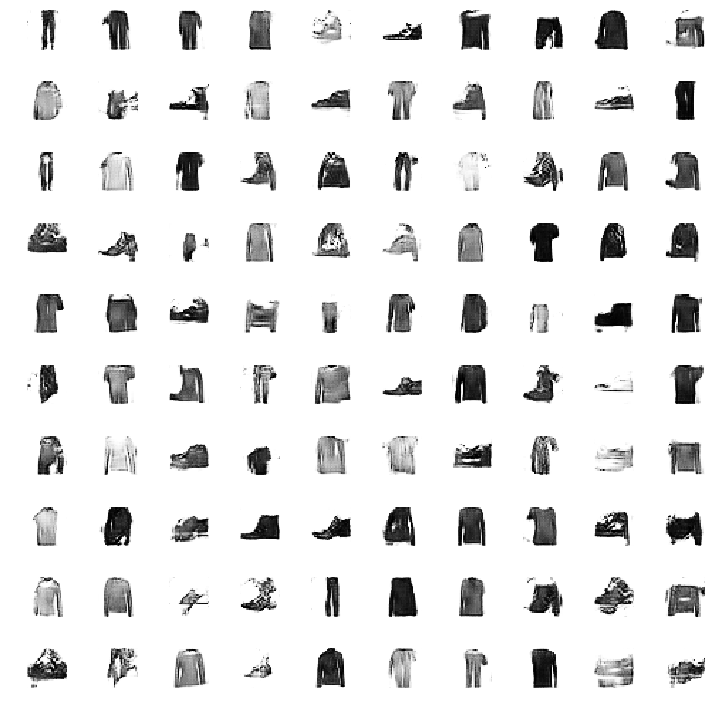

>Saved: generated_plot_0031.png and model_0031.h5
>31, 1/468, d1=-921.604, d2=836.906 g=-786.706
>31, 2/468, d1=-949.420, d2=837.983 g=-811.005
>31, 3/468, d1=-930.409, d2=840.132 g=-773.601
>31, 4/468, d1=-920.144, d2=790.463 g=-882.457
>31, 5/468, d1=-918.161, d2=818.253 g=-750.449
>31, 6/468, d1=-931.608, d2=854.784 g=-778.516
>31, 7/468, d1=-935.458, d2=851.288 g=-752.699
>31, 8/468, d1=-922.643, d2=859.585 g=-775.338
>31, 9/468, d1=-947.142, d2=858.086 g=-773.527
>31, 10/468, d1=-928.005, d2=861.708 g=-777.474
>31, 11/468, d1=-942.594, d2=862.476 g=-753.453
>31, 12/468, d1=-947.268, d2=853.947 g=-715.209
>31, 13/468, d1=-946.044, d2=862.346 g=-729.179
>31, 14/468, d1=-944.695, d2=867.305 g=-748.141
>31, 15/468, d1=-950.621, d2=862.802 g=-763.389
>31, 16/468, d1=-946.222, d2=837.029 g=-788.686
>31, 17/468, d1=-942.681, d2=858.071 g=-795.849
>31, 18/468, d1=-925.098, d2=844.851 g=-779.139
>31, 19/468, d1=-946.131, d2=839.704 g=-780.238
>31, 20/468, d1=-928.045, d2=831.630 g=-770.511

>31, 171/468, d1=-944.322, d2=854.360 g=-788.960
>31, 172/468, d1=-928.556, d2=846.671 g=-789.942
>31, 173/468, d1=-922.297, d2=855.845 g=-775.307
>31, 174/468, d1=-901.166, d2=866.100 g=-732.445
>31, 175/468, d1=-900.291, d2=832.172 g=-761.152
>31, 176/468, d1=-904.426, d2=844.000 g=-758.742
>31, 177/468, d1=-928.110, d2=838.261 g=-752.351
>31, 178/468, d1=-906.032, d2=837.238 g=-733.795
>31, 179/468, d1=-914.278, d2=848.241 g=-738.489
>31, 180/468, d1=-910.528, d2=851.712 g=-738.094
>31, 181/468, d1=-913.487, d2=847.656 g=-742.463
>31, 182/468, d1=-904.636, d2=838.266 g=-738.821
>31, 183/468, d1=-893.800, d2=828.486 g=-704.785
>31, 184/468, d1=-902.490, d2=825.126 g=-718.781
>31, 185/468, d1=-909.912, d2=824.850 g=-725.977
>31, 186/468, d1=-890.408, d2=832.154 g=-712.081
>31, 187/468, d1=-905.147, d2=822.827 g=-725.708
>31, 188/468, d1=-900.935, d2=821.501 g=-707.517
>31, 189/468, d1=-891.374, d2=828.181 g=-732.099
>31, 190/468, d1=-887.214, d2=813.532 g=-695.830
>31, 191/468, d1=-88

>31, 341/468, d1=-865.230, d2=768.761 g=-735.651
>31, 342/468, d1=-854.303, d2=772.734 g=-749.818
>31, 343/468, d1=-882.271, d2=776.918 g=-761.954
>31, 344/468, d1=-854.731, d2=775.846 g=-776.326
>31, 345/468, d1=-871.016, d2=803.821 g=-764.167
>31, 346/468, d1=-877.667, d2=793.062 g=-710.364
>31, 347/468, d1=-889.706, d2=808.833 g=-717.735
>31, 348/468, d1=-877.992, d2=791.941 g=-692.636
>31, 349/468, d1=-862.103, d2=795.906 g=-662.786
>31, 350/468, d1=-879.413, d2=828.367 g=-689.870
>31, 351/468, d1=-863.597, d2=815.145 g=-697.298
>31, 352/468, d1=-873.247, d2=806.788 g=-712.148
>31, 353/468, d1=-889.447, d2=803.823 g=-720.664
>31, 354/468, d1=-880.734, d2=798.480 g=-728.059
>31, 355/468, d1=-864.078, d2=800.908 g=-717.909
>31, 356/468, d1=-861.118, d2=794.786 g=-724.371
>31, 357/468, d1=-865.419, d2=807.451 g=-720.364
>31, 358/468, d1=-886.217, d2=797.271 g=-710.461
>31, 359/468, d1=-875.522, d2=795.388 g=-741.628
>31, 360/468, d1=-869.450, d2=789.223 g=-706.575
>31, 361/468, d1=-88

>32, 41/468, d1=-1371.473, d2=1377.996 g=-1277.264
>32, 42/468, d1=-1389.171, d2=1369.748 g=-1297.006
>32, 43/468, d1=-1394.625, d2=1381.413 g=-1319.619
>32, 44/468, d1=-1370.927, d2=1370.081 g=-1311.717
>32, 45/468, d1=-1388.646, d2=1346.652 g=-1334.255
>32, 46/468, d1=-1398.641, d2=1354.821 g=-1313.408
>32, 47/468, d1=-1389.692, d2=1348.907 g=-1324.264
>32, 48/468, d1=-1397.715, d2=1316.072 g=-1382.763
>32, 49/468, d1=-1395.819, d2=1322.615 g=-1432.707
>32, 50/468, d1=-1407.211, d2=1303.722 g=-1486.360
>32, 51/468, d1=-1394.497, d2=1336.041 g=-1509.788
>32, 52/468, d1=-1380.204, d2=1302.706 g=-1530.699
>32, 53/468, d1=-1358.519, d2=1342.506 g=-1469.712
>32, 54/468, d1=-1401.313, d2=1307.827 g=-1507.677
>32, 55/468, d1=-1365.838, d2=1300.981 g=-1520.603
>32, 56/468, d1=-1378.699, d2=1330.791 g=-1472.572
>32, 57/468, d1=-1396.282, d2=1317.721 g=-1478.226
>32, 58/468, d1=-1381.103, d2=1324.742 g=-1472.362
>32, 59/468, d1=-1356.733, d2=1327.321 g=-1487.045
>32, 60/468, d1=-1369.307, d2=1

>32, 200/468, d1=-1183.730, d2=1134.178 g=-1055.669
>32, 201/468, d1=-1194.980, d2=1141.336 g=-1104.094
>32, 202/468, d1=-1181.000, d2=1137.518 g=-1032.223
>32, 203/468, d1=-1176.968, d2=1144.101 g=-1091.746
>32, 204/468, d1=-1186.693, d2=1146.891 g=-1069.092
>32, 205/468, d1=-1201.847, d2=1143.154 g=-1110.811
>32, 206/468, d1=-1186.751, d2=1133.638 g=-1144.471
>32, 207/468, d1=-1195.059, d2=1145.023 g=-1115.650
>32, 208/468, d1=-1217.983, d2=1130.312 g=-1135.309
>32, 209/468, d1=-1165.460, d2=1141.660 g=-1061.580
>32, 210/468, d1=-1198.876, d2=1149.225 g=-1099.746
>32, 211/468, d1=-1215.384, d2=1135.340 g=-1125.796
>32, 212/468, d1=-1205.534, d2=1149.094 g=-1120.104
>32, 213/468, d1=-1214.766, d2=1148.599 g=-1170.286
>32, 214/468, d1=-1175.480, d2=1161.938 g=-1024.823
>32, 215/468, d1=-1204.185, d2=1145.439 g=-1071.942
>32, 216/468, d1=-1205.471, d2=1138.232 g=-1031.274
>32, 217/468, d1=-1194.594, d2=1158.610 g=-1071.871
>32, 218/468, d1=-1185.767, d2=1148.770 g=-1030.771
>32, 219/468

>32, 360/468, d1=-1362.406, d2=1281.053 g=-1088.213
>32, 361/468, d1=-1342.692, d2=1280.179 g=-1106.029
>32, 362/468, d1=-1365.662, d2=1286.677 g=-1112.282
>32, 363/468, d1=-1370.691, d2=1275.311 g=-1175.136
>32, 364/468, d1=-1369.529, d2=1298.982 g=-1137.532
>32, 365/468, d1=-1413.612, d2=1301.882 g=-1155.318
>32, 366/468, d1=-1416.032, d2=1266.756 g=-1264.606
>32, 367/468, d1=-1403.430, d2=1261.006 g=-1327.461
>32, 368/468, d1=-1397.937, d2=1277.929 g=-1382.257
>32, 369/468, d1=-1427.477, d2=1308.298 g=-1419.195
>32, 370/468, d1=-1422.917, d2=1289.542 g=-1437.113
>32, 371/468, d1=-1423.924, d2=1330.326 g=-1461.580
>32, 372/468, d1=-1466.329, d2=1348.112 g=-1557.325
>32, 373/468, d1=-1388.643, d2=1372.929 g=-1454.008
>32, 374/468, d1=-1406.677, d2=1364.656 g=-1411.399
>32, 375/468, d1=-1408.326, d2=1377.345 g=-1385.304
>32, 376/468, d1=-1416.447, d2=1354.214 g=-1358.311
>32, 377/468, d1=-1444.317, d2=1388.312 g=-1361.696
>32, 378/468, d1=-1397.083, d2=1351.829 g=-1340.300
>32, 379/468

>33, 53/468, d1=-1220.741, d2=1152.174 g=-1111.108
>33, 54/468, d1=-1209.975, d2=1113.203 g=-1119.166
>33, 55/468, d1=-1194.722, d2=1105.899 g=-1081.240
>33, 56/468, d1=-1181.431, d2=1093.983 g=-1060.524
>33, 57/468, d1=-1161.587, d2=1097.536 g=-1056.885
>33, 58/468, d1=-1171.197, d2=1121.085 g=-1130.451
>33, 59/468, d1=-1188.863, d2=1133.715 g=-1109.712
>33, 60/468, d1=-1186.598, d2=1141.819 g=-1126.265
>33, 61/468, d1=-1229.298, d2=1176.309 g=-1162.067
>33, 62/468, d1=-1217.573, d2=1191.135 g=-1192.902
>33, 63/468, d1=-1264.734, d2=1212.313 g=-1195.035
>33, 64/468, d1=-1291.406, d2=1216.988 g=-1220.164
>33, 65/468, d1=-1287.717, d2=1210.174 g=-1245.965
>33, 66/468, d1=-1304.158, d2=1251.891 g=-1238.921
>33, 67/468, d1=-1274.046, d2=1236.697 g=-1061.555
>33, 68/468, d1=-1275.477, d2=1231.108 g=-1127.610
>33, 69/468, d1=-1292.732, d2=1233.352 g=-1151.280
>33, 70/468, d1=-1289.635, d2=1222.685 g=-1126.134
>33, 71/468, d1=-1290.081, d2=1222.357 g=-1113.663
>33, 72/468, d1=-1270.224, d2=1

>33, 213/468, d1=-1248.036, d2=1179.638 g=-1081.817
>33, 214/468, d1=-1244.074, d2=1173.350 g=-1097.110
>33, 215/468, d1=-1254.681, d2=1174.749 g=-1078.028
>33, 216/468, d1=-1236.937, d2=1173.893 g=-1120.013
>33, 217/468, d1=-1234.252, d2=1167.773 g=-1136.742
>33, 218/468, d1=-1240.597, d2=1165.155 g=-1130.520
>33, 219/468, d1=-1255.946, d2=1159.772 g=-1151.637
>33, 220/468, d1=-1233.277, d2=1160.532 g=-1147.259
>33, 221/468, d1=-1223.617, d2=1165.763 g=-1130.780
>33, 222/468, d1=-1218.441, d2=1156.980 g=-1108.552
>33, 223/468, d1=-1212.888, d2=1157.492 g=-1089.590
>33, 224/468, d1=-1220.289, d2=1146.505 g=-1079.319
>33, 225/468, d1=-1208.523, d2=1153.098 g=-1089.094
>33, 226/468, d1=-1192.524, d2=1158.492 g=-1104.347
>33, 227/468, d1=-1216.549, d2=1134.759 g=-1125.469
>33, 228/468, d1=-1201.596, d2=1125.507 g=-1136.615
>33, 229/468, d1=-1212.324, d2=1132.544 g=-1152.819
>33, 230/468, d1=-1210.958, d2=1156.465 g=-1103.541
>33, 231/468, d1=-1207.041, d2=1146.654 g=-1110.037
>33, 232/468

>33, 374/468, d1=-1245.227, d2=1179.273 g=-997.004
>33, 375/468, d1=-1258.404, d2=1187.454 g=-972.378
>33, 376/468, d1=-1239.248, d2=1189.447 g=-1013.159
>33, 377/468, d1=-1265.855, d2=1215.953 g=-1048.626
>33, 378/468, d1=-1277.864, d2=1232.068 g=-1082.258
>33, 379/468, d1=-1258.130, d2=1225.335 g=-1091.191
>33, 380/468, d1=-1300.180, d2=1224.256 g=-1112.989
>33, 381/468, d1=-1288.707, d2=1220.511 g=-1115.373
>33, 382/468, d1=-1280.056, d2=1219.409 g=-1150.303
>33, 383/468, d1=-1300.185, d2=1237.958 g=-1168.039
>33, 384/468, d1=-1326.779, d2=1244.393 g=-1193.845
>33, 385/468, d1=-1311.685, d2=1248.423 g=-1230.892
>33, 386/468, d1=-1301.672, d2=1247.980 g=-1201.078
>33, 387/468, d1=-1301.414, d2=1216.693 g=-1259.470
>33, 388/468, d1=-1288.735, d2=1213.623 g=-1279.690
>33, 389/468, d1=-1321.086, d2=1232.870 g=-1248.687
>33, 390/468, d1=-1307.603, d2=1233.736 g=-1189.175
>33, 391/468, d1=-1278.104, d2=1228.230 g=-1252.842
>33, 392/468, d1=-1304.387, d2=1265.487 g=-1236.714
>33, 393/468, 

>34, 67/468, d1=-1294.597, d2=1201.370 g=-1318.246
>34, 68/468, d1=-1316.377, d2=1244.559 g=-1299.848
>34, 69/468, d1=-1295.875, d2=1211.505 g=-1244.002
>34, 70/468, d1=-1282.847, d2=1208.962 g=-1280.197
>34, 71/468, d1=-1261.579, d2=1189.340 g=-1327.033
>34, 72/468, d1=-1283.130, d2=1228.177 g=-1067.821
>34, 73/468, d1=-1292.442, d2=1225.610 g=-1086.620
>34, 74/468, d1=-1294.881, d2=1221.348 g=-1036.396
>34, 75/468, d1=-1276.222, d2=1205.458 g=-1058.721
>34, 76/468, d1=-1278.737, d2=1223.203 g=-1042.360
>34, 77/468, d1=-1286.400, d2=1201.990 g=-1056.329
>34, 78/468, d1=-1268.894, d2=1185.240 g=-1071.572
>34, 79/468, d1=-1278.632, d2=1210.000 g=-1059.292
>34, 80/468, d1=-1254.847, d2=1194.119 g=-1102.451
>34, 81/468, d1=-1267.156, d2=1183.187 g=-1114.053
>34, 82/468, d1=-1252.468, d2=1175.302 g=-1113.366
>34, 83/468, d1=-1239.690, d2=1194.779 g=-1161.309
>34, 84/468, d1=-1258.201, d2=1197.844 g=-1160.039
>34, 85/468, d1=-1253.691, d2=1222.811 g=-1154.490
>34, 86/468, d1=-1281.212, d2=1

>34, 227/468, d1=-1147.835, d2=1072.770 g=-1024.768
>34, 228/468, d1=-1150.862, d2=1095.555 g=-996.065
>34, 229/468, d1=-1137.838, d2=1082.521 g=-995.485
>34, 230/468, d1=-1123.357, d2=1076.376 g=-1014.203
>34, 231/468, d1=-1142.105, d2=1082.697 g=-1005.408
>34, 232/468, d1=-1149.591, d2=1095.404 g=-1013.950
>34, 233/468, d1=-1133.273, d2=1097.016 g=-1014.748
>34, 234/468, d1=-1140.034, d2=1085.769 g=-1015.045
>34, 235/468, d1=-1161.226, d2=1085.123 g=-1043.694
>34, 236/468, d1=-1137.146, d2=1089.985 g=-973.127
>34, 237/468, d1=-1150.541, d2=1089.377 g=-953.065
>34, 238/468, d1=-1154.773, d2=1095.873 g=-963.449
>34, 239/468, d1=-1144.088, d2=1093.537 g=-988.183
>34, 240/468, d1=-1151.798, d2=1097.522 g=-984.780
>34, 241/468, d1=-1159.905, d2=1098.875 g=-1007.693
>34, 242/468, d1=-1160.642, d2=1101.969 g=-1007.996
>34, 243/468, d1=-1156.956, d2=1103.008 g=-999.236
>34, 244/468, d1=-1158.046, d2=1098.296 g=-1006.053
>34, 245/468, d1=-1165.340, d2=1103.119 g=-1015.939
>34, 246/468, d1=-11

>34, 386/468, d1=-1175.355, d2=1118.075 g=-1018.126
>34, 387/468, d1=-1192.553, d2=1117.234 g=-1021.156
>34, 388/468, d1=-1187.677, d2=1119.162 g=-1060.397
>34, 389/468, d1=-1187.963, d2=1118.047 g=-1076.952
>34, 390/468, d1=-1188.999, d2=1117.533 g=-1079.393
>34, 391/468, d1=-1192.642, d2=1108.219 g=-1107.934
>34, 392/468, d1=-1206.352, d2=1110.285 g=-1134.236
>34, 393/468, d1=-1178.339, d2=1120.846 g=-1103.682
>34, 394/468, d1=-1200.753, d2=1113.871 g=-1104.646
>34, 395/468, d1=-1183.053, d2=1115.125 g=-1108.153
>34, 396/468, d1=-1175.835, d2=1110.067 g=-1113.041
>34, 397/468, d1=-1186.336, d2=1104.200 g=-1113.001
>34, 398/468, d1=-1163.721, d2=1114.487 g=-1077.770
>34, 399/468, d1=-1173.865, d2=1121.712 g=-1022.642
>34, 400/468, d1=-1190.824, d2=1113.223 g=-1064.392
>34, 401/468, d1=-1181.551, d2=1115.911 g=-1060.960
>34, 402/468, d1=-1191.370, d2=1111.043 g=-1077.984
>34, 403/468, d1=-1176.641, d2=1108.036 g=-1098.908
>34, 404/468, d1=-1167.417, d2=1099.920 g=-1071.724
>34, 405/468

>35, 81/468, d1=-1154.262, d2=1134.933 g=-1196.139
>35, 82/468, d1=-1218.404, d2=1130.706 g=-1242.964
>35, 83/468, d1=-1253.095, d2=1163.347 g=-1311.811
>35, 84/468, d1=-1274.930, d2=1160.330 g=-1384.584
>35, 85/468, d1=-1288.910, d2=1194.958 g=-1388.683
>35, 86/468, d1=-1326.644, d2=1211.872 g=-1417.963
>35, 87/468, d1=-1257.818, d2=1200.831 g=-1426.378
>35, 88/468, d1=-1303.476, d2=1240.899 g=-1341.609
>35, 89/468, d1=-1292.409, d2=1216.987 g=-1336.453
>35, 90/468, d1=-1251.946, d2=1210.226 g=-1296.146
>35, 91/468, d1=-1241.810, d2=1180.109 g=-1203.866
>35, 92/468, d1=-1241.764, d2=1167.454 g=-1084.401
>35, 93/468, d1=-1254.565, d2=1154.193 g=-1237.883
>35, 94/468, d1=-1272.296, d2=1162.781 g=-1166.113
>35, 95/468, d1=-1236.561, d2=1140.717 g=-1101.523
>35, 96/468, d1=-1243.998, d2=1149.599 g=-1099.881
>35, 97/468, d1=-1212.801, d2=1170.044 g=-1041.772
>35, 98/468, d1=-1241.012, d2=1151.139 g=-1029.522
>35, 99/468, d1=-1232.205, d2=1147.851 g=-967.108
>35, 100/468, d1=-1245.025, d2=1

>35, 241/468, d1=-1281.124, d2=1229.499 g=-1074.587
>35, 242/468, d1=-1270.802, d2=1212.782 g=-1125.398
>35, 243/468, d1=-1277.046, d2=1229.992 g=-1092.619
>35, 244/468, d1=-1273.459, d2=1229.641 g=-1083.855
>35, 245/468, d1=-1278.646, d2=1223.407 g=-1113.037
>35, 246/468, d1=-1276.302, d2=1227.380 g=-1129.468
>35, 247/468, d1=-1281.786, d2=1239.547 g=-1130.790
>35, 248/468, d1=-1285.676, d2=1237.300 g=-1087.200
>35, 249/468, d1=-1272.668, d2=1241.072 g=-1119.166
>35, 250/468, d1=-1279.524, d2=1219.771 g=-1119.729
>35, 251/468, d1=-1285.026, d2=1223.483 g=-1131.422
>35, 252/468, d1=-1266.265, d2=1229.778 g=-1139.440
>35, 253/468, d1=-1281.966, d2=1236.081 g=-1104.740
>35, 254/468, d1=-1273.713, d2=1229.718 g=-1133.151
>35, 255/468, d1=-1273.680, d2=1206.783 g=-1173.616
>35, 256/468, d1=-1274.558, d2=1195.146 g=-1184.225
>35, 257/468, d1=-1279.464, d2=1183.264 g=-1232.043
>35, 258/468, d1=-1244.156, d2=1195.694 g=-1217.073
>35, 259/468, d1=-1269.645, d2=1193.592 g=-1254.223
>35, 260/468

>35, 401/468, d1=-1302.033, d2=1250.778 g=-1139.964
>35, 402/468, d1=-1297.416, d2=1248.357 g=-1083.013
>35, 403/468, d1=-1295.990, d2=1251.804 g=-1113.146
>35, 404/468, d1=-1291.384, d2=1255.783 g=-1175.234
>35, 405/468, d1=-1313.887, d2=1261.071 g=-1182.554
>35, 406/468, d1=-1308.191, d2=1256.609 g=-1182.938
>35, 407/468, d1=-1298.068, d2=1239.602 g=-1174.584
>35, 408/468, d1=-1310.024, d2=1231.954 g=-1154.339
>35, 409/468, d1=-1295.859, d2=1254.431 g=-1194.764
>35, 410/468, d1=-1300.469, d2=1265.370 g=-1212.352
>35, 411/468, d1=-1317.045, d2=1263.673 g=-1176.514
>35, 412/468, d1=-1308.191, d2=1276.364 g=-1186.333
>35, 413/468, d1=-1284.355, d2=1255.636 g=-1166.928
>35, 414/468, d1=-1306.227, d2=1258.421 g=-1167.186
>35, 415/468, d1=-1293.028, d2=1254.416 g=-1143.937
>35, 416/468, d1=-1287.238, d2=1245.021 g=-1166.459
>35, 417/468, d1=-1281.613, d2=1240.331 g=-1166.782
>35, 418/468, d1=-1288.725, d2=1250.075 g=-1202.670
>35, 419/468, d1=-1278.345, d2=1221.322 g=-1203.700
>35, 420/468

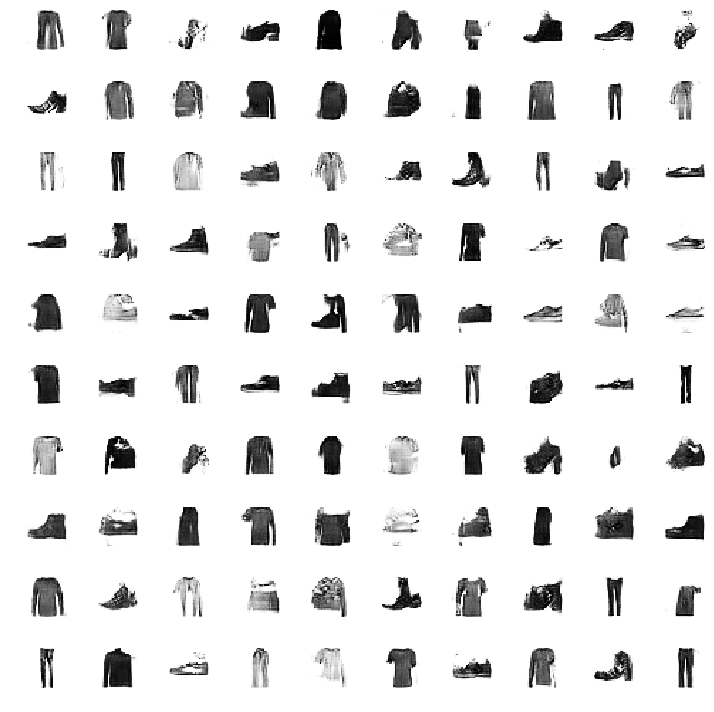

>Saved: generated_plot_0036.png and model_0036.h5
>36, 1/468, d1=-1200.720, d2=1153.483 g=-1096.942
>36, 2/468, d1=-1211.880, d2=1131.083 g=-1039.526
>36, 3/468, d1=-1203.609, d2=1133.324 g=-1093.318
>36, 4/468, d1=-1202.747, d2=1141.546 g=-1092.562
>36, 5/468, d1=-1195.693, d2=1145.169 g=-1082.660
>36, 6/468, d1=-1212.874, d2=1126.064 g=-1110.381
>36, 7/468, d1=-1193.193, d2=1146.359 g=-1099.037
>36, 8/468, d1=-1201.434, d2=1140.850 g=-1111.456
>36, 9/468, d1=-1213.981, d2=1133.664 g=-1135.085
>36, 10/468, d1=-1184.675, d2=1131.079 g=-1088.282
>36, 11/468, d1=-1174.012, d2=1128.984 g=-986.472
>36, 12/468, d1=-1191.644, d2=1138.465 g=-1103.546
>36, 13/468, d1=-1188.241, d2=1123.081 g=-1115.171
>36, 14/468, d1=-1194.799, d2=1134.496 g=-1062.530
>36, 15/468, d1=-1173.980, d2=1110.080 g=-1069.335
>36, 16/468, d1=-1180.360, d2=1121.525 g=-1082.426
>36, 17/468, d1=-1176.949, d2=1120.356 g=-1102.906
>36, 18/468, d1=-1191.460, d2=1135.352 g=-1012.351
>36, 19/468, d1=-1182.810, d2=1133.207 g=-

>36, 163/468, d1=-1389.898, d2=1306.528 g=-1212.004
>36, 164/468, d1=-1352.904, d2=1318.040 g=-1243.740
>36, 165/468, d1=-1351.659, d2=1339.200 g=-1193.855
>36, 166/468, d1=-1347.764, d2=1303.951 g=-1207.446
>36, 167/468, d1=-1331.576, d2=1286.509 g=-1204.645
>36, 168/468, d1=-1322.757, d2=1294.918 g=-1201.983
>36, 169/468, d1=-1337.342, d2=1286.458 g=-1222.627
>36, 170/468, d1=-1346.132, d2=1295.007 g=-1193.222
>36, 171/468, d1=-1334.297, d2=1275.489 g=-1186.454
>36, 172/468, d1=-1316.291, d2=1272.278 g=-1176.390
>36, 173/468, d1=-1307.718, d2=1272.893 g=-1185.189
>36, 174/468, d1=-1315.188, d2=1265.490 g=-1184.704
>36, 175/468, d1=-1308.517, d2=1275.524 g=-1195.343
>36, 176/468, d1=-1307.768, d2=1266.719 g=-1212.106
>36, 177/468, d1=-1301.984, d2=1265.638 g=-1190.418
>36, 178/468, d1=-1293.796, d2=1243.830 g=-1197.202
>36, 179/468, d1=-1292.743, d2=1239.065 g=-1188.828
>36, 180/468, d1=-1283.492, d2=1231.030 g=-1210.812
>36, 181/468, d1=-1280.945, d2=1222.400 g=-1199.167
>36, 182/468

>36, 323/468, d1=-1326.680, d2=1276.420 g=-1283.437
>36, 324/468, d1=-1325.725, d2=1260.335 g=-1222.216
>36, 325/468, d1=-1319.774, d2=1276.749 g=-1229.845
>36, 326/468, d1=-1312.839, d2=1249.552 g=-1179.722
>36, 327/468, d1=-1292.311, d2=1259.439 g=-1142.800
>36, 328/468, d1=-1320.478, d2=1260.355 g=-1182.680
>36, 329/468, d1=-1303.475, d2=1269.899 g=-1120.166
>36, 330/468, d1=-1309.576, d2=1269.754 g=-1143.006
>36, 331/468, d1=-1311.502, d2=1240.661 g=-1146.138
>36, 332/468, d1=-1287.891, d2=1250.086 g=-1148.455
>36, 333/468, d1=-1316.250, d2=1243.856 g=-1174.437
>36, 334/468, d1=-1308.054, d2=1237.323 g=-1160.763
>36, 335/468, d1=-1278.516, d2=1221.911 g=-1176.208
>36, 336/468, d1=-1274.837, d2=1217.088 g=-1200.849
>36, 337/468, d1=-1275.988, d2=1221.761 g=-1180.117
>36, 338/468, d1=-1277.920, d2=1202.505 g=-1217.239
>36, 339/468, d1=-1278.312, d2=1200.592 g=-1229.706
>36, 340/468, d1=-1298.642, d2=1213.852 g=-1198.043
>36, 341/468, d1=-1257.085, d2=1205.945 g=-1188.485
>36, 342/468

>37, 15/468, d1=-1144.359, d2=1082.572 g=-1050.622
>37, 16/468, d1=-1143.126, d2=1072.219 g=-1107.172
>37, 17/468, d1=-1148.047, d2=1075.376 g=-1031.478
>37, 18/468, d1=-1161.488, d2=1083.533 g=-1034.191
>37, 19/468, d1=-1160.345, d2=1100.351 g=-1044.355
>37, 20/468, d1=-1148.448, d2=1093.506 g=-1035.939
>37, 21/468, d1=-1157.400, d2=1090.745 g=-988.744
>37, 22/468, d1=-1171.559, d2=1100.211 g=-999.955
>37, 23/468, d1=-1147.703, d2=1097.449 g=-909.563
>37, 24/468, d1=-1169.327, d2=1116.503 g=-992.171
>37, 25/468, d1=-1174.797, d2=1107.529 g=-973.354
>37, 26/468, d1=-1166.075, d2=1114.430 g=-983.929
>37, 27/468, d1=-1161.397, d2=1107.384 g=-989.524
>37, 28/468, d1=-1158.685, d2=1089.704 g=-1001.275
>37, 29/468, d1=-1166.574, d2=1096.958 g=-1002.414
>37, 30/468, d1=-1138.292, d2=1088.833 g=-1026.966
>37, 31/468, d1=-1149.545, d2=1108.636 g=-1003.221
>37, 32/468, d1=-1160.231, d2=1096.519 g=-1038.516
>37, 33/468, d1=-1176.575, d2=1107.597 g=-1035.087
>37, 34/468, d1=-1154.633, d2=1098.055

>37, 176/468, d1=-1144.406, d2=1097.419 g=-1019.519
>37, 177/468, d1=-1153.470, d2=1100.244 g=-1034.045
>37, 178/468, d1=-1152.485, d2=1086.587 g=-1032.811
>37, 179/468, d1=-1118.310, d2=1095.893 g=-1042.091
>37, 180/468, d1=-1146.187, d2=1085.435 g=-1033.926
>37, 181/468, d1=-1148.866, d2=1072.960 g=-1010.641
>37, 182/468, d1=-1150.511, d2=1080.481 g=-1024.949
>37, 183/468, d1=-1126.496, d2=1087.682 g=-1032.782
>37, 184/468, d1=-1136.127, d2=1078.105 g=-1023.973
>37, 185/468, d1=-1139.342, d2=1074.166 g=-1039.595
>37, 186/468, d1=-1149.311, d2=1076.623 g=-1069.874
>37, 187/468, d1=-1121.006, d2=1082.454 g=-995.648
>37, 188/468, d1=-1130.549, d2=1072.671 g=-1026.434
>37, 189/468, d1=-1142.754, d2=1067.763 g=-1026.402
>37, 190/468, d1=-1120.923, d2=1071.596 g=-965.257
>37, 191/468, d1=-1124.371, d2=1071.746 g=-1000.915
>37, 192/468, d1=-1130.517, d2=1089.645 g=-969.037
>37, 193/468, d1=-1133.442, d2=1085.306 g=-980.160
>37, 194/468, d1=-1128.932, d2=1081.030 g=-988.697
>37, 195/468, d1=

>37, 336/468, d1=-1319.152, d2=1299.214 g=-1262.510
>37, 337/468, d1=-1447.905, d2=1310.975 g=-1333.292
>37, 338/468, d1=-1398.168, d2=1373.139 g=-1368.119
>37, 339/468, d1=-1395.182, d2=1314.791 g=-1386.634
>37, 340/468, d1=-1410.648, d2=1336.101 g=-1384.821
>37, 341/468, d1=-1479.150, d2=1402.979 g=-1431.207
>37, 342/468, d1=-1445.084, d2=1379.924 g=-1378.977
>37, 343/468, d1=-1428.599, d2=1313.484 g=-1460.605
>37, 344/468, d1=-1467.588, d2=1336.408 g=-1514.446
>37, 345/468, d1=-1414.530, d2=1376.848 g=-1514.659
>37, 346/468, d1=-1422.984, d2=1322.545 g=-1538.900
>37, 347/468, d1=-1388.264, d2=1396.477 g=-1417.517
>37, 348/468, d1=-1395.255, d2=1339.263 g=-1375.258
>37, 349/468, d1=-1397.039, d2=1361.088 g=-1303.066
>37, 350/468, d1=-1372.782, d2=1348.579 g=-1222.281
>37, 351/468, d1=-1386.984, d2=1336.725 g=-1224.740
>37, 352/468, d1=-1369.715, d2=1304.586 g=-1172.293
>37, 353/468, d1=-1365.683, d2=1320.788 g=-1197.574
>37, 354/468, d1=-1384.213, d2=1315.664 g=-1138.823
>37, 355/468

>38, 27/468, d1=-1075.609, d2=925.499 g=-796.870
>38, 28/468, d1=-1123.814, d2=912.236 g=-709.668
>38, 29/468, d1=-1049.094, d2=898.437 g=-777.155
>38, 30/468, d1=-1064.316, d2=961.807 g=-858.674
>38, 31/468, d1=-1085.489, d2=1069.279 g=-1052.375
>38, 32/468, d1=-1137.801, d2=1126.012 g=-1169.886
>38, 33/468, d1=-1154.775, d2=1234.096 g=-1128.272
>38, 34/468, d1=-1244.904, d2=1237.656 g=-1134.935
>38, 35/468, d1=-1352.249, d2=1262.240 g=-990.020
>38, 36/468, d1=-1473.270, d2=1299.429 g=-914.174
>38, 37/468, d1=-1513.025, d2=1354.073 g=-1011.027
>38, 38/468, d1=-1520.063, d2=1402.125 g=-1156.794
>38, 39/468, d1=-1496.093, d2=1441.252 g=-1336.394
>38, 40/468, d1=-1481.684, d2=1409.832 g=-1399.375
>38, 41/468, d1=-1434.288, d2=1419.906 g=-1375.073
>38, 42/468, d1=-1438.111, d2=1311.178 g=-1426.879
>38, 43/468, d1=-1409.911, d2=1365.494 g=-1334.533
>38, 44/468, d1=-1378.948, d2=1306.239 g=-1387.877
>38, 45/468, d1=-1374.060, d2=1290.640 g=-1312.535
>38, 46/468, d1=-1305.749, d2=1249.430 g=

>38, 188/468, d1=-1125.610, d2=1014.402 g=-972.859
>38, 189/468, d1=-1136.730, d2=1061.573 g=-987.229
>38, 190/468, d1=-1125.179, d2=1086.521 g=-1052.719
>38, 191/468, d1=-1136.981, d2=1095.961 g=-1075.299
>38, 192/468, d1=-1135.293, d2=1134.613 g=-1073.788
>38, 193/468, d1=-1161.387, d2=1137.311 g=-1105.129
>38, 194/468, d1=-1183.063, d2=1174.274 g=-1110.958
>38, 195/468, d1=-1211.344, d2=1179.551 g=-1150.191
>38, 196/468, d1=-1267.114, d2=1158.835 g=-1257.458
>38, 197/468, d1=-1280.316, d2=1213.009 g=-1314.043
>38, 198/468, d1=-1258.273, d2=1167.129 g=-1331.613
>38, 199/468, d1=-1250.152, d2=1156.190 g=-1362.429
>38, 200/468, d1=-1243.313, d2=1172.314 g=-1334.911
>38, 201/468, d1=-1222.626, d2=1162.513 g=-1286.409
>38, 202/468, d1=-1216.386, d2=1146.894 g=-1283.270
>38, 203/468, d1=-1226.580, d2=1119.848 g=-1298.123
>38, 204/468, d1=-1289.673, d2=1128.569 g=-1365.739
>38, 205/468, d1=-1234.624, d2=1153.213 g=-1309.820
>38, 206/468, d1=-1203.507, d2=1138.323 g=-1172.669
>38, 207/468, 

>38, 348/468, d1=-1191.303, d2=1025.118 g=-1113.776
>38, 349/468, d1=-1177.657, d2=1021.011 g=-1080.500
>38, 350/468, d1=-1140.812, d2=1008.102 g=-1020.819
>38, 351/468, d1=-1132.217, d2=1016.656 g=-963.010
>38, 352/468, d1=-1119.332, d2=1022.494 g=-1016.224
>38, 353/468, d1=-1134.210, d2=1028.405 g=-948.922
>38, 354/468, d1=-1155.157, d2=1030.366 g=-997.802
>38, 355/468, d1=-1146.778, d2=1073.184 g=-1072.519
>38, 356/468, d1=-1177.742, d2=1118.001 g=-1079.549
>38, 357/468, d1=-1154.250, d2=1136.593 g=-1120.032
>38, 358/468, d1=-1197.611, d2=1216.911 g=-1170.216
>38, 359/468, d1=-1205.964, d2=1216.383 g=-1158.775
>38, 360/468, d1=-1226.113, d2=1255.292 g=-1154.623
>38, 361/468, d1=-1256.083, d2=1274.827 g=-1127.041
>38, 362/468, d1=-1289.301, d2=1281.019 g=-1166.978
>38, 363/468, d1=-1309.725, d2=1251.234 g=-1237.470
>38, 364/468, d1=-1314.710, d2=1244.036 g=-1267.452
>38, 365/468, d1=-1369.732, d2=1289.374 g=-1288.407
>38, 366/468, d1=-1347.286, d2=1260.983 g=-1319.590
>38, 367/468, d

>39, 40/468, d1=-1212.845, d2=1168.068 g=-1062.207
>39, 41/468, d1=-1222.384, d2=1151.916 g=-1078.208
>39, 42/468, d1=-1211.455, d2=1140.490 g=-1088.408
>39, 43/468, d1=-1210.400, d2=1126.157 g=-1111.689
>39, 44/468, d1=-1204.513, d2=1132.398 g=-1136.914
>39, 45/468, d1=-1207.731, d2=1164.679 g=-1097.565
>39, 46/468, d1=-1228.650, d2=1162.650 g=-1110.861
>39, 47/468, d1=-1201.143, d2=1167.993 g=-1107.776
>39, 48/468, d1=-1203.621, d2=1129.875 g=-1118.115
>39, 49/468, d1=-1217.321, d2=1154.216 g=-1105.881
>39, 50/468, d1=-1196.549, d2=1115.376 g=-1143.217
>39, 51/468, d1=-1170.144, d2=1120.426 g=-1129.922
>39, 52/468, d1=-1193.367, d2=1120.534 g=-1132.712
>39, 53/468, d1=-1207.225, d2=1129.784 g=-1138.488
>39, 54/468, d1=-1186.170, d2=1104.088 g=-1182.988
>39, 55/468, d1=-1216.349, d2=1136.029 g=-1223.973
>39, 56/468, d1=-1201.013, d2=1147.624 g=-1142.921
>39, 57/468, d1=-1187.336, d2=1128.620 g=-1138.243
>39, 58/468, d1=-1195.898, d2=1098.562 g=-1176.387
>39, 59/468, d1=-1190.490, d2=1

>39, 202/468, d1=-1273.272, d2=1219.393 g=-1104.899
>39, 203/468, d1=-1285.683, d2=1227.531 g=-1122.574
>39, 204/468, d1=-1247.998, d2=1229.068 g=-1126.959
>39, 205/468, d1=-1258.782, d2=1214.031 g=-1100.356
>39, 206/468, d1=-1244.483, d2=1198.842 g=-1098.956
>39, 207/468, d1=-1255.443, d2=1197.822 g=-1130.798
>39, 208/468, d1=-1249.302, d2=1195.155 g=-1128.736
>39, 209/468, d1=-1253.526, d2=1181.361 g=-1145.557
>39, 210/468, d1=-1244.016, d2=1194.517 g=-1129.794
>39, 211/468, d1=-1258.049, d2=1196.907 g=-1134.137
>39, 212/468, d1=-1255.312, d2=1197.734 g=-1113.611
>39, 213/468, d1=-1229.662, d2=1184.786 g=-1132.429
>39, 214/468, d1=-1234.467, d2=1172.502 g=-1152.528
>39, 215/468, d1=-1245.754, d2=1148.711 g=-1173.447
>39, 216/468, d1=-1240.908, d2=1167.939 g=-1196.488
>39, 217/468, d1=-1256.540, d2=1145.265 g=-1240.767
>39, 218/468, d1=-1229.934, d2=1159.404 g=-1217.170
>39, 219/468, d1=-1234.021, d2=1163.898 g=-1192.837
>39, 220/468, d1=-1212.930, d2=1166.579 g=-1122.584
>39, 221/468

>39, 362/468, d1=-1195.324, d2=1115.180 g=-1147.348
>39, 363/468, d1=-1208.633, d2=1093.968 g=-1178.179
>39, 364/468, d1=-1200.192, d2=1084.529 g=-1179.224
>39, 365/468, d1=-1222.723, d2=1114.342 g=-1211.724
>39, 366/468, d1=-1221.193, d2=1146.107 g=-1216.369
>39, 367/468, d1=-1215.416, d2=1126.578 g=-1147.880
>39, 368/468, d1=-1254.382, d2=1097.014 g=-1237.212
>39, 369/468, d1=-1199.948, d2=1094.550 g=-1266.422
>39, 370/468, d1=-1205.537, d2=1059.323 g=-1325.507
>39, 371/468, d1=-1200.617, d2=1111.471 g=-1265.856
>39, 372/468, d1=-1206.476, d2=1104.604 g=-1292.918
>39, 373/468, d1=-1209.809, d2=1083.794 g=-1281.296
>39, 374/468, d1=-1225.980, d2=1097.086 g=-1338.467
>39, 375/468, d1=-1173.071, d2=1097.418 g=-1289.743
>39, 376/468, d1=-1199.653, d2=1099.850 g=-1325.318
>39, 377/468, d1=-1196.586, d2=1101.850 g=-1325.389
>39, 378/468, d1=-1233.505, d2=1114.039 g=-1365.430
>39, 379/468, d1=-1156.331, d2=1080.932 g=-1281.235
>39, 380/468, d1=-1181.976, d2=1091.900 g=-1195.407
>39, 381/468

>40, 55/468, d1=-1171.752, d2=1096.668 g=-1157.064
>40, 56/468, d1=-1195.711, d2=1115.503 g=-1157.499
>40, 57/468, d1=-1197.483, d2=1092.703 g=-1210.870
>40, 58/468, d1=-1181.287, d2=1080.332 g=-1209.761
>40, 59/468, d1=-1187.902, d2=1076.991 g=-1204.125
>40, 60/468, d1=-1175.612, d2=1063.435 g=-1225.891
>40, 61/468, d1=-1202.960, d2=1065.176 g=-1302.885
>40, 62/468, d1=-1191.896, d2=1089.055 g=-1238.928
>40, 63/468, d1=-1178.736, d2=1096.407 g=-1192.245
>40, 64/468, d1=-1209.254, d2=1068.819 g=-1246.049
>40, 65/468, d1=-1184.244, d2=1111.189 g=-1132.824
>40, 66/468, d1=-1186.041, d2=1119.057 g=-1143.665
>40, 67/468, d1=-1205.248, d2=1078.705 g=-1146.242
>40, 68/468, d1=-1199.536, d2=1066.851 g=-1186.774
>40, 69/468, d1=-1204.910, d2=1058.883 g=-1232.179
>40, 70/468, d1=-1188.138, d2=1040.247 g=-1073.728
>40, 71/468, d1=-1235.006, d2=1023.415 g=-1022.685
>40, 72/468, d1=-1238.763, d2=994.763 g=-986.302
>40, 73/468, d1=-1244.513, d2=993.406 g=-905.049
>40, 74/468, d1=-1267.879, d2=975.6

>40, 218/468, d1=-1230.143, d2=1149.289 g=-1163.410
>40, 219/468, d1=-1224.639, d2=1159.045 g=-1126.975
>40, 220/468, d1=-1219.995, d2=1152.559 g=-1104.582
>40, 221/468, d1=-1223.232, d2=1151.984 g=-1052.620
>40, 222/468, d1=-1199.444, d2=1147.486 g=-958.066
>40, 223/468, d1=-1217.777, d2=1132.203 g=-811.928
>40, 224/468, d1=-1199.187, d2=1127.600 g=-867.273
>40, 225/468, d1=-1205.884, d2=1135.146 g=-914.066
>40, 226/468, d1=-1216.997, d2=1137.341 g=-930.701
>40, 227/468, d1=-1201.620, d2=1122.610 g=-971.783
>40, 228/468, d1=-1214.057, d2=1124.516 g=-951.242
>40, 229/468, d1=-1221.782, d2=1124.440 g=-957.259
>40, 230/468, d1=-1233.067, d2=1148.896 g=-1007.122
>40, 231/468, d1=-1253.082, d2=1150.138 g=-1014.334
>40, 232/468, d1=-1248.292, d2=1120.995 g=-1031.257
>40, 233/468, d1=-1238.847, d2=1137.474 g=-1100.993
>40, 234/468, d1=-1213.780, d2=1067.856 g=-1142.312
>40, 235/468, d1=-1220.640, d2=1092.608 g=-1175.287
>40, 236/468, d1=-1216.142, d2=1086.557 g=-1234.054
>40, 237/468, d1=-12

>40, 379/468, d1=-1175.075, d2=1104.970 g=-1183.165
>40, 380/468, d1=-1187.370, d2=1141.028 g=-1032.258
>40, 381/468, d1=-1182.718, d2=1114.982 g=-1048.630
>40, 382/468, d1=-1164.463, d2=1107.775 g=-1062.156
>40, 383/468, d1=-1174.070, d2=1114.477 g=-1135.537
>40, 384/468, d1=-1160.355, d2=1109.771 g=-923.195
>40, 385/468, d1=-1153.995, d2=1110.090 g=-900.284
>40, 386/468, d1=-1167.504, d2=1102.312 g=-900.229
>40, 387/468, d1=-1175.060, d2=1122.441 g=-1021.770
>40, 388/468, d1=-1165.683, d2=1127.917 g=-912.729
>40, 389/468, d1=-1196.036, d2=1102.330 g=-936.873
>40, 390/468, d1=-1165.561, d2=1099.543 g=-970.929
>40, 391/468, d1=-1168.631, d2=1106.461 g=-951.457
>40, 392/468, d1=-1173.311, d2=1110.167 g=-993.860
>40, 393/468, d1=-1191.341, d2=1097.533 g=-963.115
>40, 394/468, d1=-1200.625, d2=1070.865 g=-1044.474
>40, 395/468, d1=-1198.357, d2=1080.250 g=-1083.039
>40, 396/468, d1=-1219.851, d2=1061.122 g=-1117.608
>40, 397/468, d1=-1230.138, d2=1056.155 g=-1274.610
>40, 398/468, d1=-120

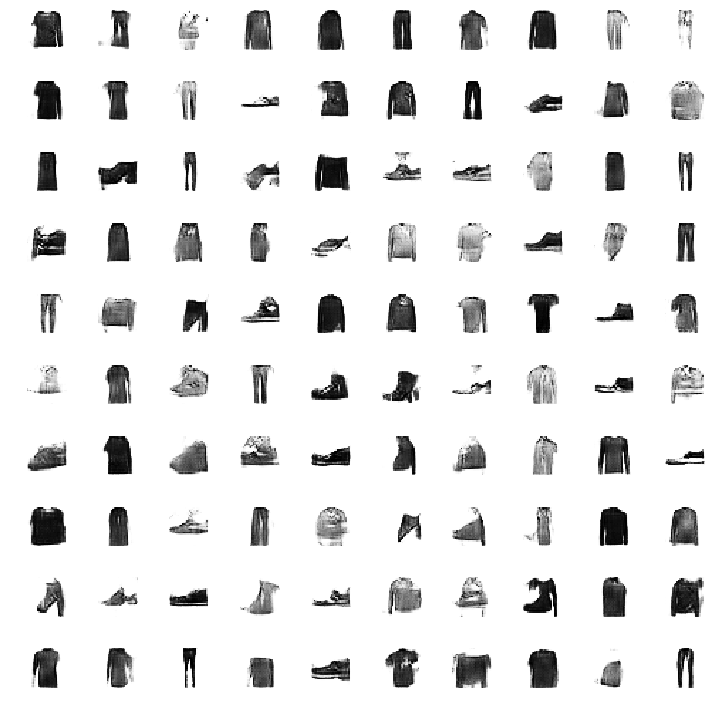

>Saved: generated_plot_0041.png and model_0041.h5
>41, 1/468, d1=-1183.466, d2=1129.616 g=-1144.900
>41, 2/468, d1=-1197.647, d2=1127.607 g=-1136.298
>41, 3/468, d1=-1169.232, d2=1141.923 g=-1231.988
>41, 4/468, d1=-1207.693, d2=1149.726 g=-1191.767
>41, 5/468, d1=-1216.824, d2=1130.075 g=-1278.134
>41, 6/468, d1=-1163.820, d2=1097.982 g=-1136.616
>41, 7/468, d1=-1193.932, d2=1139.109 g=-1161.365
>41, 8/468, d1=-1221.233, d2=1136.766 g=-1237.786
>41, 9/468, d1=-1192.608, d2=1114.447 g=-1074.801
>41, 10/468, d1=-1189.365, d2=1112.850 g=-1068.090
>41, 11/468, d1=-1186.960, d2=1112.746 g=-1075.157
>41, 12/468, d1=-1207.441, d2=1121.286 g=-1002.836
>41, 13/468, d1=-1183.207, d2=1110.744 g=-1022.158
>41, 14/468, d1=-1177.358, d2=1124.167 g=-953.852
>41, 15/468, d1=-1168.676, d2=1103.963 g=-906.661
>41, 16/468, d1=-1170.406, d2=1099.698 g=-975.131
>41, 17/468, d1=-1168.125, d2=1087.948 g=-840.787
>41, 18/468, d1=-1165.179, d2=1088.576 g=-880.980
>41, 19/468, d1=-1174.929, d2=1069.067 g=-865.

>41, 164/468, d1=-1188.272, d2=1113.415 g=-1150.938
>41, 165/468, d1=-1200.004, d2=1092.407 g=-1234.365
>41, 166/468, d1=-1182.213, d2=1068.427 g=-1275.089
>41, 167/468, d1=-1178.312, d2=1100.302 g=-1207.066
>41, 168/468, d1=-1155.040, d2=1100.239 g=-1166.048
>41, 169/468, d1=-1142.519, d2=1079.148 g=-1135.302
>41, 170/468, d1=-1181.397, d2=1104.797 g=-1147.441
>41, 171/468, d1=-1160.254, d2=1089.104 g=-1062.306
>41, 172/468, d1=-1166.290, d2=1079.744 g=-1108.788
>41, 173/468, d1=-1173.464, d2=1092.931 g=-1088.912
>41, 174/468, d1=-1169.262, d2=1075.390 g=-1079.691
>41, 175/468, d1=-1155.085, d2=1110.373 g=-946.521
>41, 176/468, d1=-1158.582, d2=1090.159 g=-977.795
>41, 177/468, d1=-1163.609, d2=1104.707 g=-945.493
>41, 178/468, d1=-1135.799, d2=1085.580 g=-901.186
>41, 179/468, d1=-1150.979, d2=1099.110 g=-951.589
>41, 180/468, d1=-1151.429, d2=1109.953 g=-881.485
>41, 181/468, d1=-1164.409, d2=1083.807 g=-905.932
>41, 182/468, d1=-1170.674, d2=1083.939 g=-942.596
>41, 183/468, d1=-11

>41, 324/468, d1=-1190.331, d2=1109.964 g=-982.849
>41, 325/468, d1=-1170.147, d2=1110.656 g=-1015.164
>41, 326/468, d1=-1180.004, d2=1128.738 g=-1004.324
>41, 327/468, d1=-1172.035, d2=1109.532 g=-1017.166
>41, 328/468, d1=-1169.996, d2=1124.017 g=-1006.695
>41, 329/468, d1=-1170.068, d2=1123.832 g=-983.542
>41, 330/468, d1=-1179.472, d2=1105.086 g=-1012.172
>41, 331/468, d1=-1175.775, d2=1122.778 g=-1016.950
>41, 332/468, d1=-1167.151, d2=1098.236 g=-978.636
>41, 333/468, d1=-1172.973, d2=1068.410 g=-1004.322
>41, 334/468, d1=-1190.579, d2=1055.018 g=-1081.339
>41, 335/468, d1=-1196.103, d2=1079.685 g=-1066.620
>41, 336/468, d1=-1189.238, d2=1063.481 g=-1114.721
>41, 337/468, d1=-1196.198, d2=1061.573 g=-1192.764
>41, 338/468, d1=-1208.377, d2=1061.722 g=-1196.625
>41, 339/468, d1=-1192.455, d2=1093.506 g=-1208.224
>41, 340/468, d1=-1210.757, d2=1079.511 g=-1256.836
>41, 341/468, d1=-1205.090, d2=1066.627 g=-1217.083
>41, 342/468, d1=-1188.529, d2=1104.292 g=-1152.840
>41, 343/468, d

>42, 16/468, d1=-1123.710, d2=1030.649 g=-1096.400
>42, 17/468, d1=-1108.404, d2=1015.940 g=-1099.670
>42, 18/468, d1=-1097.905, d2=1014.880 g=-1075.182
>42, 19/468, d1=-1118.420, d2=1037.704 g=-1122.994
>42, 20/468, d1=-1133.316, d2=1013.371 g=-1142.669
>42, 21/468, d1=-1122.149, d2=1002.444 g=-1111.741
>42, 22/468, d1=-1114.519, d2=1019.241 g=-1102.271
>42, 23/468, d1=-1103.728, d2=967.345 g=-1049.389
>42, 24/468, d1=-1165.624, d2=924.122 g=-1022.122
>42, 25/468, d1=-1151.855, d2=949.433 g=-999.628
>42, 26/468, d1=-1152.445, d2=947.254 g=-891.531
>42, 27/468, d1=-1172.342, d2=956.530 g=-760.949
>42, 28/468, d1=-1151.074, d2=996.296 g=-807.703
>42, 29/468, d1=-1175.053, d2=1000.563 g=-800.982
>42, 30/468, d1=-1172.213, d2=1011.937 g=-864.376
>42, 31/468, d1=-1165.173, d2=1076.071 g=-923.197
>42, 32/468, d1=-1148.823, d2=1055.830 g=-970.357
>42, 33/468, d1=-1158.842, d2=1073.004 g=-901.488
>42, 34/468, d1=-1155.038, d2=1071.824 g=-834.747
>42, 35/468, d1=-1147.518, d2=1058.826 g=-898.9

>42, 179/468, d1=-1111.539, d2=928.863 g=-815.313
>42, 180/468, d1=-1070.177, d2=920.439 g=-875.092
>42, 181/468, d1=-1096.443, d2=917.412 g=-874.278
>42, 182/468, d1=-1080.858, d2=952.322 g=-874.607
>42, 183/468, d1=-1073.844, d2=1008.307 g=-971.277
>42, 184/468, d1=-1087.672, d2=1040.811 g=-1012.442
>42, 185/468, d1=-1101.251, d2=1084.791 g=-1039.795
>42, 186/468, d1=-1139.163, d2=1105.038 g=-1041.011
>42, 187/468, d1=-1177.297, d2=1085.422 g=-1131.556
>42, 188/468, d1=-1181.028, d2=1111.251 g=-1115.682
>42, 189/468, d1=-1184.822, d2=1086.261 g=-1164.966
>42, 190/468, d1=-1161.068, d2=1064.898 g=-1202.165
>42, 191/468, d1=-1140.489, d2=1103.024 g=-1141.305
>42, 192/468, d1=-1166.900, d2=1059.195 g=-1195.968
>42, 193/468, d1=-1108.837, d2=1079.724 g=-1164.332
>42, 194/468, d1=-1117.167, d2=1054.273 g=-1144.591
>42, 195/468, d1=-1123.230, d2=1059.364 g=-1121.544
>42, 196/468, d1=-1138.287, d2=1031.607 g=-1204.339
>42, 197/468, d1=-1105.198, d2=1052.980 g=-1032.890
>42, 198/468, d1=-113

>42, 341/468, d1=-1055.912, d2=788.902 g=-772.497
>42, 342/468, d1=-1029.933, d2=747.272 g=-769.952
>42, 343/468, d1=-1037.033, d2=719.089 g=-761.258
>42, 344/468, d1=-998.259, d2=694.759 g=-743.656
>42, 345/468, d1=-972.251, d2=656.396 g=-567.029
>42, 346/468, d1=-919.270, d2=610.440 g=-540.106
>42, 347/468, d1=-900.606, d2=597.811 g=-502.752
>42, 348/468, d1=-904.702, d2=619.095 g=-508.504
>42, 349/468, d1=-908.876, d2=632.807 g=-518.706
>42, 350/468, d1=-882.701, d2=667.535 g=-620.937
>42, 351/468, d1=-920.268, d2=800.166 g=-829.098
>42, 352/468, d1=-986.028, d2=914.524 g=-934.268
>42, 353/468, d1=-997.680, d2=1016.549 g=-1021.049
>42, 354/468, d1=-1075.400, d2=1089.510 g=-997.242
>42, 355/468, d1=-1155.679, d2=1094.397 g=-1020.145
>42, 356/468, d1=-1170.193, d2=1132.373 g=-1090.798
>42, 357/468, d1=-1213.481, d2=1139.068 g=-1103.163
>42, 358/468, d1=-1219.368, d2=1120.496 g=-1116.552
>42, 359/468, d1=-1232.648, d2=1154.828 g=-1199.835
>42, 360/468, d1=-1230.089, d2=1139.694 g=-1179

>43, 35/468, d1=-1253.308, d2=1100.826 g=-1248.860
>43, 36/468, d1=-1259.800, d2=1172.591 g=-1209.773
>43, 37/468, d1=-1238.970, d2=1176.221 g=-1105.969
>43, 38/468, d1=-1251.030, d2=1155.512 g=-1167.964
>43, 39/468, d1=-1208.562, d2=1118.875 g=-1119.488
>43, 40/468, d1=-1207.651, d2=1120.783 g=-1074.648
>43, 41/468, d1=-1201.352, d2=1093.996 g=-1062.670
>43, 42/468, d1=-1214.813, d2=1078.111 g=-966.447
>43, 43/468, d1=-1255.130, d2=1075.662 g=-946.878
>43, 44/468, d1=-1256.346, d2=1136.909 g=-932.233
>43, 45/468, d1=-1233.015, d2=1140.995 g=-960.533
>43, 46/468, d1=-1242.821, d2=1166.964 g=-988.173
>43, 47/468, d1=-1230.990, d2=1130.127 g=-973.868
>43, 48/468, d1=-1244.311, d2=1097.346 g=-1062.975
>43, 49/468, d1=-1205.950, d2=1094.151 g=-1053.730
>43, 50/468, d1=-1166.141, d2=1064.407 g=-1009.991
>43, 51/468, d1=-1169.054, d2=1030.724 g=-1065.647
>43, 52/468, d1=-1155.581, d2=1025.691 g=-998.938
>43, 53/468, d1=-1150.022, d2=995.757 g=-1067.734
>43, 54/468, d1=-1134.429, d2=1005.277 

>43, 195/468, d1=-1145.025, d2=1073.432 g=-1130.215
>43, 196/468, d1=-1153.366, d2=1097.564 g=-1081.599
>43, 197/468, d1=-1139.125, d2=1069.885 g=-1118.475
>43, 198/468, d1=-1152.653, d2=1114.867 g=-1116.323
>43, 199/468, d1=-1140.259, d2=1089.239 g=-1051.039
>43, 200/468, d1=-1169.572, d2=1088.825 g=-1134.268
>43, 201/468, d1=-1146.931, d2=1085.608 g=-1120.943
>43, 202/468, d1=-1138.880, d2=1078.432 g=-1080.491
>43, 203/468, d1=-1135.480, d2=1096.189 g=-1082.409
>43, 204/468, d1=-1139.746, d2=1078.617 g=-1052.840
>43, 205/468, d1=-1135.572, d2=1071.209 g=-1067.344
>43, 206/468, d1=-1161.566, d2=1087.212 g=-1062.474
>43, 207/468, d1=-1139.612, d2=1075.966 g=-1018.437
>43, 208/468, d1=-1133.342, d2=1068.610 g=-951.835
>43, 209/468, d1=-1122.603, d2=1067.473 g=-947.586
>43, 210/468, d1=-1122.210, d2=1056.618 g=-892.043
>43, 211/468, d1=-1101.250, d2=1059.429 g=-887.761
>43, 212/468, d1=-1146.046, d2=1067.392 g=-921.023
>43, 213/468, d1=-1134.629, d2=1052.633 g=-925.957
>43, 214/468, d1=-

>43, 357/468, d1=-1184.662, d2=1100.730 g=-1186.072
>43, 358/468, d1=-1107.599, d2=1060.130 g=-1135.966
>43, 359/468, d1=-1127.446, d2=1095.137 g=-1055.311
>43, 360/468, d1=-1126.351, d2=1080.203 g=-1047.137
>43, 361/468, d1=-1135.995, d2=1079.623 g=-1065.712
>43, 362/468, d1=-1126.521, d2=1093.190 g=-1083.238
>43, 363/468, d1=-1143.443, d2=1106.822 g=-1019.752
>43, 364/468, d1=-1157.204, d2=1099.834 g=-1028.579
>43, 365/468, d1=-1148.000, d2=1114.007 g=-998.826
>43, 366/468, d1=-1165.095, d2=1122.890 g=-992.131
>43, 367/468, d1=-1167.920, d2=1114.894 g=-1044.088
>43, 368/468, d1=-1186.752, d2=1128.835 g=-1100.710
>43, 369/468, d1=-1162.411, d2=1140.211 g=-1065.688
>43, 370/468, d1=-1195.434, d2=1122.235 g=-1041.571
>43, 371/468, d1=-1181.650, d2=1128.104 g=-1037.202
>43, 372/468, d1=-1172.715, d2=1129.748 g=-1024.017
>43, 373/468, d1=-1163.535, d2=1109.687 g=-1021.572
>43, 374/468, d1=-1153.397, d2=1103.994 g=-1005.344
>43, 375/468, d1=-1145.184, d2=1116.381 g=-1006.556
>43, 376/468, 

>44, 51/468, d1=-1113.780, d2=1072.160 g=-920.074
>44, 52/468, d1=-1120.909, d2=1062.843 g=-951.610
>44, 53/468, d1=-1141.812, d2=1065.314 g=-964.768
>44, 54/468, d1=-1134.987, d2=1055.564 g=-936.648
>44, 55/468, d1=-1149.924, d2=1067.679 g=-945.009
>44, 56/468, d1=-1144.328, d2=1078.391 g=-984.669
>44, 57/468, d1=-1126.794, d2=1072.283 g=-1008.999
>44, 58/468, d1=-1141.517, d2=1060.129 g=-1012.275
>44, 59/468, d1=-1131.048, d2=1071.262 g=-1053.570
>44, 60/468, d1=-1144.451, d2=1070.828 g=-1066.953
>44, 61/468, d1=-1136.531, d2=1051.220 g=-1073.023
>44, 62/468, d1=-1166.682, d2=1051.548 g=-1112.887
>44, 63/468, d1=-1135.637, d2=1047.578 g=-1103.950
>44, 64/468, d1=-1156.392, d2=1012.400 g=-1238.175
>44, 65/468, d1=-1142.566, d2=1023.906 g=-1208.596
>44, 66/468, d1=-1114.863, d2=1035.169 g=-1175.943
>44, 67/468, d1=-1130.801, d2=982.688 g=-1200.745
>44, 68/468, d1=-1120.246, d2=1009.348 g=-1181.211
>44, 69/468, d1=-1123.551, d2=1017.919 g=-1121.092
>44, 70/468, d1=-1133.803, d2=990.393 

>44, 213/468, d1=-1181.451, d2=1043.085 g=-1161.286
>44, 214/468, d1=-1161.402, d2=1046.447 g=-1239.639
>44, 215/468, d1=-1148.733, d2=1024.452 g=-1220.096
>44, 216/468, d1=-1116.633, d2=977.379 g=-1187.345
>44, 217/468, d1=-1124.481, d2=982.314 g=-1255.254
>44, 218/468, d1=-1153.352, d2=1051.696 g=-1137.965
>44, 219/468, d1=-1151.849, d2=1013.778 g=-1223.129
>44, 220/468, d1=-1130.174, d2=1021.578 g=-1208.734
>44, 221/468, d1=-1106.523, d2=996.721 g=-1130.521
>44, 222/468, d1=-1150.186, d2=1012.181 g=-1109.322
>44, 223/468, d1=-1142.789, d2=1034.447 g=-1163.904
>44, 224/468, d1=-1124.444, d2=1036.275 g=-1130.194
>44, 225/468, d1=-1140.529, d2=1024.526 g=-1154.362
>44, 226/468, d1=-1127.502, d2=1027.903 g=-1033.754
>44, 227/468, d1=-1149.413, d2=1017.462 g=-1096.464
>44, 228/468, d1=-1136.250, d2=1034.832 g=-974.785
>44, 229/468, d1=-1144.649, d2=1043.606 g=-971.828
>44, 230/468, d1=-1142.808, d2=1023.872 g=-891.254
>44, 231/468, d1=-1129.824, d2=1030.163 g=-899.049
>44, 232/468, d1=-1

>44, 373/468, d1=-1110.553, d2=1053.825 g=-981.146
>44, 374/468, d1=-1101.491, d2=1027.062 g=-990.181
>44, 375/468, d1=-1104.362, d2=1040.270 g=-979.033
>44, 376/468, d1=-1105.251, d2=1067.305 g=-923.056
>44, 377/468, d1=-1119.459, d2=1044.769 g=-941.220
>44, 378/468, d1=-1125.513, d2=1021.684 g=-982.321
>44, 379/468, d1=-1092.169, d2=1032.943 g=-937.045
>44, 380/468, d1=-1093.443, d2=996.967 g=-958.068
>44, 381/468, d1=-1115.612, d2=1015.288 g=-1002.812
>44, 382/468, d1=-1089.446, d2=1023.885 g=-1012.167
>44, 383/468, d1=-1108.810, d2=1041.595 g=-1018.622
>44, 384/468, d1=-1118.448, d2=1049.227 g=-1050.000
>44, 385/468, d1=-1119.664, d2=1050.557 g=-1072.203
>44, 386/468, d1=-1105.814, d2=1055.935 g=-1036.771
>44, 387/468, d1=-1099.156, d2=1049.955 g=-1038.813
>44, 388/468, d1=-1104.277, d2=1042.248 g=-1092.524
>44, 389/468, d1=-1105.219, d2=1046.053 g=-1054.362
>44, 390/468, d1=-1103.128, d2=1036.024 g=-1037.420
>44, 391/468, d1=-1093.071, d2=1043.529 g=-1027.985
>44, 392/468, d1=-111

>45, 68/468, d1=-1110.878, d2=1036.378 g=-923.361
>45, 69/468, d1=-1076.468, d2=1042.174 g=-915.785
>45, 70/468, d1=-1086.477, d2=1036.664 g=-885.968
>45, 71/468, d1=-1094.475, d2=1008.390 g=-931.204
>45, 72/468, d1=-1075.694, d2=996.905 g=-975.284
>45, 73/468, d1=-1077.633, d2=1006.953 g=-954.613
>45, 74/468, d1=-1086.823, d2=980.897 g=-1065.416
>45, 75/468, d1=-1124.406, d2=993.596 g=-1092.296
>45, 76/468, d1=-1091.805, d2=982.323 g=-1099.767
>45, 77/468, d1=-1078.255, d2=983.680 g=-1135.990
>45, 78/468, d1=-1107.246, d2=961.857 g=-1223.027
>45, 79/468, d1=-1111.333, d2=999.166 g=-1214.584
>45, 80/468, d1=-1113.094, d2=957.342 g=-1348.031
>45, 81/468, d1=-1121.046, d2=929.398 g=-1398.570
>45, 82/468, d1=-1060.891, d2=938.908 g=-1293.675
>45, 83/468, d1=-1119.647, d2=951.906 g=-1387.958
>45, 84/468, d1=-1088.522, d2=929.496 g=-1353.621
>45, 85/468, d1=-1100.253, d2=912.780 g=-1415.933
>45, 86/468, d1=-1141.402, d2=924.317 g=-1458.556
>45, 87/468, d1=-1113.264, d2=896.915 g=-1473.542
>

>45, 228/468, d1=-1122.284, d2=1084.040 g=-950.700
>45, 229/468, d1=-1122.555, d2=1073.457 g=-959.416
>45, 230/468, d1=-1141.294, d2=1071.268 g=-926.845
>45, 231/468, d1=-1144.213, d2=1055.637 g=-919.492
>45, 232/468, d1=-1143.871, d2=1059.840 g=-933.111
>45, 233/468, d1=-1141.935, d2=1050.753 g=-953.251
>45, 234/468, d1=-1143.417, d2=1072.158 g=-973.535
>45, 235/468, d1=-1127.229, d2=1070.574 g=-1002.077
>45, 236/468, d1=-1141.272, d2=1083.483 g=-972.618
>45, 237/468, d1=-1141.220, d2=1080.425 g=-978.747
>45, 238/468, d1=-1144.637, d2=1089.882 g=-1028.169
>45, 239/468, d1=-1144.843, d2=1065.812 g=-1024.135
>45, 240/468, d1=-1133.816, d2=1075.016 g=-1060.983
>45, 241/468, d1=-1150.433, d2=1056.143 g=-1069.091
>45, 242/468, d1=-1140.142, d2=1039.356 g=-1099.443
>45, 243/468, d1=-1123.086, d2=1032.773 g=-1111.022
>45, 244/468, d1=-1156.061, d2=1063.479 g=-1104.225
>45, 245/468, d1=-1120.322, d2=1023.656 g=-1183.301
>45, 246/468, d1=-1119.391, d2=1034.775 g=-1165.890
>45, 247/468, d1=-112

>45, 389/468, d1=-1132.532, d2=1039.618 g=-1082.928
>45, 390/468, d1=-1140.636, d2=1018.183 g=-1157.850
>45, 391/468, d1=-1109.399, d2=999.631 g=-1114.435
>45, 392/468, d1=-1119.882, d2=987.994 g=-1178.553
>45, 393/468, d1=-1126.442, d2=1011.966 g=-1116.337
>45, 394/468, d1=-1131.086, d2=1041.240 g=-1140.021
>45, 395/468, d1=-1098.078, d2=994.083 g=-1108.453
>45, 396/468, d1=-1134.015, d2=1014.184 g=-1085.098
>45, 397/468, d1=-1118.121, d2=1021.964 g=-1065.320
>45, 398/468, d1=-1129.857, d2=1016.912 g=-1149.273
>45, 399/468, d1=-1086.787, d2=1037.879 g=-975.315
>45, 400/468, d1=-1079.931, d2=1021.389 g=-958.656
>45, 401/468, d1=-1106.608, d2=1020.556 g=-995.807
>45, 402/468, d1=-1095.688, d2=1007.388 g=-1050.760
>45, 403/468, d1=-1104.471, d2=1029.532 g=-993.817
>45, 404/468, d1=-1101.298, d2=1018.805 g=-945.385
>45, 405/468, d1=-1094.976, d2=1035.929 g=-945.453
>45, 406/468, d1=-1102.755, d2=1039.010 g=-903.118
>45, 407/468, d1=-1097.842, d2=1040.463 g=-911.636
>45, 408/468, d1=-1120.

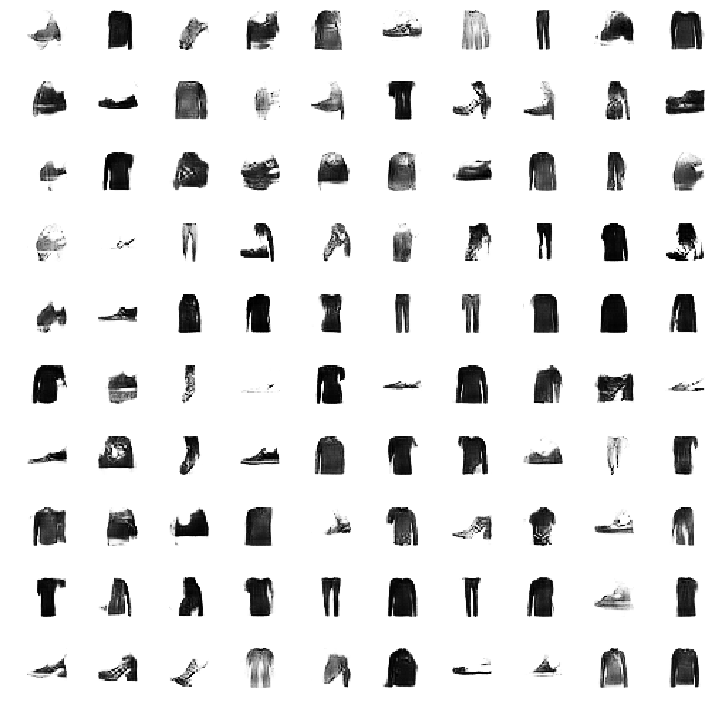

>Saved: generated_plot_0046.png and model_0046.h5
>46, 1/468, d1=-1090.615, d2=972.501 g=-943.092
>46, 2/468, d1=-1071.521, d2=985.561 g=-979.395
>46, 3/468, d1=-1090.897, d2=1022.644 g=-962.985
>46, 4/468, d1=-1076.521, d2=950.164 g=-1012.359
>46, 5/468, d1=-1058.222, d2=973.703 g=-1000.396
>46, 6/468, d1=-1063.765, d2=995.475 g=-997.115
>46, 7/468, d1=-1073.271, d2=1018.988 g=-1002.459
>46, 8/468, d1=-1066.490, d2=1002.171 g=-981.488
>46, 9/468, d1=-1052.298, d2=996.548 g=-1005.256
>46, 10/468, d1=-1041.949, d2=1001.003 g=-982.798
>46, 11/468, d1=-1072.452, d2=1019.260 g=-1004.927
>46, 12/468, d1=-1075.483, d2=1009.220 g=-1004.004
>46, 13/468, d1=-1072.404, d2=1002.033 g=-1038.112
>46, 14/468, d1=-1069.275, d2=1032.450 g=-1024.236
>46, 15/468, d1=-1077.546, d2=1024.142 g=-962.208
>46, 16/468, d1=-1075.669, d2=1015.003 g=-984.106
>46, 17/468, d1=-1074.114, d2=1024.116 g=-952.365
>46, 18/468, d1=-1074.469, d2=1018.017 g=-910.413
>46, 19/468, d1=-1059.894, d2=1018.530 g=-941.794
>46, 20

>46, 163/468, d1=-1094.500, d2=1038.268 g=-987.087
>46, 164/468, d1=-1081.859, d2=1039.896 g=-935.607
>46, 165/468, d1=-1077.566, d2=1031.128 g=-924.118
>46, 166/468, d1=-1087.735, d2=1025.694 g=-904.401
>46, 167/468, d1=-1087.712, d2=1034.109 g=-894.124
>46, 168/468, d1=-1098.227, d2=1030.426 g=-932.512
>46, 169/468, d1=-1097.097, d2=1031.675 g=-935.135
>46, 170/468, d1=-1093.642, d2=1039.399 g=-901.739
>46, 171/468, d1=-1104.010, d2=1042.145 g=-924.172
>46, 172/468, d1=-1096.483, d2=1057.469 g=-921.213
>46, 173/468, d1=-1100.545, d2=1034.187 g=-904.759
>46, 174/468, d1=-1090.880, d2=1043.692 g=-938.003
>46, 175/468, d1=-1090.092, d2=1042.647 g=-933.868
>46, 176/468, d1=-1082.443, d2=1029.502 g=-903.786
>46, 177/468, d1=-1086.619, d2=1042.160 g=-936.289
>46, 178/468, d1=-1097.479, d2=1010.493 g=-1008.904
>46, 179/468, d1=-1093.556, d2=985.462 g=-1031.690
>46, 180/468, d1=-1087.378, d2=999.413 g=-1009.497
>46, 181/468, d1=-1112.525, d2=982.162 g=-1118.146
>46, 182/468, d1=-1083.188, d2

>46, 324/468, d1=-1124.481, d2=1075.584 g=-973.929
>46, 325/468, d1=-1131.801, d2=1057.439 g=-986.262
>46, 326/468, d1=-1133.527, d2=1062.055 g=-1009.369
>46, 327/468, d1=-1128.489, d2=998.532 g=-1071.642
>46, 328/468, d1=-1109.138, d2=1044.119 g=-1100.186
>46, 329/468, d1=-1137.167, d2=1024.245 g=-1142.975
>46, 330/468, d1=-1138.096, d2=1011.420 g=-1206.220
>46, 331/468, d1=-1134.163, d2=1049.451 g=-1228.782
>46, 332/468, d1=-1131.070, d2=1024.220 g=-1220.924
>46, 333/468, d1=-1125.262, d2=1007.656 g=-1253.450
>46, 334/468, d1=-1118.373, d2=1015.376 g=-1211.254
>46, 335/468, d1=-1138.105, d2=995.416 g=-1269.641
>46, 336/468, d1=-1123.546, d2=996.593 g=-1253.561
>46, 337/468, d1=-1090.620, d2=996.702 g=-1183.690
>46, 338/468, d1=-1142.235, d2=1009.289 g=-1183.113
>46, 339/468, d1=-1139.659, d2=987.925 g=-1267.587
>46, 340/468, d1=-1119.598, d2=985.826 g=-1190.113
>46, 341/468, d1=-1128.821, d2=982.178 g=-1220.637
>46, 342/468, d1=-1151.505, d2=1028.418 g=-1255.432
>46, 343/468, d1=-114

>47, 17/468, d1=-1080.731, d2=985.612 g=-1172.852
>47, 18/468, d1=-1077.869, d2=962.388 g=-1122.018
>47, 19/468, d1=-1098.842, d2=964.531 g=-1129.648
>47, 20/468, d1=-1103.541, d2=977.217 g=-1083.644
>47, 21/468, d1=-1105.638, d2=974.569 g=-1159.782
>47, 22/468, d1=-1066.059, d2=976.291 g=-1103.176
>47, 23/468, d1=-1083.200, d2=1002.362 g=-1107.321
>47, 24/468, d1=-1079.232, d2=1002.975 g=-1056.488
>47, 25/468, d1=-1104.705, d2=1009.858 g=-1070.396
>47, 26/468, d1=-1108.031, d2=1011.379 g=-984.358
>47, 27/468, d1=-1098.034, d2=1010.768 g=-1044.033
>47, 28/468, d1=-1095.747, d2=1008.975 g=-1029.917
>47, 29/468, d1=-1097.673, d2=1000.305 g=-1043.084
>47, 30/468, d1=-1115.746, d2=986.590 g=-939.919
>47, 31/468, d1=-1088.928, d2=985.241 g=-971.568
>47, 32/468, d1=-1105.876, d2=999.179 g=-951.288
>47, 33/468, d1=-1065.292, d2=991.521 g=-834.558
>47, 34/468, d1=-1094.524, d2=989.981 g=-778.233
>47, 35/468, d1=-1087.132, d2=992.132 g=-806.289
>47, 36/468, d1=-1087.520, d2=1016.717 g=-870.645


>47, 180/468, d1=-1035.914, d2=1002.262 g=-979.552
>47, 181/468, d1=-1043.385, d2=1004.940 g=-993.753
>47, 182/468, d1=-1077.391, d2=980.370 g=-995.349
>47, 183/468, d1=-1068.093, d2=963.986 g=-1068.243
>47, 184/468, d1=-1117.602, d2=1031.926 g=-1109.659
>47, 185/468, d1=-1079.103, d2=998.552 g=-1103.852
>47, 186/468, d1=-1076.788, d2=1037.495 g=-1087.176
>47, 187/468, d1=-1087.087, d2=992.176 g=-1094.230
>47, 188/468, d1=-1058.524, d2=996.861 g=-1037.871
>47, 189/468, d1=-1048.910, d2=1008.511 g=-1043.324
>47, 190/468, d1=-1089.937, d2=1004.935 g=-1039.476
>47, 191/468, d1=-1084.170, d2=979.154 g=-1112.075
>47, 192/468, d1=-1064.593, d2=1033.245 g=-1001.511
>47, 193/468, d1=-1072.312, d2=987.264 g=-1105.523
>47, 194/468, d1=-1064.049, d2=1028.036 g=-1037.288
>47, 195/468, d1=-1056.087, d2=1026.840 g=-951.105
>47, 196/468, d1=-1074.660, d2=1035.500 g=-1023.179
>47, 197/468, d1=-1083.974, d2=1040.144 g=-1021.344
>47, 198/468, d1=-1091.067, d2=1034.399 g=-956.418
>47, 199/468, d1=-1097.7

>47, 342/468, d1=-1038.125, d2=991.770 g=-1057.766
>47, 343/468, d1=-1053.634, d2=999.170 g=-1048.540
>47, 344/468, d1=-1060.979, d2=1014.755 g=-981.132
>47, 345/468, d1=-1094.575, d2=1001.596 g=-1021.623
>47, 346/468, d1=-1042.950, d2=1007.517 g=-1056.492
>47, 347/468, d1=-1048.152, d2=1017.119 g=-1018.357
>47, 348/468, d1=-1077.605, d2=1016.461 g=-1031.168
>47, 349/468, d1=-1094.976, d2=1030.565 g=-982.042
>47, 350/468, d1=-1080.773, d2=1023.016 g=-929.073
>47, 351/468, d1=-1078.118, d2=1020.468 g=-961.320
>47, 352/468, d1=-1087.489, d2=1018.313 g=-968.489
>47, 353/468, d1=-1097.385, d2=1027.619 g=-950.562
>47, 354/468, d1=-1095.507, d2=1039.047 g=-982.190
>47, 355/468, d1=-1100.098, d2=1050.761 g=-984.111
>47, 356/468, d1=-1116.665, d2=1065.134 g=-962.514
>47, 357/468, d1=-1099.876, d2=1041.184 g=-985.435
>47, 358/468, d1=-1097.533, d2=1054.247 g=-954.091
>47, 359/468, d1=-1090.323, d2=1029.434 g=-915.637
>47, 360/468, d1=-1082.417, d2=1031.025 g=-913.052
>47, 361/468, d1=-1104.598,

>48, 37/468, d1=-1075.592, d2=1041.522 g=-974.917
>48, 38/468, d1=-1090.443, d2=1072.908 g=-1015.273
>48, 39/468, d1=-1100.347, d2=1054.978 g=-1019.269
>48, 40/468, d1=-1121.833, d2=1069.083 g=-1033.260
>48, 41/468, d1=-1121.889, d2=1093.969 g=-1009.934
>48, 42/468, d1=-1114.369, d2=1071.501 g=-993.189
>48, 43/468, d1=-1131.033, d2=1066.678 g=-1001.039
>48, 44/468, d1=-1132.176, d2=1077.644 g=-961.845
>48, 45/468, d1=-1132.433, d2=1072.357 g=-956.617
>48, 46/468, d1=-1124.460, d2=1068.652 g=-1012.170
>48, 47/468, d1=-1121.662, d2=1058.761 g=-1032.344
>48, 48/468, d1=-1126.659, d2=1068.427 g=-1037.000
>48, 49/468, d1=-1109.581, d2=1066.317 g=-1037.536
>48, 50/468, d1=-1102.886, d2=1042.964 g=-1026.906
>48, 51/468, d1=-1112.478, d2=1046.382 g=-993.552
>48, 52/468, d1=-1097.783, d2=1028.266 g=-1034.459
>48, 53/468, d1=-1110.065, d2=1030.574 g=-995.497
>48, 54/468, d1=-1097.848, d2=1031.595 g=-968.969
>48, 55/468, d1=-1089.024, d2=1038.570 g=-911.851
>48, 56/468, d1=-1099.166, d2=1043.885 

>48, 202/468, d1=-1087.246, d2=979.869 g=-954.666
>48, 203/468, d1=-1078.938, d2=976.902 g=-973.273
>48, 204/468, d1=-1092.777, d2=958.989 g=-987.734
>48, 205/468, d1=-1091.874, d2=947.836 g=-1041.336
>48, 206/468, d1=-1072.879, d2=921.487 g=-1085.718
>48, 207/468, d1=-1081.066, d2=943.625 g=-1131.224
>48, 208/468, d1=-1074.902, d2=903.831 g=-1160.920
>48, 209/468, d1=-1079.531, d2=941.790 g=-1159.991
>48, 210/468, d1=-1103.422, d2=943.154 g=-1203.623
>48, 211/468, d1=-1082.945, d2=923.108 g=-1224.557
>48, 212/468, d1=-1105.804, d2=919.676 g=-1309.683
>48, 213/468, d1=-1078.727, d2=940.827 g=-1294.845
>48, 214/468, d1=-1075.029, d2=950.808 g=-1298.816
>48, 215/468, d1=-1066.525, d2=956.269 g=-1281.991
>48, 216/468, d1=-1100.471, d2=940.498 g=-1325.077
>48, 217/468, d1=-1095.510, d2=949.949 g=-1342.293
>48, 218/468, d1=-1085.962, d2=959.196 g=-1343.430
>48, 219/468, d1=-1068.679, d2=949.501 g=-1317.932
>48, 220/468, d1=-1093.463, d2=931.634 g=-1394.681
>48, 221/468, d1=-1062.892, d2=936

>48, 364/468, d1=-1084.528, d2=855.410 g=-1422.548
>48, 365/468, d1=-1009.702, d2=902.492 g=-1339.116
>48, 366/468, d1=-1083.750, d2=871.282 g=-1394.996
>48, 367/468, d1=-1109.344, d2=890.184 g=-1423.138
>48, 368/468, d1=-1076.867, d2=879.477 g=-1467.047
>48, 369/468, d1=-1076.756, d2=900.206 g=-1358.313
>48, 370/468, d1=-1088.963, d2=881.441 g=-1436.724
>48, 371/468, d1=-1073.249, d2=870.820 g=-1474.836
>48, 372/468, d1=-1071.834, d2=881.157 g=-1354.427
>48, 373/468, d1=-1082.246, d2=842.001 g=-1357.269
>48, 374/468, d1=-1051.690, d2=851.254 g=-1323.697
>48, 375/468, d1=-1078.552, d2=907.188 g=-1254.088
>48, 376/468, d1=-1120.132, d2=920.663 g=-1341.932
>48, 377/468, d1=-1082.935, d2=912.048 g=-1196.821
>48, 378/468, d1=-1096.799, d2=904.784 g=-1119.396
>48, 379/468, d1=-1143.100, d2=915.721 g=-1027.641
>48, 380/468, d1=-1184.932, d2=978.715 g=-1077.993
>48, 381/468, d1=-1149.685, d2=978.135 g=-1033.432
>48, 382/468, d1=-1155.632, d2=1063.339 g=-1125.831
>48, 383/468, d1=-1151.197, d2

>49, 58/468, d1=-1101.346, d2=1044.597 g=-1032.847
>49, 59/468, d1=-1106.307, d2=1024.616 g=-1062.115
>49, 60/468, d1=-1105.701, d2=1033.540 g=-1122.723
>49, 61/468, d1=-1095.607, d2=1017.354 g=-1102.509
>49, 62/468, d1=-1102.203, d2=1017.945 g=-1094.350
>49, 63/468, d1=-1101.774, d2=1022.907 g=-1049.380
>49, 64/468, d1=-1087.696, d2=1017.844 g=-1023.727
>49, 65/468, d1=-1107.413, d2=1014.141 g=-1017.310
>49, 66/468, d1=-1111.074, d2=1009.456 g=-1099.651
>49, 67/468, d1=-1106.230, d2=1022.298 g=-1070.114
>49, 68/468, d1=-1096.818, d2=1005.896 g=-1091.370
>49, 69/468, d1=-1117.664, d2=973.934 g=-1153.857
>49, 70/468, d1=-1087.240, d2=975.427 g=-1166.381
>49, 71/468, d1=-1078.888, d2=993.940 g=-1077.340
>49, 72/468, d1=-1120.942, d2=986.903 g=-1056.010
>49, 73/468, d1=-1092.987, d2=1000.865 g=-1000.995
>49, 74/468, d1=-1106.602, d2=979.880 g=-980.017
>49, 75/468, d1=-1124.370, d2=997.010 g=-979.238
>49, 76/468, d1=-1120.257, d2=1006.854 g=-914.502
>49, 77/468, d1=-1125.120, d2=1005.319 g

>49, 219/468, d1=-1079.172, d2=962.652 g=-1167.769
>49, 220/468, d1=-1058.752, d2=984.807 g=-1087.089
>49, 221/468, d1=-1093.932, d2=969.506 g=-1105.174
>49, 222/468, d1=-1100.507, d2=990.357 g=-1103.517
>49, 223/468, d1=-1098.586, d2=993.111 g=-1055.542
>49, 224/468, d1=-1064.148, d2=984.178 g=-1090.117
>49, 225/468, d1=-1077.043, d2=979.462 g=-1120.693
>49, 226/468, d1=-1098.498, d2=974.495 g=-1014.694
>49, 227/468, d1=-1099.364, d2=986.734 g=-1031.551
>49, 228/468, d1=-1101.297, d2=996.325 g=-979.072
>49, 229/468, d1=-1100.940, d2=991.140 g=-922.001
>49, 230/468, d1=-1099.370, d2=998.169 g=-978.167
>49, 231/468, d1=-1123.832, d2=994.239 g=-923.127
>49, 232/468, d1=-1107.943, d2=1036.704 g=-944.554
>49, 233/468, d1=-1113.913, d2=1036.922 g=-922.002
>49, 234/468, d1=-1125.542, d2=1028.965 g=-951.791
>49, 235/468, d1=-1092.385, d2=1035.211 g=-897.155
>49, 236/468, d1=-1097.683, d2=1025.706 g=-867.693
>49, 237/468, d1=-1109.220, d2=1037.906 g=-842.612
>49, 238/468, d1=-1085.372, d2=1016

>49, 381/468, d1=-1071.210, d2=979.775 g=-1104.133
>49, 382/468, d1=-1086.396, d2=1009.532 g=-1050.151
>49, 383/468, d1=-1075.348, d2=996.356 g=-998.216
>49, 384/468, d1=-1086.616, d2=997.610 g=-970.472
>49, 385/468, d1=-1090.832, d2=962.152 g=-901.591
>49, 386/468, d1=-1084.994, d2=962.013 g=-946.590
>49, 387/468, d1=-1079.806, d2=987.001 g=-937.614
>49, 388/468, d1=-1093.473, d2=1007.817 g=-930.315
>49, 389/468, d1=-1079.327, d2=1008.238 g=-863.865
>49, 390/468, d1=-1108.797, d2=1003.537 g=-895.069
>49, 391/468, d1=-1088.590, d2=981.273 g=-878.432
>49, 392/468, d1=-1076.365, d2=953.838 g=-812.418
>49, 393/468, d1=-1099.402, d2=941.066 g=-737.834
>49, 394/468, d1=-1080.782, d2=927.191 g=-718.364
>49, 395/468, d1=-1051.444, d2=907.617 g=-689.920
>49, 396/468, d1=-1038.810, d2=915.193 g=-757.104
>49, 397/468, d1=-1039.635, d2=915.053 g=-751.105
>49, 398/468, d1=-1035.635, d2=871.118 g=-805.839
>49, 399/468, d1=-1032.345, d2=862.497 g=-821.978
>49, 400/468, d1=-1022.225, d2=859.802 g=-89

>50, 78/468, d1=-1055.966, d2=983.947 g=-1060.135
>50, 79/468, d1=-1061.804, d2=993.861 g=-1094.267
>50, 80/468, d1=-1059.715, d2=990.407 g=-1032.061
>50, 81/468, d1=-1063.274, d2=999.832 g=-1072.502
>50, 82/468, d1=-1047.340, d2=1000.916 g=-1069.226
>50, 83/468, d1=-1043.571, d2=1020.651 g=-1070.496
>50, 84/468, d1=-1066.231, d2=1018.440 g=-1026.465
>50, 85/468, d1=-1061.603, d2=999.083 g=-1011.927
>50, 86/468, d1=-1044.401, d2=999.759 g=-965.138
>50, 87/468, d1=-1041.551, d2=983.242 g=-927.380
>50, 88/468, d1=-1067.293, d2=992.618 g=-953.592
>50, 89/468, d1=-1037.389, d2=1011.201 g=-934.061
>50, 90/468, d1=-1052.285, d2=1005.010 g=-947.714
>50, 91/468, d1=-1070.866, d2=984.661 g=-934.027
>50, 92/468, d1=-1041.044, d2=993.120 g=-970.477
>50, 93/468, d1=-1071.422, d2=1009.087 g=-919.887
>50, 94/468, d1=-1063.524, d2=982.644 g=-964.069
>50, 95/468, d1=-1068.833, d2=1002.900 g=-954.712
>50, 96/468, d1=-1053.483, d2=992.056 g=-898.025
>50, 97/468, d1=-1027.135, d2=984.286 g=-886.402
>50, 

>50, 242/468, d1=-1055.921, d2=994.461 g=-999.612
>50, 243/468, d1=-1066.432, d2=1000.180 g=-1038.084
>50, 244/468, d1=-1084.668, d2=1013.797 g=-1028.985
>50, 245/468, d1=-1071.646, d2=1025.734 g=-1026.672
>50, 246/468, d1=-1054.465, d2=1028.683 g=-932.784
>50, 247/468, d1=-1065.537, d2=1020.757 g=-990.481
>50, 248/468, d1=-1061.199, d2=1028.931 g=-955.862
>50, 249/468, d1=-1081.231, d2=1022.561 g=-976.055
>50, 250/468, d1=-1076.435, d2=1014.417 g=-970.229
>50, 251/468, d1=-1061.683, d2=1006.023 g=-929.027
>50, 252/468, d1=-1050.792, d2=994.576 g=-893.685
>50, 253/468, d1=-1068.569, d2=1004.425 g=-879.966
>50, 254/468, d1=-1063.172, d2=1008.396 g=-895.403
>50, 255/468, d1=-1063.091, d2=1006.724 g=-898.942
>50, 256/468, d1=-1063.504, d2=1005.759 g=-916.551
>50, 257/468, d1=-1071.562, d2=1014.781 g=-892.946
>50, 258/468, d1=-1076.148, d2=1012.018 g=-884.213
>50, 259/468, d1=-1074.186, d2=989.248 g=-898.481
>50, 260/468, d1=-1085.113, d2=1002.057 g=-909.798
>50, 261/468, d1=-1087.673, d2=

>50, 406/468, d1=-1037.964, d2=967.636 g=-846.734
>50, 407/468, d1=-1048.708, d2=970.943 g=-849.966
>50, 408/468, d1=-1058.345, d2=970.138 g=-857.089
>50, 409/468, d1=-1070.334, d2=977.769 g=-866.239
>50, 410/468, d1=-1067.996, d2=995.897 g=-851.487
>50, 411/468, d1=-1061.513, d2=989.574 g=-893.350
>50, 412/468, d1=-1065.475, d2=983.603 g=-893.745
>50, 413/468, d1=-1072.451, d2=980.566 g=-881.405
>50, 414/468, d1=-1054.980, d2=974.530 g=-894.368
>50, 415/468, d1=-1078.121, d2=949.203 g=-959.016
>50, 416/468, d1=-1039.446, d2=973.493 g=-926.566
>50, 417/468, d1=-1061.448, d2=993.339 g=-923.424
>50, 418/468, d1=-1074.266, d2=985.889 g=-956.242
>50, 419/468, d1=-1061.636, d2=987.791 g=-977.514
>50, 420/468, d1=-1060.915, d2=980.132 g=-1020.821
>50, 421/468, d1=-1041.537, d2=996.790 g=-1012.260
>50, 422/468, d1=-1057.515, d2=982.049 g=-1019.245
>50, 423/468, d1=-1046.786, d2=961.946 g=-1010.766
>50, 424/468, d1=-1035.712, d2=954.027 g=-1028.728
>50, 425/468, d1=-1039.310, d2=959.260 g=-980

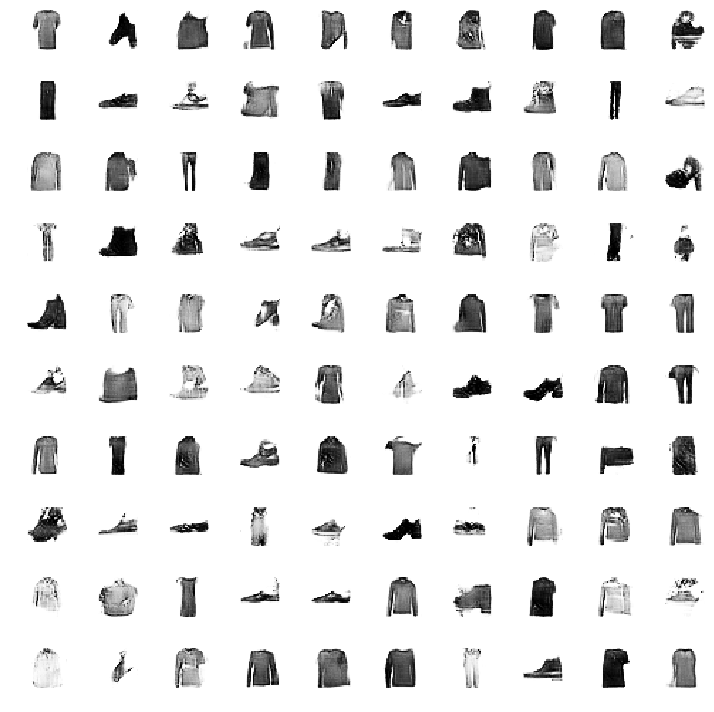

>Saved: generated_plot_0051.png and model_0051.h5


In [82]:
# train model
fashion_wgan.train(X, n_epochs=50, reporting_period=5)

Plot metrics out. The Wasserstein loss seeks scores for real and fake that are more different during training.

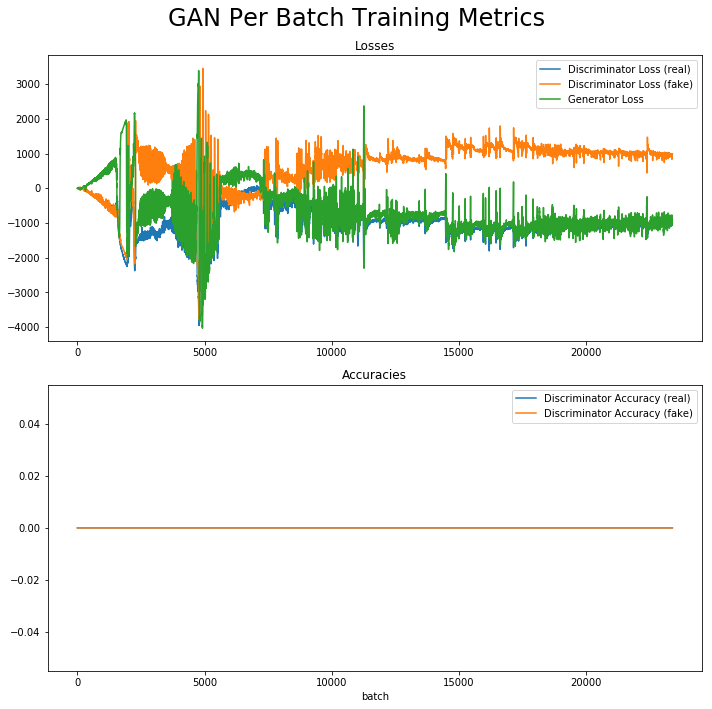

In [85]:
fashion_wgan.plot_training_metrics()

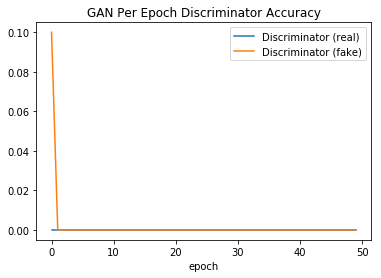

In [86]:
fashion_wgan.plot_discriminator_accuracies()